# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Imports and Settings

In [1]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [3]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [4]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [5]:
DATA_STORE = '../data/assets.h5'

In [6]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [7]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [8]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [9]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [10]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [11]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [12]:
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      358914 non-null  float64
 1   return_2m      358914 non-null  float64
 2   return_3m      358914 non-null  float64
 3   return_6m      358914 non-null  float64
 4   return_9m      358914 non-null  float64
 5   return_12m     358914 non-null  float64
 6   Mkt-RF         358914 non-null  float64
 7   SMB            358914 non-null  float64
 8   HML            358914 non-null  float64
 9   RMW            358914 non-null  float64
 10  CMA            358914 non-null  float64
 11  momentum_2     358914 non-null  float64
 12  momentum_3     358914 non-null  float64
 13  momentum_6     358914 non-null  float64
 14  momentum_9     358914 non-null  float64
 15  momentum_12    358914 non-null  float64
 16  

In [13]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator.

In [14]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [15]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [16]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [17]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [18]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                          X=X,
                          y=y,
                          scoring=list(metrics.keys()),
                          cv=cv,
                          return_train_score=True,
                          n_jobs=n_jobs,
                          verbose=1,
                          fit_params=fit_params)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [19]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [20]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [21]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [22]:
algo = 'dummy_clf'

In [23]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.2s finished


Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [24]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.503582,0.500008
Accuracy,0.503582,0.500008
F1,0.516424,0.504660
Log Loss,-17.070718,-17.109954
Precision,0.548116,0.504698
Recall,0.505758,0.504622


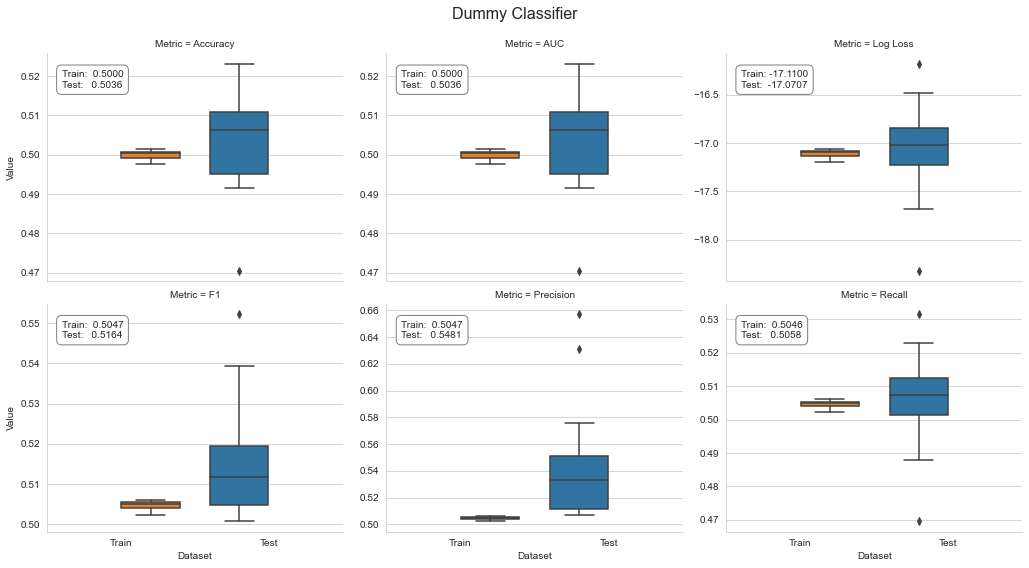

In [25]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [26]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [27]:
algo = 'random_forest'

In [28]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  8.6min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.6min finished


### Plot Results

In [29]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.527921,1.000000
Accuracy,0.511685,0.999999
F1,0.507196,0.999999
Log Loss,-0.691195,-0.169444
Precision,0.564603,0.999999
Recall,0.539264,0.999999


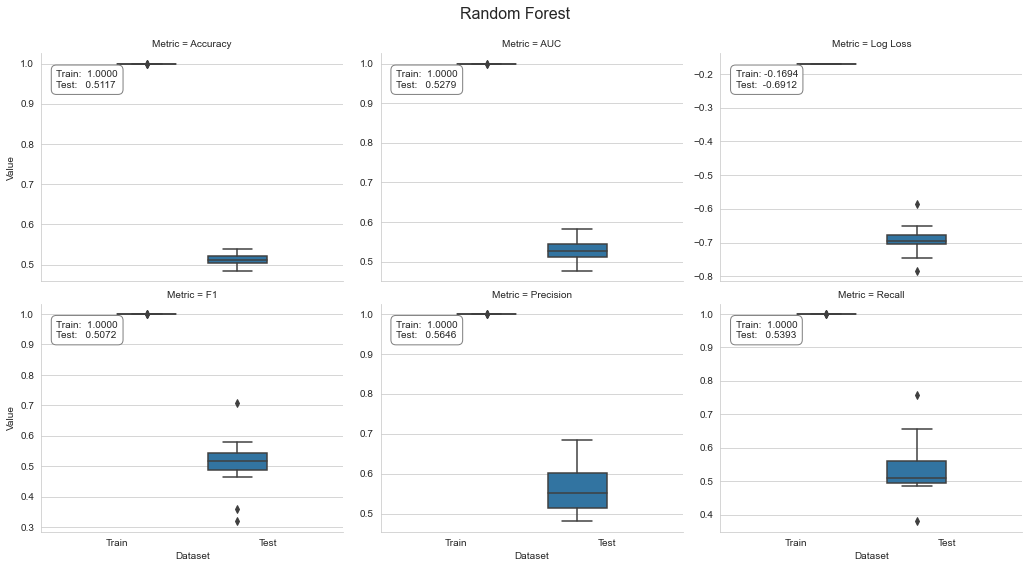

In [30]:
plot_result(rf_result, model='Random Forest')

## scikit-learn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [31]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [32]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [33]:
algo = 'adaboost'

In [34]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.6min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.7min finished


### Plot Result

In [35]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.535296,0.608166
Accuracy,0.503753,0.569050
F1,0.461851,0.570795
Log Loss,-0.692853,-0.692696
Precision,0.542131,0.583440
Recall,0.570321,0.588034


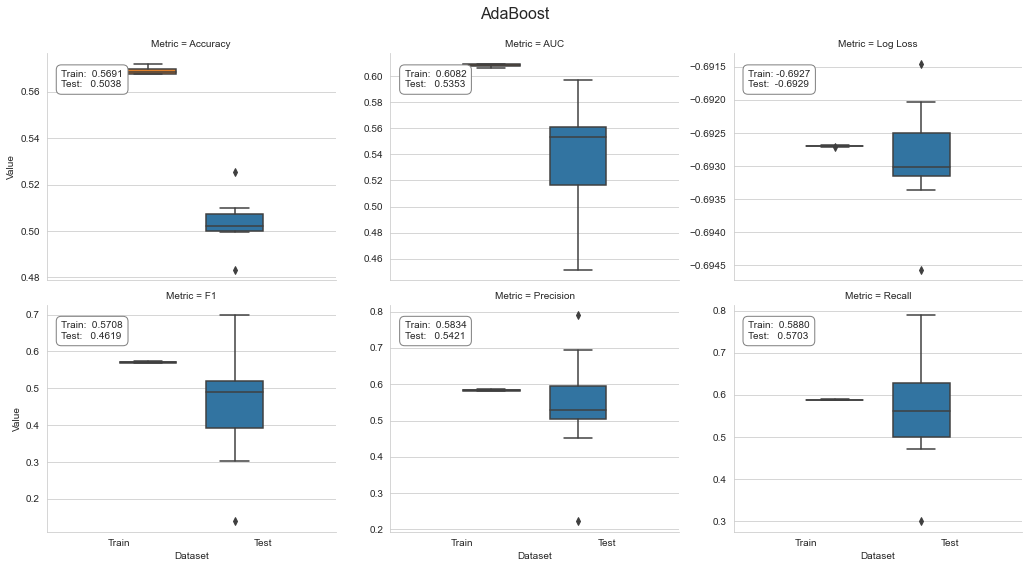

In [36]:
plot_result(ada_result, model='AdaBoost')

## scikit-learn: GradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

The available loss functions include the exponential loss that leads to the AdaBoost algorithm and the deviance that corresponds to the logistic regression for probabilistic outputs. 

The `friedman_mse` node quality measure is a variation on the mean squared error that includes an improvement score (see GitHub references for links to original papers), as shown in the following code:

In [37]:
gb_clf = GradientBoostingClassifier(loss='deviance',                # deviance = logistic reg; exponential: AdaBoost
                                    learning_rate=0.1,              # shrinks the contribution of each tree
                                    n_estimators=100,               # number of boosting stages
                                    subsample=1.0,                  # fraction of samples used t fit base learners
                                    criterion='friedman_mse',       # measures the quality of a split
                                    min_samples_split=2,            
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0,   # min. fraction of sum of weights
                                    max_depth=3,                    # opt value depends on interaction
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    init=None, 
                                    random_state=None, 
                                    max_features=None, 
                                    verbose=0, 
                                    max_leaf_nodes=None, 
                                    warm_start=False, 
                                    presort='auto', 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=0.0001)

### Cross-validate

In [38]:
algo = 'sklearn_gbm'

In [39]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 12.4min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.4min finished


### Plot Results

In [40]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.537038,0.693621
Accuracy,0.503854,0.625333
F1,0.462321,0.629539
Log Loss,-0.684883,-0.638559
Precision,0.549380,0.645005
Recall,0.572452,0.642710


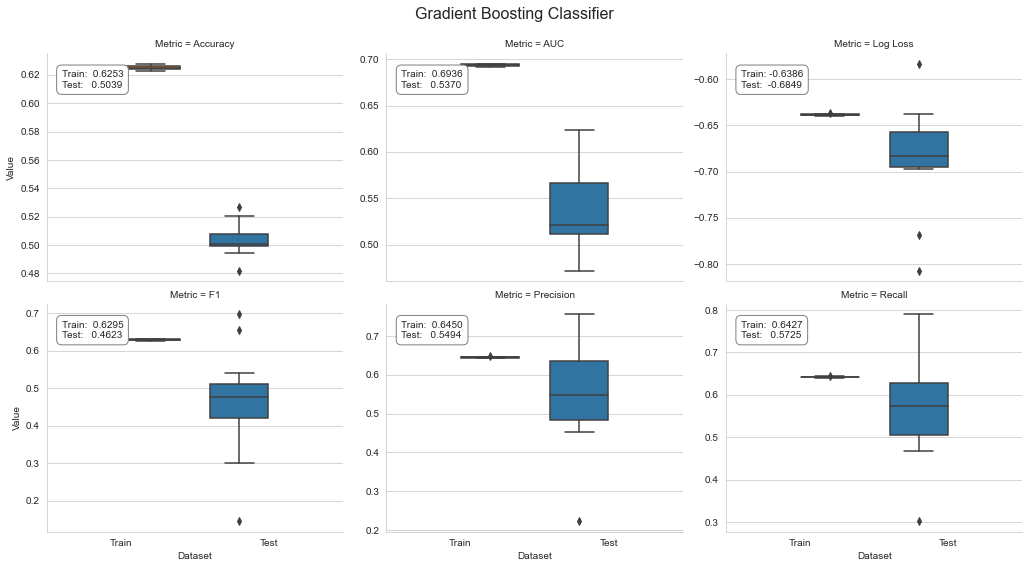

In [41]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plots

Drop time periods to avoid over-reliance for in-sample fit.

In [42]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)

In [43]:
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [44]:
# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.561131999462871

In [45]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.5636298437281709

#### Feature Importance

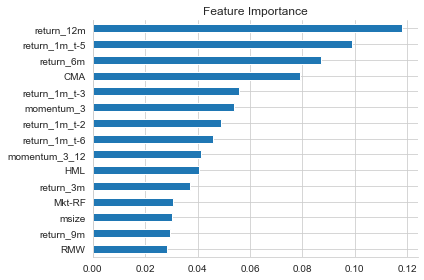

In [46]:
(pd.Series(gb_clf.feature_importances_, 
          index=X_.columns)
 .sort_values(ascending=False)
 .head(15)).sort_values().plot.barh(title='Feature Importance')
sns.despine()
plt.tight_layout();

#### One-way and two-way partial depende plots

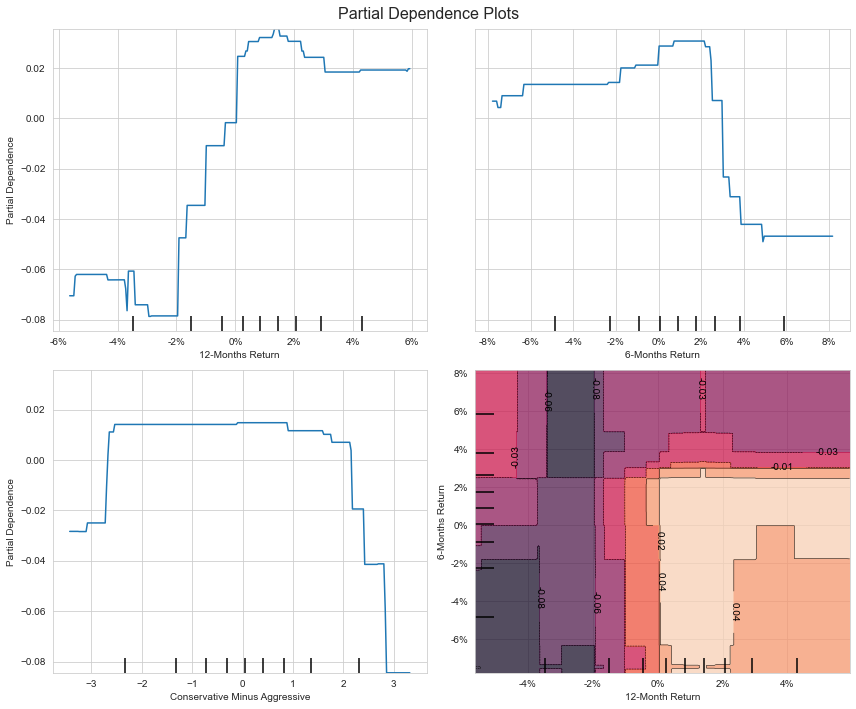

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.savefig('figures/partial_dep_2d', dpi=300);

#### Two-way partial dependence as 3D plot

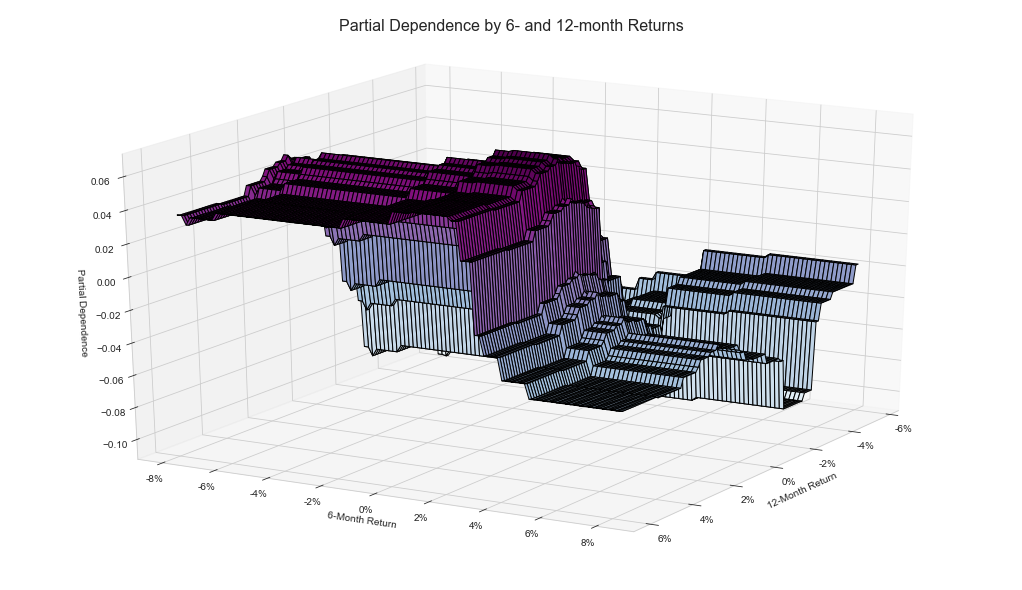

In [48]:
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout()
fig.savefig('figures/partial_dep_3d', dpi=300)

## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [49]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [50]:
algo = 'xgboost'

In [51]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  5.0min remaining:   59.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.0min finished


### Plot Results

In [52]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.526594,0.685139
Accuracy,0.504881,0.617565
F1,0.398587,0.620617
Log Loss,-0.704742,-0.643618
Precision,0.546037,0.640024
Recall,0.499456,0.636671


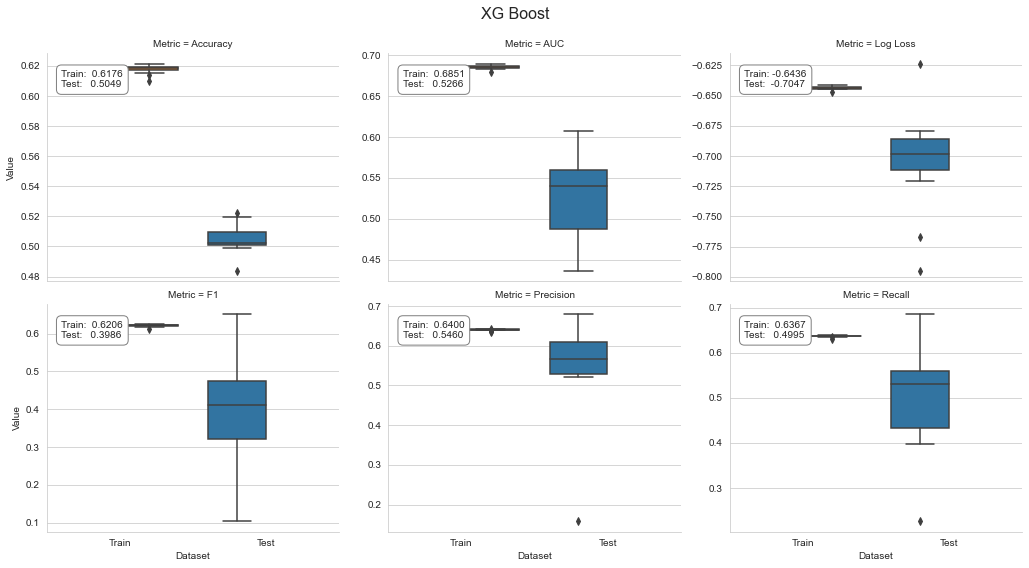

In [53]:
plot_result(xbg_result, model='XG Boost', fname=f'figures/{algo}_cv_result')

### Feature Importance

In [54]:
xgb_clf.fit(X=X_dummies, y=y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [55]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

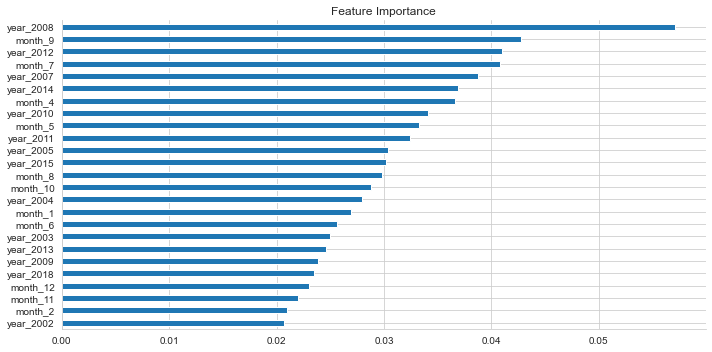

In [56]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [57]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [58]:
algo = 'lgb_factors'

In [59]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   32.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   32.9s finished


##### Plot Results

In [60]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.534029,0.750541
Accuracy,0.514089,0.677236
F1,0.426485,0.683596
Log Loss,-0.717203,-0.592169
Precision,0.554745,0.691563
Recall,0.500317,0.689884


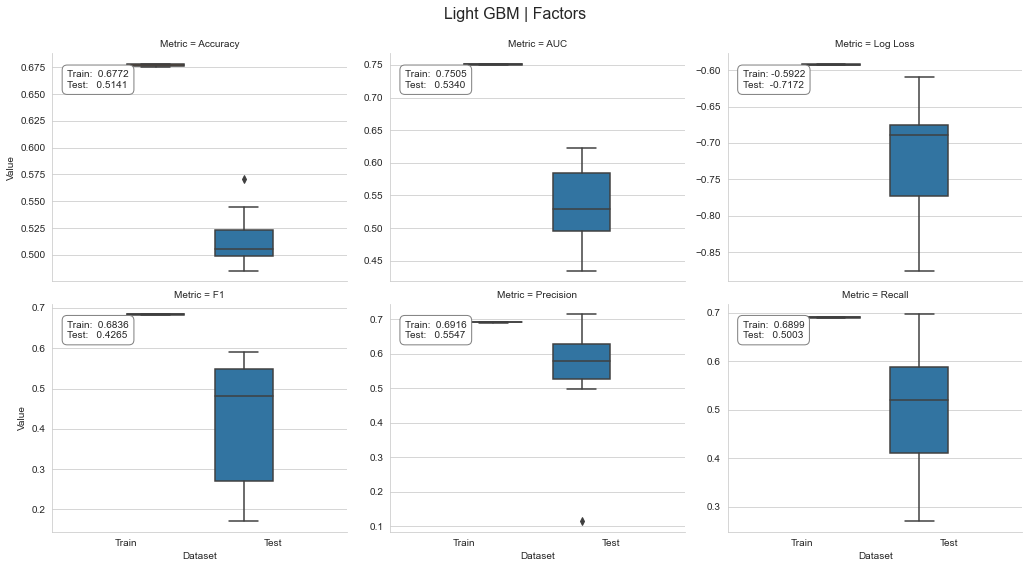

In [61]:
plot_result(lgb_factor_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

#### Using dummy variables

In [62]:
algo = 'lgb_dummies'

In [63]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   28.3s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   28.7s finished


##### Plot results

In [64]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.529225,0.743835
Accuracy,0.514994,0.670435
F1,0.434983,0.676542
Log Loss,-0.702330,-0.600396
Precision,0.581769,0.689018
Recall,0.514509,0.685184


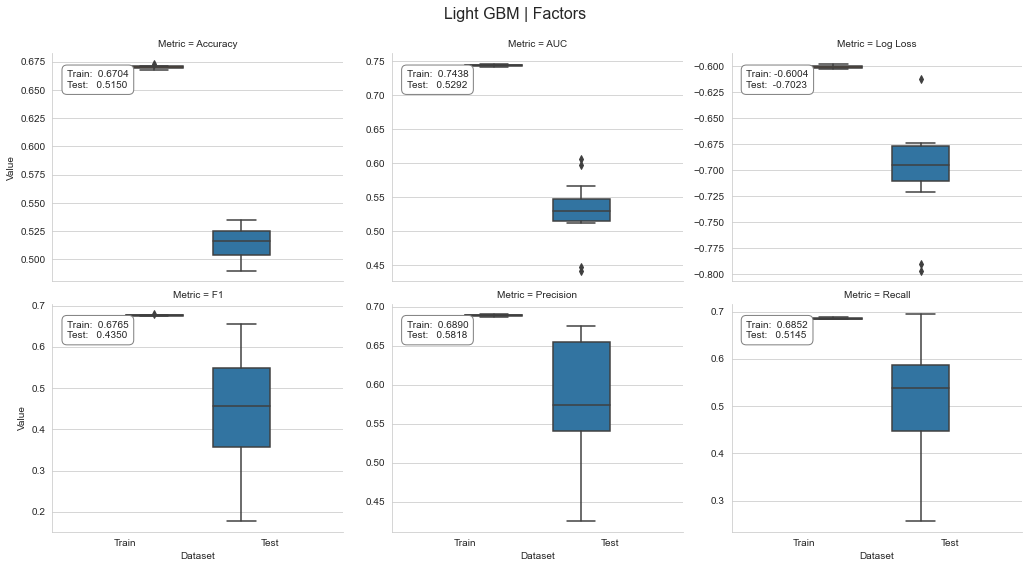

In [65]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [66]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [67]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

Catboost requires integer values for categorical variables.

In [69]:
algo = 'catboost'

In [70]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    cat_cv_result, run_time[algo] = run_cv(cat_clf,
                                           X=X_factors,
                                           fit_params={
                                               'cat_features': cat_cols_idx},
                                           n_jobs=1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.126754
0:	learn: 0.6728320	total: 140ms	remaining: 2m 20s
1:	learn: 0.6574056	total: 227ms	remaining: 1m 53s
2:	learn: 0.6457044	total: 295ms	remaining: 1m 37s
3:	learn: 0.6373654	total: 353ms	remaining: 1m 28s
4:	learn: 0.6307113	total: 434ms	remaining: 1m 26s
5:	learn: 0.6254384	total: 502ms	remaining: 1m 23s
6:	learn: 0.6216797	total: 574ms	remaining: 1m 21s
7:	learn: 0.6185667	total: 663ms	remaining: 1m 22s
8:	learn: 0.6162213	total: 776ms	remaining: 1m 25s
9:	learn: 0.6118082	total: 868ms	remaining: 1m 25s
10:	learn: 0.6082233	total: 963ms	remaining: 1m 26s
11:	learn: 0.6052899	total: 1.04s	remaining: 1m 26s
12:	learn: 0.6034641	total: 1.14s	remaining: 1m 26s
13:	learn: 0.6021615	total: 1.24s	remaining: 1m 27s
14:	learn: 0.6019680	total: 1.35s	remaining: 1m 28s
15:	learn: 0.6009130	total: 1.46s	remaining: 1m 29s
16:	learn: 0.5994848	total: 1.54s	remaining: 1m 29s
17:	learn: 0.5993581	total: 1.66s	remaining: 1m 30s
18:	learn: 0.5992261	total: 1.79s	remaining:

158:	learn: 0.5813542	total: 17.6s	remaining: 1m 33s
159:	learn: 0.5813230	total: 17.8s	remaining: 1m 33s
160:	learn: 0.5812714	total: 17.9s	remaining: 1m 33s
161:	learn: 0.5812053	total: 18s	remaining: 1m 33s
162:	learn: 0.5811640	total: 18.1s	remaining: 1m 33s
163:	learn: 0.5811012	total: 18.2s	remaining: 1m 32s
164:	learn: 0.5810560	total: 18.4s	remaining: 1m 32s
165:	learn: 0.5810233	total: 18.5s	remaining: 1m 32s
166:	learn: 0.5809843	total: 18.6s	remaining: 1m 32s
167:	learn: 0.5809438	total: 18.7s	remaining: 1m 32s
168:	learn: 0.5808726	total: 18.8s	remaining: 1m 32s
169:	learn: 0.5808558	total: 18.9s	remaining: 1m 32s
170:	learn: 0.5808000	total: 19s	remaining: 1m 32s
171:	learn: 0.5807624	total: 19.1s	remaining: 1m 32s
172:	learn: 0.5807058	total: 19.3s	remaining: 1m 32s
173:	learn: 0.5806783	total: 19.4s	remaining: 1m 32s
174:	learn: 0.5806312	total: 19.5s	remaining: 1m 31s
175:	learn: 0.5805861	total: 19.6s	remaining: 1m 31s
176:	learn: 0.5805332	total: 19.7s	remaining: 1m 3

314:	learn: 0.5747822	total: 36s	remaining: 1m 18s
315:	learn: 0.5747493	total: 36.1s	remaining: 1m 18s
316:	learn: 0.5747202	total: 36.2s	remaining: 1m 18s
317:	learn: 0.5746915	total: 36.4s	remaining: 1m 17s
318:	learn: 0.5746677	total: 36.5s	remaining: 1m 17s
319:	learn: 0.5746200	total: 36.6s	remaining: 1m 17s
320:	learn: 0.5745996	total: 36.7s	remaining: 1m 17s
321:	learn: 0.5745835	total: 36.9s	remaining: 1m 17s
322:	learn: 0.5745500	total: 37s	remaining: 1m 17s
323:	learn: 0.5745220	total: 37.1s	remaining: 1m 17s
324:	learn: 0.5744862	total: 37.2s	remaining: 1m 17s
325:	learn: 0.5744566	total: 37.3s	remaining: 1m 17s
326:	learn: 0.5744423	total: 37.4s	remaining: 1m 17s
327:	learn: 0.5744201	total: 37.5s	remaining: 1m 16s
328:	learn: 0.5743818	total: 37.7s	remaining: 1m 16s
329:	learn: 0.5743418	total: 37.8s	remaining: 1m 16s
330:	learn: 0.5743154	total: 37.9s	remaining: 1m 16s
331:	learn: 0.5742763	total: 38s	remaining: 1m 16s
332:	learn: 0.5742463	total: 38.1s	remaining: 1m 16s

472:	learn: 0.5698808	total: 55s	remaining: 1m 1s
473:	learn: 0.5698589	total: 55.1s	remaining: 1m 1s
474:	learn: 0.5698207	total: 55.3s	remaining: 1m 1s
475:	learn: 0.5697834	total: 55.4s	remaining: 1m
476:	learn: 0.5697763	total: 55.5s	remaining: 1m
477:	learn: 0.5697320	total: 55.6s	remaining: 1m
478:	learn: 0.5697088	total: 55.7s	remaining: 1m
479:	learn: 0.5696800	total: 55.9s	remaining: 1m
480:	learn: 0.5696472	total: 56s	remaining: 1m
481:	learn: 0.5696194	total: 56.1s	remaining: 1m
482:	learn: 0.5695754	total: 56.2s	remaining: 1m
483:	learn: 0.5695399	total: 56.3s	remaining: 1m
484:	learn: 0.5695132	total: 56.5s	remaining: 59.9s
485:	learn: 0.5694670	total: 56.6s	remaining: 59.8s
486:	learn: 0.5694228	total: 56.7s	remaining: 59.7s
487:	learn: 0.5693835	total: 56.8s	remaining: 59.6s
488:	learn: 0.5693497	total: 56.9s	remaining: 59.5s
489:	learn: 0.5693118	total: 57.1s	remaining: 59.4s
490:	learn: 0.5692810	total: 57.2s	remaining: 59.3s
491:	learn: 0.5692505	total: 57.3s	remainin

632:	learn: 0.5651874	total: 1m 14s	remaining: 43.1s
633:	learn: 0.5651574	total: 1m 14s	remaining: 43s
634:	learn: 0.5651443	total: 1m 14s	remaining: 42.9s
635:	learn: 0.5651164	total: 1m 14s	remaining: 42.7s
636:	learn: 0.5650857	total: 1m 14s	remaining: 42.6s
637:	learn: 0.5650485	total: 1m 14s	remaining: 42.5s
638:	learn: 0.5650307	total: 1m 15s	remaining: 42.4s
639:	learn: 0.5650044	total: 1m 15s	remaining: 42.3s
640:	learn: 0.5649464	total: 1m 15s	remaining: 42.2s
641:	learn: 0.5649087	total: 1m 15s	remaining: 42s
642:	learn: 0.5648789	total: 1m 15s	remaining: 41.9s
643:	learn: 0.5648465	total: 1m 15s	remaining: 41.8s
644:	learn: 0.5648112	total: 1m 15s	remaining: 41.7s
645:	learn: 0.5648053	total: 1m 15s	remaining: 41.6s
646:	learn: 0.5647739	total: 1m 16s	remaining: 41.5s
647:	learn: 0.5647397	total: 1m 16s	remaining: 41.4s
648:	learn: 0.5647093	total: 1m 16s	remaining: 41.2s
649:	learn: 0.5646993	total: 1m 16s	remaining: 41.1s
650:	learn: 0.5646625	total: 1m 16s	remaining: 41s

788:	learn: 0.5608715	total: 1m 33s	remaining: 24.9s
789:	learn: 0.5608466	total: 1m 33s	remaining: 24.8s
790:	learn: 0.5608141	total: 1m 33s	remaining: 24.7s
791:	learn: 0.5608054	total: 1m 33s	remaining: 24.6s
792:	learn: 0.5607957	total: 1m 33s	remaining: 24.5s
793:	learn: 0.5607671	total: 1m 33s	remaining: 24.4s
794:	learn: 0.5607492	total: 1m 33s	remaining: 24.2s
795:	learn: 0.5607182	total: 1m 34s	remaining: 24.1s
796:	learn: 0.5606829	total: 1m 34s	remaining: 24s
797:	learn: 0.5606676	total: 1m 34s	remaining: 23.9s
798:	learn: 0.5606406	total: 1m 34s	remaining: 23.8s
799:	learn: 0.5606081	total: 1m 34s	remaining: 23.7s
800:	learn: 0.5605789	total: 1m 34s	remaining: 23.5s
801:	learn: 0.5605506	total: 1m 34s	remaining: 23.4s
802:	learn: 0.5605221	total: 1m 35s	remaining: 23.3s
803:	learn: 0.5604751	total: 1m 35s	remaining: 23.2s
804:	learn: 0.5604489	total: 1m 35s	remaining: 23.1s
805:	learn: 0.5604154	total: 1m 35s	remaining: 23s
806:	learn: 0.5603816	total: 1m 35s	remaining: 22.

944:	learn: 0.5568326	total: 1m 52s	remaining: 6.54s
945:	learn: 0.5568184	total: 1m 52s	remaining: 6.42s
946:	learn: 0.5568075	total: 1m 52s	remaining: 6.3s
947:	learn: 0.5567688	total: 1m 52s	remaining: 6.19s
948:	learn: 0.5567352	total: 1m 52s	remaining: 6.07s
949:	learn: 0.5567100	total: 1m 53s	remaining: 5.95s
950:	learn: 0.5566922	total: 1m 53s	remaining: 5.83s
951:	learn: 0.5566679	total: 1m 53s	remaining: 5.71s
952:	learn: 0.5566352	total: 1m 53s	remaining: 5.59s
953:	learn: 0.5566289	total: 1m 53s	remaining: 5.47s
954:	learn: 0.5565733	total: 1m 53s	remaining: 5.35s
955:	learn: 0.5565434	total: 1m 53s	remaining: 5.23s
956:	learn: 0.5565060	total: 1m 53s	remaining: 5.11s
957:	learn: 0.5564758	total: 1m 53s	remaining: 5s
958:	learn: 0.5564511	total: 1m 54s	remaining: 4.88s
959:	learn: 0.5564191	total: 1m 54s	remaining: 4.76s
960:	learn: 0.5564001	total: 1m 54s	remaining: 4.64s
961:	learn: 0.5563663	total: 1m 54s	remaining: 4.52s
962:	learn: 0.5563500	total: 1m 54s	remaining: 4.4

102:	learn: 0.5851583	total: 11s	remaining: 1m 35s
103:	learn: 0.5850464	total: 11.1s	remaining: 1m 35s
104:	learn: 0.5849990	total: 11.2s	remaining: 1m 35s
105:	learn: 0.5849517	total: 11.3s	remaining: 1m 35s
106:	learn: 0.5847737	total: 11.4s	remaining: 1m 35s
107:	learn: 0.5846604	total: 11.6s	remaining: 1m 35s
108:	learn: 0.5846048	total: 11.7s	remaining: 1m 35s
109:	learn: 0.5844914	total: 11.8s	remaining: 1m 35s
110:	learn: 0.5844222	total: 11.9s	remaining: 1m 35s
111:	learn: 0.5843799	total: 12s	remaining: 1m 35s
112:	learn: 0.5843278	total: 12.2s	remaining: 1m 35s
113:	learn: 0.5842980	total: 12.3s	remaining: 1m 35s
114:	learn: 0.5842476	total: 12.4s	remaining: 1m 35s
115:	learn: 0.5841894	total: 12.6s	remaining: 1m 35s
116:	learn: 0.5841407	total: 12.7s	remaining: 1m 35s
117:	learn: 0.5839692	total: 12.8s	remaining: 1m 35s
118:	learn: 0.5839189	total: 12.9s	remaining: 1m 35s
119:	learn: 0.5838668	total: 13s	remaining: 1m 35s
120:	learn: 0.5837677	total: 13.2s	remaining: 1m 35s

259:	learn: 0.5770783	total: 29.5s	remaining: 1m 23s
260:	learn: 0.5770536	total: 29.6s	remaining: 1m 23s
261:	learn: 0.5770233	total: 29.7s	remaining: 1m 23s
262:	learn: 0.5769888	total: 29.8s	remaining: 1m 23s
263:	learn: 0.5769627	total: 29.9s	remaining: 1m 23s
264:	learn: 0.5769132	total: 30s	remaining: 1m 23s
265:	learn: 0.5768689	total: 30.2s	remaining: 1m 23s
266:	learn: 0.5768456	total: 30.3s	remaining: 1m 23s
267:	learn: 0.5767855	total: 30.4s	remaining: 1m 23s
268:	learn: 0.5767500	total: 30.5s	remaining: 1m 22s
269:	learn: 0.5767289	total: 30.6s	remaining: 1m 22s
270:	learn: 0.5766722	total: 30.7s	remaining: 1m 22s
271:	learn: 0.5766522	total: 30.9s	remaining: 1m 22s
272:	learn: 0.5766259	total: 31s	remaining: 1m 22s
273:	learn: 0.5765762	total: 31.1s	remaining: 1m 22s
274:	learn: 0.5765398	total: 31.2s	remaining: 1m 22s
275:	learn: 0.5765080	total: 31.3s	remaining: 1m 22s
276:	learn: 0.5764747	total: 31.5s	remaining: 1m 22s
277:	learn: 0.5764363	total: 31.6s	remaining: 1m 2

416:	learn: 0.5718193	total: 48.1s	remaining: 1m 7s
417:	learn: 0.5718021	total: 48.3s	remaining: 1m 7s
418:	learn: 0.5717579	total: 48.4s	remaining: 1m 7s
419:	learn: 0.5717125	total: 48.5s	remaining: 1m 6s
420:	learn: 0.5717038	total: 48.6s	remaining: 1m 6s
421:	learn: 0.5716690	total: 48.7s	remaining: 1m 6s
422:	learn: 0.5716478	total: 48.9s	remaining: 1m 6s
423:	learn: 0.5716060	total: 49s	remaining: 1m 6s
424:	learn: 0.5715940	total: 49.1s	remaining: 1m 6s
425:	learn: 0.5715559	total: 49.2s	remaining: 1m 6s
426:	learn: 0.5715371	total: 49.3s	remaining: 1m 6s
427:	learn: 0.5714982	total: 49.5s	remaining: 1m 6s
428:	learn: 0.5714645	total: 49.6s	remaining: 1m 5s
429:	learn: 0.5714373	total: 49.7s	remaining: 1m 5s
430:	learn: 0.5714182	total: 49.8s	remaining: 1m 5s
431:	learn: 0.5713861	total: 49.9s	remaining: 1m 5s
432:	learn: 0.5713737	total: 50s	remaining: 1m 5s
433:	learn: 0.5713362	total: 50.2s	remaining: 1m 5s
434:	learn: 0.5713061	total: 50.3s	remaining: 1m 5s
435:	learn: 0.57

577:	learn: 0.5671781	total: 1m 7s	remaining: 49.2s
578:	learn: 0.5671389	total: 1m 7s	remaining: 49.1s
579:	learn: 0.5671351	total: 1m 7s	remaining: 49s
580:	learn: 0.5670731	total: 1m 7s	remaining: 48.9s
581:	learn: 0.5670380	total: 1m 7s	remaining: 48.8s
582:	learn: 0.5670085	total: 1m 8s	remaining: 48.7s
583:	learn: 0.5669691	total: 1m 8s	remaining: 48.5s
584:	learn: 0.5669344	total: 1m 8s	remaining: 48.4s
585:	learn: 0.5668996	total: 1m 8s	remaining: 48.3s
586:	learn: 0.5668489	total: 1m 8s	remaining: 48.2s
587:	learn: 0.5668115	total: 1m 8s	remaining: 48.1s
588:	learn: 0.5667798	total: 1m 8s	remaining: 48s
589:	learn: 0.5667551	total: 1m 8s	remaining: 47.9s
590:	learn: 0.5667157	total: 1m 8s	remaining: 47.7s
591:	learn: 0.5666804	total: 1m 9s	remaining: 47.6s
592:	learn: 0.5666537	total: 1m 9s	remaining: 47.5s
593:	learn: 0.5666430	total: 1m 9s	remaining: 47.4s
594:	learn: 0.5666362	total: 1m 9s	remaining: 47.3s
595:	learn: 0.5666278	total: 1m 9s	remaining: 47.1s
596:	learn: 0.56

733:	learn: 0.5627134	total: 1m 26s	remaining: 31.3s
734:	learn: 0.5627036	total: 1m 26s	remaining: 31.2s
735:	learn: 0.5626855	total: 1m 26s	remaining: 31s
736:	learn: 0.5626815	total: 1m 26s	remaining: 30.9s
737:	learn: 0.5626478	total: 1m 26s	remaining: 30.8s
738:	learn: 0.5626120	total: 1m 26s	remaining: 30.7s
739:	learn: 0.5625798	total: 1m 26s	remaining: 30.6s
740:	learn: 0.5625450	total: 1m 27s	remaining: 30.4s
741:	learn: 0.5625189	total: 1m 27s	remaining: 30.3s
742:	learn: 0.5624752	total: 1m 27s	remaining: 30.2s
743:	learn: 0.5624399	total: 1m 27s	remaining: 30.1s
744:	learn: 0.5624259	total: 1m 27s	remaining: 30s
745:	learn: 0.5624177	total: 1m 27s	remaining: 29.9s
746:	learn: 0.5624008	total: 1m 27s	remaining: 29.7s
747:	learn: 0.5623727	total: 1m 27s	remaining: 29.6s
748:	learn: 0.5623524	total: 1m 28s	remaining: 29.5s
749:	learn: 0.5623183	total: 1m 28s	remaining: 29.4s
750:	learn: 0.5622929	total: 1m 28s	remaining: 29.3s
751:	learn: 0.5622656	total: 1m 28s	remaining: 29.

889:	learn: 0.5585256	total: 1m 45s	remaining: 13s
890:	learn: 0.5584948	total: 1m 45s	remaining: 12.9s
891:	learn: 0.5584615	total: 1m 45s	remaining: 12.8s
892:	learn: 0.5584535	total: 1m 45s	remaining: 12.6s
893:	learn: 0.5584192	total: 1m 45s	remaining: 12.5s
894:	learn: 0.5583889	total: 1m 45s	remaining: 12.4s
895:	learn: 0.5583583	total: 1m 45s	remaining: 12.3s
896:	learn: 0.5583179	total: 1m 46s	remaining: 12.2s
897:	learn: 0.5582920	total: 1m 46s	remaining: 12.1s
898:	learn: 0.5582578	total: 1m 46s	remaining: 11.9s
899:	learn: 0.5582209	total: 1m 46s	remaining: 11.8s
900:	learn: 0.5581934	total: 1m 46s	remaining: 11.7s
901:	learn: 0.5581666	total: 1m 46s	remaining: 11.6s
902:	learn: 0.5581378	total: 1m 46s	remaining: 11.5s
903:	learn: 0.5581035	total: 1m 46s	remaining: 11.3s
904:	learn: 0.5580962	total: 1m 46s	remaining: 11.2s
905:	learn: 0.5580701	total: 1m 47s	remaining: 11.1s
906:	learn: 0.5580420	total: 1m 47s	remaining: 11s
907:	learn: 0.5580294	total: 1m 47s	remaining: 10.

45:	learn: 0.5908472	total: 4.8s	remaining: 1m 39s
46:	learn: 0.5908131	total: 4.9s	remaining: 1m 39s
47:	learn: 0.5906892	total: 5.03s	remaining: 1m 39s
48:	learn: 0.5904344	total: 5.12s	remaining: 1m 39s
49:	learn: 0.5902585	total: 5.22s	remaining: 1m 39s
50:	learn: 0.5901976	total: 5.34s	remaining: 1m 39s
51:	learn: 0.5900467	total: 5.46s	remaining: 1m 39s
52:	learn: 0.5899867	total: 5.58s	remaining: 1m 39s
53:	learn: 0.5896784	total: 5.68s	remaining: 1m 39s
54:	learn: 0.5895587	total: 5.79s	remaining: 1m 39s
55:	learn: 0.5892689	total: 5.89s	remaining: 1m 39s
56:	learn: 0.5892199	total: 6s	remaining: 1m 39s
57:	learn: 0.5890565	total: 6.11s	remaining: 1m 39s
58:	learn: 0.5889835	total: 6.24s	remaining: 1m 39s
59:	learn: 0.5888514	total: 6.35s	remaining: 1m 39s
60:	learn: 0.5886851	total: 6.47s	remaining: 1m 39s
61:	learn: 0.5885903	total: 6.57s	remaining: 1m 39s
62:	learn: 0.5885305	total: 6.68s	remaining: 1m 39s
63:	learn: 0.5884787	total: 6.8s	remaining: 1m 39s
64:	learn: 0.58829

203:	learn: 0.5792327	total: 23.2s	remaining: 1m 30s
204:	learn: 0.5792126	total: 23.3s	remaining: 1m 30s
205:	learn: 0.5791791	total: 23.4s	remaining: 1m 30s
206:	learn: 0.5791412	total: 23.5s	remaining: 1m 30s
207:	learn: 0.5790947	total: 23.7s	remaining: 1m 30s
208:	learn: 0.5790447	total: 23.8s	remaining: 1m 29s
209:	learn: 0.5790165	total: 23.9s	remaining: 1m 29s
210:	learn: 0.5789701	total: 24s	remaining: 1m 29s
211:	learn: 0.5789365	total: 24.1s	remaining: 1m 29s
212:	learn: 0.5788847	total: 24.2s	remaining: 1m 29s
213:	learn: 0.5788474	total: 24.4s	remaining: 1m 29s
214:	learn: 0.5787983	total: 24.5s	remaining: 1m 29s
215:	learn: 0.5787270	total: 24.7s	remaining: 1m 29s
216:	learn: 0.5786718	total: 24.8s	remaining: 1m 29s
217:	learn: 0.5786297	total: 24.9s	remaining: 1m 29s
218:	learn: 0.5785958	total: 25s	remaining: 1m 29s
219:	learn: 0.5785415	total: 25.1s	remaining: 1m 29s
220:	learn: 0.5785026	total: 25.3s	remaining: 1m 29s
221:	learn: 0.5784662	total: 25.4s	remaining: 1m 2

359:	learn: 0.5736953	total: 41.5s	remaining: 1m 13s
360:	learn: 0.5736577	total: 41.7s	remaining: 1m 13s
361:	learn: 0.5736426	total: 41.8s	remaining: 1m 13s
362:	learn: 0.5736267	total: 41.9s	remaining: 1m 13s
363:	learn: 0.5735917	total: 42s	remaining: 1m 13s
364:	learn: 0.5735623	total: 42.2s	remaining: 1m 13s
365:	learn: 0.5735289	total: 42.3s	remaining: 1m 13s
366:	learn: 0.5735064	total: 42.4s	remaining: 1m 13s
367:	learn: 0.5734976	total: 42.6s	remaining: 1m 13s
368:	learn: 0.5734528	total: 42.8s	remaining: 1m 13s
369:	learn: 0.5734179	total: 42.9s	remaining: 1m 13s
370:	learn: 0.5733856	total: 43s	remaining: 1m 12s
371:	learn: 0.5733595	total: 43.1s	remaining: 1m 12s
372:	learn: 0.5733062	total: 43.2s	remaining: 1m 12s
373:	learn: 0.5732478	total: 43.3s	remaining: 1m 12s
374:	learn: 0.5732237	total: 43.4s	remaining: 1m 12s
375:	learn: 0.5731820	total: 43.5s	remaining: 1m 12s
376:	learn: 0.5731431	total: 43.6s	remaining: 1m 12s
377:	learn: 0.5731248	total: 43.7s	remaining: 1m 1

518:	learn: 0.5687667	total: 1m	remaining: 56s
519:	learn: 0.5687444	total: 1m	remaining: 55.9s
520:	learn: 0.5687172	total: 1m	remaining: 55.8s
521:	learn: 0.5686734	total: 1m	remaining: 55.7s
522:	learn: 0.5686385	total: 1m	remaining: 55.6s
523:	learn: 0.5686050	total: 1m 1s	remaining: 55.5s
524:	learn: 0.5685765	total: 1m 1s	remaining: 55.3s
525:	learn: 0.5685472	total: 1m 1s	remaining: 55.2s
526:	learn: 0.5685197	total: 1m 1s	remaining: 55.1s
527:	learn: 0.5684949	total: 1m 1s	remaining: 55s
528:	learn: 0.5684590	total: 1m 1s	remaining: 54.9s
529:	learn: 0.5684225	total: 1m 1s	remaining: 54.8s
530:	learn: 0.5683929	total: 1m 1s	remaining: 54.7s
531:	learn: 0.5683618	total: 1m 2s	remaining: 54.6s
532:	learn: 0.5683225	total: 1m 2s	remaining: 54.5s
533:	learn: 0.5682859	total: 1m 2s	remaining: 54.4s
534:	learn: 0.5682678	total: 1m 2s	remaining: 54.3s
535:	learn: 0.5682610	total: 1m 2s	remaining: 54.2s
536:	learn: 0.5682507	total: 1m 2s	remaining: 54.1s
537:	learn: 0.5682142	total: 1m

676:	learn: 0.5642183	total: 1m 19s	remaining: 37.9s
677:	learn: 0.5641855	total: 1m 19s	remaining: 37.8s
678:	learn: 0.5641703	total: 1m 19s	remaining: 37.7s
679:	learn: 0.5641481	total: 1m 19s	remaining: 37.6s
680:	learn: 0.5641052	total: 1m 19s	remaining: 37.5s
681:	learn: 0.5640680	total: 1m 20s	remaining: 37.4s
682:	learn: 0.5640232	total: 1m 20s	remaining: 37.2s
683:	learn: 0.5640008	total: 1m 20s	remaining: 37.1s
684:	learn: 0.5639784	total: 1m 20s	remaining: 37s
685:	learn: 0.5639500	total: 1m 20s	remaining: 36.9s
686:	learn: 0.5639105	total: 1m 20s	remaining: 36.8s
687:	learn: 0.5638823	total: 1m 20s	remaining: 36.7s
688:	learn: 0.5638510	total: 1m 20s	remaining: 36.5s
689:	learn: 0.5638225	total: 1m 21s	remaining: 36.4s
690:	learn: 0.5637887	total: 1m 21s	remaining: 36.3s
691:	learn: 0.5637611	total: 1m 21s	remaining: 36.2s
692:	learn: 0.5637461	total: 1m 21s	remaining: 36.1s
693:	learn: 0.5637141	total: 1m 21s	remaining: 36s
694:	learn: 0.5636791	total: 1m 21s	remaining: 35.

832:	learn: 0.5602031	total: 1m 38s	remaining: 19.7s
833:	learn: 0.5601870	total: 1m 38s	remaining: 19.5s
834:	learn: 0.5601818	total: 1m 38s	remaining: 19.4s
835:	learn: 0.5601680	total: 1m 38s	remaining: 19.3s
836:	learn: 0.5601329	total: 1m 38s	remaining: 19.2s
837:	learn: 0.5600969	total: 1m 38s	remaining: 19.1s
838:	learn: 0.5600607	total: 1m 38s	remaining: 19s
839:	learn: 0.5600352	total: 1m 38s	remaining: 18.8s
840:	learn: 0.5600053	total: 1m 39s	remaining: 18.7s
841:	learn: 0.5599769	total: 1m 39s	remaining: 18.6s
842:	learn: 0.5599559	total: 1m 39s	remaining: 18.5s
843:	learn: 0.5599466	total: 1m 39s	remaining: 18.4s
844:	learn: 0.5599182	total: 1m 39s	remaining: 18.3s
845:	learn: 0.5599077	total: 1m 39s	remaining: 18.1s
846:	learn: 0.5598805	total: 1m 39s	remaining: 18s
847:	learn: 0.5598643	total: 1m 39s	remaining: 17.9s
848:	learn: 0.5598339	total: 1m 39s	remaining: 17.8s
849:	learn: 0.5598033	total: 1m 40s	remaining: 17.7s
850:	learn: 0.5597733	total: 1m 40s	remaining: 17.

988:	learn: 0.5562060	total: 1m 56s	remaining: 1.3s
989:	learn: 0.5561638	total: 1m 57s	remaining: 1.18s
990:	learn: 0.5561514	total: 1m 57s	remaining: 1.06s
991:	learn: 0.5561404	total: 1m 57s	remaining: 946ms
992:	learn: 0.5561246	total: 1m 57s	remaining: 828ms
993:	learn: 0.5561009	total: 1m 57s	remaining: 709ms
994:	learn: 0.5560656	total: 1m 57s	remaining: 591ms
995:	learn: 0.5560229	total: 1m 57s	remaining: 473ms
996:	learn: 0.5560158	total: 1m 57s	remaining: 355ms
997:	learn: 0.5559913	total: 1m 57s	remaining: 236ms
998:	learn: 0.5559668	total: 1m 58s	remaining: 118ms
999:	learn: 0.5559389	total: 1m 58s	remaining: 0us
Learning rate set to 0.125915
0:	learn: 0.6730274	total: 89.1ms	remaining: 1m 28s
1:	learn: 0.6578635	total: 158ms	remaining: 1m 18s
2:	learn: 0.6463657	total: 238ms	remaining: 1m 19s
3:	learn: 0.6375588	total: 315ms	remaining: 1m 18s
4:	learn: 0.6307741	total: 395ms	remaining: 1m 18s
5:	learn: 0.6254898	total: 459ms	remaining: 1m 16s
6:	learn: 0.6214967	total: 533

145:	learn: 0.5817985	total: 16.2s	remaining: 1m 34s
146:	learn: 0.5817072	total: 16.3s	remaining: 1m 34s
147:	learn: 0.5816523	total: 16.4s	remaining: 1m 34s
148:	learn: 0.5816108	total: 16.5s	remaining: 1m 34s
149:	learn: 0.5815690	total: 16.7s	remaining: 1m 34s
150:	learn: 0.5814726	total: 16.8s	remaining: 1m 34s
151:	learn: 0.5813816	total: 16.9s	remaining: 1m 34s
152:	learn: 0.5813338	total: 17s	remaining: 1m 34s
153:	learn: 0.5812802	total: 17.2s	remaining: 1m 34s
154:	learn: 0.5812385	total: 17.3s	remaining: 1m 34s
155:	learn: 0.5811897	total: 17.4s	remaining: 1m 34s
156:	learn: 0.5811496	total: 17.5s	remaining: 1m 33s
157:	learn: 0.5811074	total: 17.6s	remaining: 1m 33s
158:	learn: 0.5810748	total: 17.7s	remaining: 1m 33s
159:	learn: 0.5810298	total: 17.8s	remaining: 1m 33s
160:	learn: 0.5809884	total: 18s	remaining: 1m 33s
161:	learn: 0.5808988	total: 18.1s	remaining: 1m 33s
162:	learn: 0.5808531	total: 18.2s	remaining: 1m 33s
163:	learn: 0.5808113	total: 18.3s	remaining: 1m 3

301:	learn: 0.5752072	total: 34.7s	remaining: 1m 20s
302:	learn: 0.5751824	total: 34.9s	remaining: 1m 20s
303:	learn: 0.5751426	total: 35s	remaining: 1m 20s
304:	learn: 0.5751023	total: 35.1s	remaining: 1m 19s
305:	learn: 0.5750636	total: 35.2s	remaining: 1m 19s
306:	learn: 0.5750363	total: 35.3s	remaining: 1m 19s
307:	learn: 0.5750155	total: 35.5s	remaining: 1m 19s
308:	learn: 0.5749841	total: 35.6s	remaining: 1m 19s
309:	learn: 0.5749368	total: 35.7s	remaining: 1m 19s
310:	learn: 0.5748747	total: 35.8s	remaining: 1m 19s
311:	learn: 0.5748443	total: 35.9s	remaining: 1m 19s
312:	learn: 0.5748052	total: 36s	remaining: 1m 19s
313:	learn: 0.5747733	total: 36.2s	remaining: 1m 18s
314:	learn: 0.5747426	total: 36.3s	remaining: 1m 18s
315:	learn: 0.5746899	total: 36.4s	remaining: 1m 18s
316:	learn: 0.5746528	total: 36.5s	remaining: 1m 18s
317:	learn: 0.5746241	total: 36.6s	remaining: 1m 18s
318:	learn: 0.5745886	total: 36.7s	remaining: 1m 18s
319:	learn: 0.5745212	total: 36.8s	remaining: 1m 1

458:	learn: 0.5699088	total: 53.1s	remaining: 1m 2s
459:	learn: 0.5698728	total: 53.2s	remaining: 1m 2s
460:	learn: 0.5698417	total: 53.3s	remaining: 1m 2s
461:	learn: 0.5698274	total: 53.4s	remaining: 1m 2s
462:	learn: 0.5698015	total: 53.6s	remaining: 1m 2s
463:	learn: 0.5697658	total: 53.7s	remaining: 1m 2s
464:	learn: 0.5697338	total: 53.8s	remaining: 1m 1s
465:	learn: 0.5697115	total: 53.9s	remaining: 1m 1s
466:	learn: 0.5696562	total: 54s	remaining: 1m 1s
467:	learn: 0.5696301	total: 54.1s	remaining: 1m 1s
468:	learn: 0.5696074	total: 54.2s	remaining: 1m 1s
469:	learn: 0.5695727	total: 54.4s	remaining: 1m 1s
470:	learn: 0.5695304	total: 54.5s	remaining: 1m 1s
471:	learn: 0.5694949	total: 54.6s	remaining: 1m 1s
472:	learn: 0.5694669	total: 54.7s	remaining: 1m
473:	learn: 0.5694294	total: 54.8s	remaining: 1m
474:	learn: 0.5693916	total: 54.9s	remaining: 1m
475:	learn: 0.5693760	total: 55.1s	remaining: 1m
476:	learn: 0.5693580	total: 55.2s	remaining: 1m
477:	learn: 0.5693286	total: 

618:	learn: 0.5653226	total: 1m 12s	remaining: 44.4s
619:	learn: 0.5652835	total: 1m 12s	remaining: 44.3s
620:	learn: 0.5652729	total: 1m 12s	remaining: 44.1s
621:	learn: 0.5652390	total: 1m 12s	remaining: 44s
622:	learn: 0.5652209	total: 1m 12s	remaining: 43.9s
623:	learn: 0.5651889	total: 1m 12s	remaining: 43.8s
624:	learn: 0.5651487	total: 1m 12s	remaining: 43.7s
625:	learn: 0.5651098	total: 1m 12s	remaining: 43.6s
626:	learn: 0.5650814	total: 1m 13s	remaining: 43.5s
627:	learn: 0.5650592	total: 1m 13s	remaining: 43.3s
628:	learn: 0.5650232	total: 1m 13s	remaining: 43.2s
629:	learn: 0.5649913	total: 1m 13s	remaining: 43.1s
630:	learn: 0.5649642	total: 1m 13s	remaining: 43s
631:	learn: 0.5649228	total: 1m 13s	remaining: 42.9s
632:	learn: 0.5648937	total: 1m 13s	remaining: 42.8s
633:	learn: 0.5648689	total: 1m 13s	remaining: 42.7s
634:	learn: 0.5648479	total: 1m 14s	remaining: 42.6s
635:	learn: 0.5648095	total: 1m 14s	remaining: 42.5s
636:	learn: 0.5647890	total: 1m 14s	remaining: 42.

774:	learn: 0.5609723	total: 1m 30s	remaining: 26.4s
775:	learn: 0.5609453	total: 1m 30s	remaining: 26.2s
776:	learn: 0.5609102	total: 1m 31s	remaining: 26.1s
777:	learn: 0.5608791	total: 1m 31s	remaining: 26s
778:	learn: 0.5608498	total: 1m 31s	remaining: 25.9s
779:	learn: 0.5608270	total: 1m 31s	remaining: 25.8s
780:	learn: 0.5608047	total: 1m 31s	remaining: 25.7s
781:	learn: 0.5607791	total: 1m 31s	remaining: 25.5s
782:	learn: 0.5607568	total: 1m 31s	remaining: 25.4s
783:	learn: 0.5607196	total: 1m 31s	remaining: 25.3s
784:	learn: 0.5607052	total: 1m 32s	remaining: 25.2s
785:	learn: 0.5606962	total: 1m 32s	remaining: 25.1s
786:	learn: 0.5606653	total: 1m 32s	remaining: 25s
787:	learn: 0.5606339	total: 1m 32s	remaining: 24.8s
788:	learn: 0.5606076	total: 1m 32s	remaining: 24.7s
789:	learn: 0.5605742	total: 1m 32s	remaining: 24.6s
790:	learn: 0.5605395	total: 1m 32s	remaining: 24.5s
791:	learn: 0.5605217	total: 1m 32s	remaining: 24.4s
792:	learn: 0.5604907	total: 1m 32s	remaining: 24.

930:	learn: 0.5569073	total: 1m 49s	remaining: 8.11s
931:	learn: 0.5568804	total: 1m 49s	remaining: 8s
932:	learn: 0.5568449	total: 1m 49s	remaining: 7.88s
933:	learn: 0.5568045	total: 1m 49s	remaining: 7.77s
934:	learn: 0.5567738	total: 1m 50s	remaining: 7.65s
935:	learn: 0.5567441	total: 1m 50s	remaining: 7.53s
936:	learn: 0.5567068	total: 1m 50s	remaining: 7.42s
937:	learn: 0.5566798	total: 1m 50s	remaining: 7.3s
938:	learn: 0.5566431	total: 1m 50s	remaining: 7.18s
939:	learn: 0.5566095	total: 1m 50s	remaining: 7.06s
940:	learn: 0.5565800	total: 1m 50s	remaining: 6.95s
941:	learn: 0.5565443	total: 1m 50s	remaining: 6.83s
942:	learn: 0.5565385	total: 1m 51s	remaining: 6.71s
943:	learn: 0.5565145	total: 1m 51s	remaining: 6.59s
944:	learn: 0.5564843	total: 1m 51s	remaining: 6.47s
945:	learn: 0.5564533	total: 1m 51s	remaining: 6.36s
946:	learn: 0.5564376	total: 1m 51s	remaining: 6.24s
947:	learn: 0.5564194	total: 1m 51s	remaining: 6.12s
948:	learn: 0.5563867	total: 1m 51s	remaining: 6s


87:	learn: 0.5863672	total: 9.42s	remaining: 1m 37s
88:	learn: 0.5862231	total: 9.53s	remaining: 1m 37s
89:	learn: 0.5861483	total: 9.63s	remaining: 1m 37s
90:	learn: 0.5861102	total: 9.74s	remaining: 1m 37s
91:	learn: 0.5859118	total: 9.84s	remaining: 1m 37s
92:	learn: 0.5858530	total: 9.94s	remaining: 1m 36s
93:	learn: 0.5858096	total: 10.1s	remaining: 1m 36s
94:	learn: 0.5857761	total: 10.2s	remaining: 1m 36s
95:	learn: 0.5855997	total: 10.3s	remaining: 1m 36s
96:	learn: 0.5855400	total: 10.4s	remaining: 1m 36s
97:	learn: 0.5855035	total: 10.5s	remaining: 1m 36s
98:	learn: 0.5854176	total: 10.6s	remaining: 1m 36s
99:	learn: 0.5853691	total: 10.7s	remaining: 1m 36s
100:	learn: 0.5853226	total: 10.9s	remaining: 1m 36s
101:	learn: 0.5852764	total: 11s	remaining: 1m 36s
102:	learn: 0.5850817	total: 11.1s	remaining: 1m 36s
103:	learn: 0.5849090	total: 11.2s	remaining: 1m 36s
104:	learn: 0.5848355	total: 11.3s	remaining: 1m 36s
105:	learn: 0.5847782	total: 11.4s	remaining: 1m 36s
106:	lea

244:	learn: 0.5770406	total: 27.6s	remaining: 1m 24s
245:	learn: 0.5769894	total: 27.7s	remaining: 1m 24s
246:	learn: 0.5769441	total: 27.8s	remaining: 1m 24s
247:	learn: 0.5768924	total: 27.9s	remaining: 1m 24s
248:	learn: 0.5768637	total: 28s	remaining: 1m 24s
249:	learn: 0.5768391	total: 28.1s	remaining: 1m 24s
250:	learn: 0.5768236	total: 28.2s	remaining: 1m 24s
251:	learn: 0.5767816	total: 28.4s	remaining: 1m 24s
252:	learn: 0.5767665	total: 28.5s	remaining: 1m 24s
253:	learn: 0.5767286	total: 28.6s	remaining: 1m 23s
254:	learn: 0.5766569	total: 28.7s	remaining: 1m 23s
255:	learn: 0.5766286	total: 28.8s	remaining: 1m 23s
256:	learn: 0.5766017	total: 29s	remaining: 1m 23s
257:	learn: 0.5765683	total: 29.1s	remaining: 1m 23s
258:	learn: 0.5765351	total: 29.2s	remaining: 1m 23s
259:	learn: 0.5765000	total: 29.3s	remaining: 1m 23s
260:	learn: 0.5764820	total: 29.5s	remaining: 1m 23s
261:	learn: 0.5764371	total: 29.6s	remaining: 1m 23s
262:	learn: 0.5763916	total: 29.7s	remaining: 1m 2

400:	learn: 0.5717997	total: 45.8s	remaining: 1m 8s
401:	learn: 0.5717608	total: 45.9s	remaining: 1m 8s
402:	learn: 0.5717378	total: 46s	remaining: 1m 8s
403:	learn: 0.5717044	total: 46.1s	remaining: 1m 8s
404:	learn: 0.5716577	total: 46.2s	remaining: 1m 7s
405:	learn: 0.5716256	total: 46.4s	remaining: 1m 7s
406:	learn: 0.5715632	total: 46.5s	remaining: 1m 7s
407:	learn: 0.5715292	total: 46.6s	remaining: 1m 7s
408:	learn: 0.5714910	total: 46.7s	remaining: 1m 7s
409:	learn: 0.5714206	total: 46.8s	remaining: 1m 7s
410:	learn: 0.5713784	total: 46.9s	remaining: 1m 7s
411:	learn: 0.5713431	total: 47.1s	remaining: 1m 7s
412:	learn: 0.5713188	total: 47.2s	remaining: 1m 7s
413:	learn: 0.5712744	total: 47.3s	remaining: 1m 6s
414:	learn: 0.5712608	total: 47.4s	remaining: 1m 6s
415:	learn: 0.5712063	total: 47.6s	remaining: 1m 6s
416:	learn: 0.5711863	total: 47.7s	remaining: 1m 6s
417:	learn: 0.5711678	total: 47.8s	remaining: 1m 6s
418:	learn: 0.5711269	total: 47.9s	remaining: 1m 6s
419:	learn: 0.

561:	learn: 0.5669638	total: 1m 4s	remaining: 50.6s
562:	learn: 0.5669358	total: 1m 5s	remaining: 50.5s
563:	learn: 0.5669265	total: 1m 5s	remaining: 50.4s
564:	learn: 0.5668900	total: 1m 5s	remaining: 50.3s
565:	learn: 0.5668841	total: 1m 5s	remaining: 50.2s
566:	learn: 0.5668755	total: 1m 5s	remaining: 50.1s
567:	learn: 0.5668392	total: 1m 5s	remaining: 49.9s
568:	learn: 0.5668028	total: 1m 5s	remaining: 49.9s
569:	learn: 0.5667705	total: 1m 5s	remaining: 49.7s
570:	learn: 0.5667418	total: 1m 6s	remaining: 49.6s
571:	learn: 0.5667178	total: 1m 6s	remaining: 49.5s
572:	learn: 0.5667040	total: 1m 6s	remaining: 49.4s
573:	learn: 0.5666644	total: 1m 6s	remaining: 49.3s
574:	learn: 0.5666198	total: 1m 6s	remaining: 49.1s
575:	learn: 0.5666119	total: 1m 6s	remaining: 49s
576:	learn: 0.5665800	total: 1m 6s	remaining: 48.9s
577:	learn: 0.5665478	total: 1m 6s	remaining: 48.8s
578:	learn: 0.5665154	total: 1m 6s	remaining: 48.7s
579:	learn: 0.5664792	total: 1m 7s	remaining: 48.6s
580:	learn: 0.

717:	learn: 0.5625691	total: 1m 23s	remaining: 32.8s
718:	learn: 0.5625368	total: 1m 23s	remaining: 32.7s
719:	learn: 0.5625318	total: 1m 23s	remaining: 32.6s
720:	learn: 0.5625090	total: 1m 23s	remaining: 32.5s
721:	learn: 0.5624865	total: 1m 24s	remaining: 32.4s
722:	learn: 0.5624513	total: 1m 24s	remaining: 32.2s
723:	learn: 0.5624190	total: 1m 24s	remaining: 32.1s
724:	learn: 0.5624040	total: 1m 24s	remaining: 32s
725:	learn: 0.5623681	total: 1m 24s	remaining: 31.9s
726:	learn: 0.5623424	total: 1m 24s	remaining: 31.8s
727:	learn: 0.5623132	total: 1m 24s	remaining: 31.7s
728:	learn: 0.5622793	total: 1m 24s	remaining: 31.5s
729:	learn: 0.5622474	total: 1m 24s	remaining: 31.4s
730:	learn: 0.5622156	total: 1m 25s	remaining: 31.3s
731:	learn: 0.5622079	total: 1m 25s	remaining: 31.2s
732:	learn: 0.5621869	total: 1m 25s	remaining: 31.1s
733:	learn: 0.5621513	total: 1m 25s	remaining: 31s
734:	learn: 0.5621222	total: 1m 25s	remaining: 30.9s
735:	learn: 0.5620994	total: 1m 25s	remaining: 30.

873:	learn: 0.5584635	total: 1m 42s	remaining: 14.8s
874:	learn: 0.5584395	total: 1m 42s	remaining: 14.7s
875:	learn: 0.5584089	total: 1m 42s	remaining: 14.5s
876:	learn: 0.5583782	total: 1m 42s	remaining: 14.4s
877:	learn: 0.5583608	total: 1m 42s	remaining: 14.3s
878:	learn: 0.5583484	total: 1m 43s	remaining: 14.2s
879:	learn: 0.5583160	total: 1m 43s	remaining: 14.1s
880:	learn: 0.5582857	total: 1m 43s	remaining: 14s
881:	learn: 0.5582547	total: 1m 43s	remaining: 13.8s
882:	learn: 0.5582307	total: 1m 43s	remaining: 13.7s
883:	learn: 0.5582112	total: 1m 43s	remaining: 13.6s
884:	learn: 0.5581814	total: 1m 43s	remaining: 13.5s
885:	learn: 0.5581460	total: 1m 43s	remaining: 13.4s
886:	learn: 0.5581173	total: 1m 44s	remaining: 13.2s
887:	learn: 0.5580965	total: 1m 44s	remaining: 13.1s
888:	learn: 0.5580661	total: 1m 44s	remaining: 13s
889:	learn: 0.5580233	total: 1m 44s	remaining: 12.9s
890:	learn: 0.5579953	total: 1m 44s	remaining: 12.8s
891:	learn: 0.5579661	total: 1m 44s	remaining: 12.

29:	learn: 0.5947881	total: 2.92s	remaining: 1m 34s
30:	learn: 0.5942750	total: 3.04s	remaining: 1m 35s
31:	learn: 0.5939793	total: 3.15s	remaining: 1m 35s
32:	learn: 0.5936901	total: 3.25s	remaining: 1m 35s
33:	learn: 0.5935741	total: 3.35s	remaining: 1m 35s
34:	learn: 0.5934877	total: 3.48s	remaining: 1m 35s
35:	learn: 0.5932472	total: 3.59s	remaining: 1m 36s
36:	learn: 0.5927909	total: 3.7s	remaining: 1m 36s
37:	learn: 0.5927159	total: 3.82s	remaining: 1m 36s
38:	learn: 0.5926570	total: 3.93s	remaining: 1m 36s
39:	learn: 0.5926137	total: 4.05s	remaining: 1m 37s
40:	learn: 0.5925610	total: 4.16s	remaining: 1m 37s
41:	learn: 0.5924244	total: 4.27s	remaining: 1m 37s
42:	learn: 0.5923951	total: 4.39s	remaining: 1m 37s
43:	learn: 0.5923415	total: 4.5s	remaining: 1m 37s
44:	learn: 0.5922115	total: 4.61s	remaining: 1m 37s
45:	learn: 0.5921534	total: 4.72s	remaining: 1m 37s
46:	learn: 0.5921185	total: 4.83s	remaining: 1m 37s
47:	learn: 0.5920383	total: 4.95s	remaining: 1m 38s
48:	learn: 0.5

187:	learn: 0.5793336	total: 20.7s	remaining: 1m 29s
188:	learn: 0.5792872	total: 20.9s	remaining: 1m 29s
189:	learn: 0.5792496	total: 21s	remaining: 1m 29s
190:	learn: 0.5791977	total: 21.1s	remaining: 1m 29s
191:	learn: 0.5791337	total: 21.2s	remaining: 1m 29s
192:	learn: 0.5790918	total: 21.4s	remaining: 1m 29s
193:	learn: 0.5790471	total: 21.5s	remaining: 1m 29s
194:	learn: 0.5790018	total: 21.6s	remaining: 1m 29s
195:	learn: 0.5789893	total: 21.7s	remaining: 1m 29s
196:	learn: 0.5789368	total: 21.8s	remaining: 1m 28s
197:	learn: 0.5788536	total: 21.9s	remaining: 1m 28s
198:	learn: 0.5788084	total: 22s	remaining: 1m 28s
199:	learn: 0.5787366	total: 22.2s	remaining: 1m 28s
200:	learn: 0.5786894	total: 22.3s	remaining: 1m 28s
201:	learn: 0.5786515	total: 22.4s	remaining: 1m 28s
202:	learn: 0.5786169	total: 22.5s	remaining: 1m 28s
203:	learn: 0.5785767	total: 22.6s	remaining: 1m 28s
204:	learn: 0.5785361	total: 22.7s	remaining: 1m 28s
205:	learn: 0.5785005	total: 22.9s	remaining: 1m 2

343:	learn: 0.5732389	total: 38.9s	remaining: 1m 14s
344:	learn: 0.5732081	total: 39s	remaining: 1m 14s
345:	learn: 0.5731684	total: 39.1s	remaining: 1m 13s
346:	learn: 0.5731313	total: 39.3s	remaining: 1m 13s
347:	learn: 0.5731128	total: 39.4s	remaining: 1m 13s
348:	learn: 0.5730368	total: 39.5s	remaining: 1m 13s
349:	learn: 0.5729880	total: 39.6s	remaining: 1m 13s
350:	learn: 0.5729461	total: 39.8s	remaining: 1m 13s
351:	learn: 0.5728928	total: 39.8s	remaining: 1m 13s
352:	learn: 0.5728508	total: 40s	remaining: 1m 13s
353:	learn: 0.5728179	total: 40.1s	remaining: 1m 13s
354:	learn: 0.5728037	total: 40.2s	remaining: 1m 13s
355:	learn: 0.5727678	total: 40.3s	remaining: 1m 12s
356:	learn: 0.5727232	total: 40.4s	remaining: 1m 12s
357:	learn: 0.5726833	total: 40.6s	remaining: 1m 12s
358:	learn: 0.5726498	total: 40.7s	remaining: 1m 12s
359:	learn: 0.5726331	total: 40.8s	remaining: 1m 12s
360:	learn: 0.5725894	total: 40.9s	remaining: 1m 12s
361:	learn: 0.5725544	total: 41s	remaining: 1m 12s

502:	learn: 0.5681081	total: 57.4s	remaining: 56.8s
503:	learn: 0.5680307	total: 57.6s	remaining: 56.6s
504:	learn: 0.5680044	total: 57.7s	remaining: 56.5s
505:	learn: 0.5679736	total: 57.8s	remaining: 56.4s
506:	learn: 0.5679346	total: 57.9s	remaining: 56.3s
507:	learn: 0.5679188	total: 58s	remaining: 56.2s
508:	learn: 0.5678899	total: 58.1s	remaining: 56.1s
509:	learn: 0.5678438	total: 58.2s	remaining: 55.9s
510:	learn: 0.5678175	total: 58.4s	remaining: 55.9s
511:	learn: 0.5677814	total: 58.5s	remaining: 55.8s
512:	learn: 0.5677548	total: 58.7s	remaining: 55.7s
513:	learn: 0.5677267	total: 58.8s	remaining: 55.6s
514:	learn: 0.5676879	total: 58.9s	remaining: 55.5s
515:	learn: 0.5676483	total: 59s	remaining: 55.4s
516:	learn: 0.5676188	total: 59.1s	remaining: 55.2s
517:	learn: 0.5676126	total: 59.2s	remaining: 55.1s
518:	learn: 0.5675772	total: 59.4s	remaining: 55s
519:	learn: 0.5675358	total: 59.5s	remaining: 54.9s
520:	learn: 0.5674874	total: 59.6s	remaining: 54.8s
521:	learn: 0.5674

660:	learn: 0.5632736	total: 1m 16s	remaining: 39s
661:	learn: 0.5632524	total: 1m 16s	remaining: 38.9s
662:	learn: 0.5632151	total: 1m 16s	remaining: 38.8s
663:	learn: 0.5631945	total: 1m 16s	remaining: 38.7s
664:	learn: 0.5631635	total: 1m 16s	remaining: 38.6s
665:	learn: 0.5631376	total: 1m 16s	remaining: 38.5s
666:	learn: 0.5631154	total: 1m 16s	remaining: 38.4s
667:	learn: 0.5630865	total: 1m 16s	remaining: 38.2s
668:	learn: 0.5630523	total: 1m 17s	remaining: 38.1s
669:	learn: 0.5630195	total: 1m 17s	remaining: 38s
670:	learn: 0.5629896	total: 1m 17s	remaining: 37.9s
671:	learn: 0.5629574	total: 1m 17s	remaining: 37.8s
672:	learn: 0.5629403	total: 1m 17s	remaining: 37.7s
673:	learn: 0.5628984	total: 1m 17s	remaining: 37.6s
674:	learn: 0.5628600	total: 1m 17s	remaining: 37.4s
675:	learn: 0.5628253	total: 1m 17s	remaining: 37.3s
676:	learn: 0.5627932	total: 1m 18s	remaining: 37.2s
677:	learn: 0.5627505	total: 1m 18s	remaining: 37.1s
678:	learn: 0.5627227	total: 1m 18s	remaining: 37s

817:	learn: 0.5589055	total: 1m 34s	remaining: 21.1s
818:	learn: 0.5588729	total: 1m 34s	remaining: 20.9s
819:	learn: 0.5588382	total: 1m 34s	remaining: 20.8s
820:	learn: 0.5588305	total: 1m 35s	remaining: 20.7s
821:	learn: 0.5588046	total: 1m 35s	remaining: 20.6s
822:	learn: 0.5587735	total: 1m 35s	remaining: 20.5s
823:	learn: 0.5587351	total: 1m 35s	remaining: 20.4s
824:	learn: 0.5587030	total: 1m 35s	remaining: 20.3s
825:	learn: 0.5586604	total: 1m 35s	remaining: 20.1s
826:	learn: 0.5586302	total: 1m 35s	remaining: 20s
827:	learn: 0.5586094	total: 1m 35s	remaining: 19.9s
828:	learn: 0.5585778	total: 1m 35s	remaining: 19.8s
829:	learn: 0.5585723	total: 1m 36s	remaining: 19.7s
830:	learn: 0.5585473	total: 1m 36s	remaining: 19.6s
831:	learn: 0.5585321	total: 1m 36s	remaining: 19.4s
832:	learn: 0.5585074	total: 1m 36s	remaining: 19.3s
833:	learn: 0.5584834	total: 1m 36s	remaining: 19.2s
834:	learn: 0.5584759	total: 1m 36s	remaining: 19.1s
835:	learn: 0.5584479	total: 1m 36s	remaining: 1

973:	learn: 0.5547745	total: 1m 53s	remaining: 3.02s
974:	learn: 0.5547389	total: 1m 53s	remaining: 2.91s
975:	learn: 0.5547092	total: 1m 53s	remaining: 2.79s
976:	learn: 0.5546892	total: 1m 53s	remaining: 2.67s
977:	learn: 0.5546652	total: 1m 53s	remaining: 2.56s
978:	learn: 0.5546467	total: 1m 53s	remaining: 2.44s
979:	learn: 0.5546140	total: 1m 53s	remaining: 2.32s
980:	learn: 0.5545762	total: 1m 54s	remaining: 2.21s
981:	learn: 0.5545537	total: 1m 54s	remaining: 2.09s
982:	learn: 0.5545181	total: 1m 54s	remaining: 1.98s
983:	learn: 0.5544851	total: 1m 54s	remaining: 1.86s
984:	learn: 0.5544652	total: 1m 54s	remaining: 1.74s
985:	learn: 0.5544286	total: 1m 54s	remaining: 1.63s
986:	learn: 0.5544193	total: 1m 54s	remaining: 1.51s
987:	learn: 0.5543959	total: 1m 54s	remaining: 1.4s
988:	learn: 0.5543613	total: 1m 55s	remaining: 1.28s
989:	learn: 0.5543518	total: 1m 55s	remaining: 1.16s
990:	learn: 0.5543242	total: 1m 55s	remaining: 1.05s
991:	learn: 0.5542960	total: 1m 55s	remaining: 

131:	learn: 0.5830044	total: 14s	remaining: 1m 32s
132:	learn: 0.5829639	total: 14.2s	remaining: 1m 32s
133:	learn: 0.5829066	total: 14.3s	remaining: 1m 32s
134:	learn: 0.5827992	total: 14.4s	remaining: 1m 32s
135:	learn: 0.5827181	total: 14.5s	remaining: 1m 32s
136:	learn: 0.5826510	total: 14.6s	remaining: 1m 32s
137:	learn: 0.5826235	total: 14.7s	remaining: 1m 32s
138:	learn: 0.5825855	total: 14.8s	remaining: 1m 31s
139:	learn: 0.5825521	total: 15s	remaining: 1m 31s
140:	learn: 0.5824834	total: 15.1s	remaining: 1m 31s
141:	learn: 0.5824502	total: 15.2s	remaining: 1m 31s
142:	learn: 0.5824088	total: 15.3s	remaining: 1m 31s
143:	learn: 0.5823221	total: 15.4s	remaining: 1m 31s
144:	learn: 0.5822594	total: 15.5s	remaining: 1m 31s
145:	learn: 0.5822151	total: 15.6s	remaining: 1m 31s
146:	learn: 0.5821899	total: 15.7s	remaining: 1m 31s
147:	learn: 0.5821491	total: 15.8s	remaining: 1m 31s
148:	learn: 0.5821019	total: 16s	remaining: 1m 31s
149:	learn: 0.5820520	total: 16.1s	remaining: 1m 31s

288:	learn: 0.5759781	total: 32s	remaining: 1m 18s
289:	learn: 0.5759623	total: 32.1s	remaining: 1m 18s
290:	learn: 0.5759582	total: 32.2s	remaining: 1m 18s
291:	learn: 0.5759263	total: 32.3s	remaining: 1m 18s
292:	learn: 0.5758922	total: 32.4s	remaining: 1m 18s
293:	learn: 0.5758661	total: 32.6s	remaining: 1m 18s
294:	learn: 0.5758252	total: 32.7s	remaining: 1m 18s
295:	learn: 0.5758161	total: 32.8s	remaining: 1m 18s
296:	learn: 0.5757788	total: 33s	remaining: 1m 18s
297:	learn: 0.5757458	total: 33.2s	remaining: 1m 18s
298:	learn: 0.5756352	total: 33.3s	remaining: 1m 18s
299:	learn: 0.5755981	total: 33.4s	remaining: 1m 17s
300:	learn: 0.5755637	total: 33.5s	remaining: 1m 17s
301:	learn: 0.5755194	total: 33.6s	remaining: 1m 17s
302:	learn: 0.5754904	total: 33.7s	remaining: 1m 17s
303:	learn: 0.5754717	total: 33.8s	remaining: 1m 17s
304:	learn: 0.5754417	total: 34s	remaining: 1m 17s
305:	learn: 0.5754125	total: 34.1s	remaining: 1m 17s
306:	learn: 0.5753704	total: 34.2s	remaining: 1m 17s

446:	learn: 0.5709808	total: 50.4s	remaining: 1m 2s
447:	learn: 0.5709408	total: 50.5s	remaining: 1m 2s
448:	learn: 0.5709336	total: 50.6s	remaining: 1m 2s
449:	learn: 0.5709071	total: 50.7s	remaining: 1m 2s
450:	learn: 0.5708480	total: 50.9s	remaining: 1m 1s
451:	learn: 0.5708193	total: 51s	remaining: 1m 1s
452:	learn: 0.5707815	total: 51.1s	remaining: 1m 1s
453:	learn: 0.5707472	total: 51.2s	remaining: 1m 1s
454:	learn: 0.5707168	total: 51.3s	remaining: 1m 1s
455:	learn: 0.5706889	total: 51.5s	remaining: 1m 1s
456:	learn: 0.5706522	total: 51.6s	remaining: 1m 1s
457:	learn: 0.5706334	total: 51.7s	remaining: 1m 1s
458:	learn: 0.5706185	total: 51.8s	remaining: 1m 1s
459:	learn: 0.5705818	total: 51.9s	remaining: 1m
460:	learn: 0.5705499	total: 52s	remaining: 1m
461:	learn: 0.5705134	total: 52.1s	remaining: 1m
462:	learn: 0.5704745	total: 52.2s	remaining: 1m
463:	learn: 0.5704386	total: 52.4s	remaining: 1m
464:	learn: 0.5704058	total: 52.5s	remaining: 1m
465:	learn: 0.5703985	total: 52.6s

607:	learn: 0.5661871	total: 1m 9s	remaining: 44.6s
608:	learn: 0.5661389	total: 1m 9s	remaining: 44.5s
609:	learn: 0.5660866	total: 1m 9s	remaining: 44.4s
610:	learn: 0.5660638	total: 1m 9s	remaining: 44.3s
611:	learn: 0.5660084	total: 1m 9s	remaining: 44.2s
612:	learn: 0.5660009	total: 1m 9s	remaining: 44.1s
613:	learn: 0.5659698	total: 1m 9s	remaining: 44s
614:	learn: 0.5659549	total: 1m 10s	remaining: 43.8s
615:	learn: 0.5659370	total: 1m 10s	remaining: 43.7s
616:	learn: 0.5659040	total: 1m 10s	remaining: 43.6s
617:	learn: 0.5658658	total: 1m 10s	remaining: 43.5s
618:	learn: 0.5658265	total: 1m 10s	remaining: 43.4s
619:	learn: 0.5657926	total: 1m 10s	remaining: 43.3s
620:	learn: 0.5657614	total: 1m 10s	remaining: 43.2s
621:	learn: 0.5657256	total: 1m 10s	remaining: 43s
622:	learn: 0.5656826	total: 1m 10s	remaining: 42.9s
623:	learn: 0.5656432	total: 1m 11s	remaining: 42.8s
624:	learn: 0.5656115	total: 1m 11s	remaining: 42.7s
625:	learn: 0.5655694	total: 1m 11s	remaining: 42.6s
626:

763:	learn: 0.5619030	total: 1m 27s	remaining: 27s
764:	learn: 0.5618757	total: 1m 27s	remaining: 26.9s
765:	learn: 0.5618602	total: 1m 27s	remaining: 26.8s
766:	learn: 0.5618238	total: 1m 27s	remaining: 26.7s
767:	learn: 0.5617870	total: 1m 27s	remaining: 26.6s
768:	learn: 0.5617626	total: 1m 28s	remaining: 26.4s
769:	learn: 0.5617557	total: 1m 28s	remaining: 26.3s
770:	learn: 0.5617220	total: 1m 28s	remaining: 26.2s
771:	learn: 0.5616942	total: 1m 28s	remaining: 26.1s
772:	learn: 0.5616751	total: 1m 28s	remaining: 26s
773:	learn: 0.5616574	total: 1m 28s	remaining: 25.9s
774:	learn: 0.5616337	total: 1m 28s	remaining: 25.8s
775:	learn: 0.5616005	total: 1m 28s	remaining: 25.6s
776:	learn: 0.5615707	total: 1m 28s	remaining: 25.5s
777:	learn: 0.5615410	total: 1m 29s	remaining: 25.4s
778:	learn: 0.5615147	total: 1m 29s	remaining: 25.3s
779:	learn: 0.5615006	total: 1m 29s	remaining: 25.2s
780:	learn: 0.5614697	total: 1m 29s	remaining: 25.1s
781:	learn: 0.5614433	total: 1m 29s	remaining: 25s

919:	learn: 0.5577757	total: 1m 45s	remaining: 9.2s
920:	learn: 0.5577524	total: 1m 45s	remaining: 9.08s
921:	learn: 0.5577223	total: 1m 45s	remaining: 8.97s
922:	learn: 0.5577022	total: 1m 46s	remaining: 8.85s
923:	learn: 0.5576728	total: 1m 46s	remaining: 8.73s
924:	learn: 0.5576373	total: 1m 46s	remaining: 8.62s
925:	learn: 0.5576205	total: 1m 46s	remaining: 8.51s
926:	learn: 0.5575910	total: 1m 46s	remaining: 8.39s
927:	learn: 0.5575655	total: 1m 46s	remaining: 8.28s
928:	learn: 0.5575337	total: 1m 46s	remaining: 8.16s
929:	learn: 0.5575255	total: 1m 46s	remaining: 8.05s
930:	learn: 0.5574898	total: 1m 47s	remaining: 7.93s
931:	learn: 0.5574585	total: 1m 47s	remaining: 7.82s
932:	learn: 0.5574468	total: 1m 47s	remaining: 7.7s
933:	learn: 0.5574135	total: 1m 47s	remaining: 7.59s
934:	learn: 0.5573778	total: 1m 47s	remaining: 7.47s
935:	learn: 0.5573695	total: 1m 47s	remaining: 7.36s
936:	learn: 0.5573552	total: 1m 47s	remaining: 7.24s
937:	learn: 0.5573288	total: 1m 47s	remaining: 7

77:	learn: 0.5867575	total: 8.09s	remaining: 1m 35s
78:	learn: 0.5866980	total: 8.18s	remaining: 1m 35s
79:	learn: 0.5865510	total: 8.28s	remaining: 1m 35s
80:	learn: 0.5863733	total: 8.39s	remaining: 1m 35s
81:	learn: 0.5861345	total: 8.47s	remaining: 1m 34s
82:	learn: 0.5859897	total: 8.58s	remaining: 1m 34s
83:	learn: 0.5858813	total: 8.68s	remaining: 1m 34s
84:	learn: 0.5857507	total: 8.78s	remaining: 1m 34s
85:	learn: 0.5855656	total: 8.86s	remaining: 1m 34s
86:	learn: 0.5855153	total: 8.97s	remaining: 1m 34s
87:	learn: 0.5854904	total: 9.11s	remaining: 1m 34s
88:	learn: 0.5853230	total: 9.23s	remaining: 1m 34s
89:	learn: 0.5852393	total: 9.34s	remaining: 1m 34s
90:	learn: 0.5852036	total: 9.44s	remaining: 1m 34s
91:	learn: 0.5851565	total: 9.55s	remaining: 1m 34s
92:	learn: 0.5851240	total: 9.67s	remaining: 1m 34s
93:	learn: 0.5850868	total: 9.78s	remaining: 1m 34s
94:	learn: 0.5850304	total: 9.9s	remaining: 1m 34s
95:	learn: 0.5849895	total: 10s	remaining: 1m 34s
96:	learn: 0.58

233:	learn: 0.5775247	total: 25.6s	remaining: 1m 23s
234:	learn: 0.5774748	total: 25.7s	remaining: 1m 23s
235:	learn: 0.5774608	total: 25.8s	remaining: 1m 23s
236:	learn: 0.5774016	total: 25.9s	remaining: 1m 23s
237:	learn: 0.5773625	total: 26.1s	remaining: 1m 23s
238:	learn: 0.5773239	total: 26.2s	remaining: 1m 23s
239:	learn: 0.5772826	total: 26.3s	remaining: 1m 23s
240:	learn: 0.5772496	total: 26.4s	remaining: 1m 23s
241:	learn: 0.5771971	total: 26.5s	remaining: 1m 23s
242:	learn: 0.5771546	total: 26.6s	remaining: 1m 22s
243:	learn: 0.5771171	total: 26.8s	remaining: 1m 22s
244:	learn: 0.5770631	total: 26.9s	remaining: 1m 22s
245:	learn: 0.5770307	total: 27s	remaining: 1m 22s
246:	learn: 0.5769864	total: 27.1s	remaining: 1m 22s
247:	learn: 0.5769094	total: 27.2s	remaining: 1m 22s
248:	learn: 0.5768715	total: 27.4s	remaining: 1m 22s
249:	learn: 0.5768331	total: 27.5s	remaining: 1m 22s
250:	learn: 0.5767857	total: 27.6s	remaining: 1m 22s
251:	learn: 0.5767601	total: 27.7s	remaining: 1m

389:	learn: 0.5717588	total: 43.9s	remaining: 1m 8s
390:	learn: 0.5717227	total: 44s	remaining: 1m 8s
391:	learn: 0.5716882	total: 44.1s	remaining: 1m 8s
392:	learn: 0.5716647	total: 44.2s	remaining: 1m 8s
393:	learn: 0.5716481	total: 44.3s	remaining: 1m 8s
394:	learn: 0.5715771	total: 44.4s	remaining: 1m 8s
395:	learn: 0.5715474	total: 44.5s	remaining: 1m 7s
396:	learn: 0.5715109	total: 44.6s	remaining: 1m 7s
397:	learn: 0.5714851	total: 44.8s	remaining: 1m 7s
398:	learn: 0.5714000	total: 44.9s	remaining: 1m 7s
399:	learn: 0.5713902	total: 45s	remaining: 1m 7s
400:	learn: 0.5713707	total: 45.1s	remaining: 1m 7s
401:	learn: 0.5713416	total: 45.2s	remaining: 1m 7s
402:	learn: 0.5713278	total: 45.4s	remaining: 1m 7s
403:	learn: 0.5712921	total: 45.5s	remaining: 1m 7s
404:	learn: 0.5712448	total: 45.6s	remaining: 1m 6s
405:	learn: 0.5712054	total: 45.7s	remaining: 1m 6s
406:	learn: 0.5711742	total: 45.8s	remaining: 1m 6s
407:	learn: 0.5711407	total: 46s	remaining: 1m 6s
408:	learn: 0.5710

550:	learn: 0.5667470	total: 1m 2s	remaining: 51s
551:	learn: 0.5667211	total: 1m 2s	remaining: 50.9s
552:	learn: 0.5666864	total: 1m 2s	remaining: 50.8s
553:	learn: 0.5666562	total: 1m 2s	remaining: 50.7s
554:	learn: 0.5666495	total: 1m 3s	remaining: 50.6s
555:	learn: 0.5666314	total: 1m 3s	remaining: 50.4s
556:	learn: 0.5666222	total: 1m 3s	remaining: 50.3s
557:	learn: 0.5665939	total: 1m 3s	remaining: 50.2s
558:	learn: 0.5665685	total: 1m 3s	remaining: 50.1s
559:	learn: 0.5665217	total: 1m 3s	remaining: 50s
560:	learn: 0.5665144	total: 1m 3s	remaining: 49.9s
561:	learn: 0.5664853	total: 1m 3s	remaining: 49.8s
562:	learn: 0.5664534	total: 1m 4s	remaining: 49.7s
563:	learn: 0.5664111	total: 1m 4s	remaining: 49.6s
564:	learn: 0.5663894	total: 1m 4s	remaining: 49.5s
565:	learn: 0.5663490	total: 1m 4s	remaining: 49.4s
566:	learn: 0.5663163	total: 1m 4s	remaining: 49.2s
567:	learn: 0.5662909	total: 1m 4s	remaining: 49.1s
568:	learn: 0.5662460	total: 1m 4s	remaining: 49s
569:	learn: 0.5662

708:	learn: 0.5623548	total: 1m 20s	remaining: 33.2s
709:	learn: 0.5623247	total: 1m 20s	remaining: 33.1s
710:	learn: 0.5622896	total: 1m 21s	remaining: 33s
711:	learn: 0.5622603	total: 1m 21s	remaining: 32.8s
712:	learn: 0.5622304	total: 1m 21s	remaining: 32.7s
713:	learn: 0.5622097	total: 1m 21s	remaining: 32.6s
714:	learn: 0.5621759	total: 1m 21s	remaining: 32.5s
715:	learn: 0.5621377	total: 1m 21s	remaining: 32.4s
716:	learn: 0.5620962	total: 1m 21s	remaining: 32.3s
717:	learn: 0.5620621	total: 1m 21s	remaining: 32.2s
718:	learn: 0.5620320	total: 1m 22s	remaining: 32.1s
719:	learn: 0.5620139	total: 1m 22s	remaining: 32s
720:	learn: 0.5619808	total: 1m 22s	remaining: 31.8s
721:	learn: 0.5619536	total: 1m 22s	remaining: 31.7s
722:	learn: 0.5619474	total: 1m 22s	remaining: 31.6s
723:	learn: 0.5619183	total: 1m 22s	remaining: 31.5s
724:	learn: 0.5618892	total: 1m 22s	remaining: 31.4s
725:	learn: 0.5618521	total: 1m 22s	remaining: 31.3s
726:	learn: 0.5618159	total: 1m 22s	remaining: 31.

865:	learn: 0.5580533	total: 1m 39s	remaining: 15.4s
866:	learn: 0.5580215	total: 1m 39s	remaining: 15.3s
867:	learn: 0.5580146	total: 1m 39s	remaining: 15.1s
868:	learn: 0.5579777	total: 1m 39s	remaining: 15s
869:	learn: 0.5579538	total: 1m 39s	remaining: 14.9s
870:	learn: 0.5579224	total: 1m 39s	remaining: 14.8s
871:	learn: 0.5579079	total: 1m 40s	remaining: 14.7s
872:	learn: 0.5578798	total: 1m 40s	remaining: 14.6s
873:	learn: 0.5578537	total: 1m 40s	remaining: 14.5s
874:	learn: 0.5578249	total: 1m 40s	remaining: 14.3s
875:	learn: 0.5577962	total: 1m 40s	remaining: 14.2s
876:	learn: 0.5577710	total: 1m 40s	remaining: 14.1s
877:	learn: 0.5577433	total: 1m 40s	remaining: 14s
878:	learn: 0.5577040	total: 1m 40s	remaining: 13.9s
879:	learn: 0.5576815	total: 1m 41s	remaining: 13.8s
880:	learn: 0.5576568	total: 1m 41s	remaining: 13.7s
881:	learn: 0.5576174	total: 1m 41s	remaining: 13.5s
882:	learn: 0.5575892	total: 1m 41s	remaining: 13.4s
883:	learn: 0.5575564	total: 1m 41s	remaining: 13.

21:	learn: 0.5960394	total: 1.99s	remaining: 1m 28s
22:	learn: 0.5954721	total: 2.09s	remaining: 1m 28s
23:	learn: 0.5952637	total: 2.21s	remaining: 1m 29s
24:	learn: 0.5951720	total: 2.32s	remaining: 1m 30s
25:	learn: 0.5947748	total: 2.42s	remaining: 1m 30s
26:	learn: 0.5942932	total: 2.53s	remaining: 1m 31s
27:	learn: 0.5942339	total: 2.64s	remaining: 1m 31s
28:	learn: 0.5941534	total: 2.75s	remaining: 1m 32s
29:	learn: 0.5936651	total: 2.85s	remaining: 1m 32s
30:	learn: 0.5935801	total: 2.96s	remaining: 1m 32s
31:	learn: 0.5935102	total: 3.07s	remaining: 1m 32s
32:	learn: 0.5934644	total: 3.19s	remaining: 1m 33s
33:	learn: 0.5934082	total: 3.31s	remaining: 1m 34s
34:	learn: 0.5930423	total: 3.42s	remaining: 1m 34s
35:	learn: 0.5930294	total: 3.5s	remaining: 1m 33s
36:	learn: 0.5929059	total: 3.63s	remaining: 1m 34s
37:	learn: 0.5925557	total: 3.73s	remaining: 1m 34s
38:	learn: 0.5924424	total: 3.85s	remaining: 1m 34s
39:	learn: 0.5923919	total: 3.96s	remaining: 1m 34s
40:	learn: 0.

178:	learn: 0.5797423	total: 19s	remaining: 1m 27s
179:	learn: 0.5796922	total: 19.2s	remaining: 1m 27s
180:	learn: 0.5796599	total: 19.3s	remaining: 1m 27s
181:	learn: 0.5796048	total: 19.4s	remaining: 1m 27s
182:	learn: 0.5795724	total: 19.5s	remaining: 1m 26s
183:	learn: 0.5794815	total: 19.6s	remaining: 1m 26s
184:	learn: 0.5794545	total: 19.7s	remaining: 1m 26s
185:	learn: 0.5793920	total: 19.8s	remaining: 1m 26s
186:	learn: 0.5793544	total: 19.9s	remaining: 1m 26s
187:	learn: 0.5792938	total: 20s	remaining: 1m 26s
188:	learn: 0.5791815	total: 20.1s	remaining: 1m 26s
189:	learn: 0.5791547	total: 20.2s	remaining: 1m 26s
190:	learn: 0.5791298	total: 20.4s	remaining: 1m 26s
191:	learn: 0.5790989	total: 20.5s	remaining: 1m 26s
192:	learn: 0.5790475	total: 20.6s	remaining: 1m 26s
193:	learn: 0.5790269	total: 20.7s	remaining: 1m 25s
194:	learn: 0.5789837	total: 20.8s	remaining: 1m 25s
195:	learn: 0.5789449	total: 20.9s	remaining: 1m 25s
196:	learn: 0.5788989	total: 21.1s	remaining: 1m 2

335:	learn: 0.5737205	total: 37.2s	remaining: 1m 13s
336:	learn: 0.5736696	total: 37.3s	remaining: 1m 13s
337:	learn: 0.5736344	total: 37.4s	remaining: 1m 13s
338:	learn: 0.5736061	total: 37.6s	remaining: 1m 13s
339:	learn: 0.5735651	total: 37.7s	remaining: 1m 13s
340:	learn: 0.5735293	total: 37.8s	remaining: 1m 13s
341:	learn: 0.5734958	total: 37.9s	remaining: 1m 12s
342:	learn: 0.5734565	total: 38.1s	remaining: 1m 12s
343:	learn: 0.5734162	total: 38.2s	remaining: 1m 12s
344:	learn: 0.5733780	total: 38.3s	remaining: 1m 12s
345:	learn: 0.5733459	total: 38.4s	remaining: 1m 12s
346:	learn: 0.5733101	total: 38.5s	remaining: 1m 12s
347:	learn: 0.5732633	total: 38.6s	remaining: 1m 12s
348:	learn: 0.5732471	total: 38.7s	remaining: 1m 12s
349:	learn: 0.5732034	total: 38.9s	remaining: 1m 12s
350:	learn: 0.5731858	total: 39s	remaining: 1m 12s
351:	learn: 0.5731483	total: 39.1s	remaining: 1m 11s
352:	learn: 0.5730749	total: 39.2s	remaining: 1m 11s
353:	learn: 0.5730368	total: 39.3s	remaining: 1m

495:	learn: 0.5683726	total: 55.6s	remaining: 56.5s
496:	learn: 0.5683314	total: 55.7s	remaining: 56.4s
497:	learn: 0.5682823	total: 55.8s	remaining: 56.3s
498:	learn: 0.5682716	total: 55.9s	remaining: 56.1s
499:	learn: 0.5682365	total: 56s	remaining: 56s
500:	learn: 0.5682062	total: 56.2s	remaining: 55.9s
501:	learn: 0.5681579	total: 56.3s	remaining: 55.8s
502:	learn: 0.5681249	total: 56.4s	remaining: 55.7s
503:	learn: 0.5680918	total: 56.5s	remaining: 55.6s
504:	learn: 0.5680756	total: 56.6s	remaining: 55.5s
505:	learn: 0.5680498	total: 56.7s	remaining: 55.4s
506:	learn: 0.5680151	total: 56.9s	remaining: 55.3s
507:	learn: 0.5680073	total: 56.9s	remaining: 55.2s
508:	learn: 0.5679732	total: 57.1s	remaining: 55.1s
509:	learn: 0.5679376	total: 57.2s	remaining: 54.9s
510:	learn: 0.5679248	total: 57.3s	remaining: 54.8s
511:	learn: 0.5678920	total: 57.4s	remaining: 54.7s
512:	learn: 0.5678551	total: 57.5s	remaining: 54.6s
513:	learn: 0.5678178	total: 57.7s	remaining: 54.5s
514:	learn: 0.56

654:	learn: 0.5638929	total: 1m 14s	remaining: 39.1s
655:	learn: 0.5638522	total: 1m 14s	remaining: 38.9s
656:	learn: 0.5638218	total: 1m 14s	remaining: 38.8s
657:	learn: 0.5637948	total: 1m 14s	remaining: 38.7s
658:	learn: 0.5637691	total: 1m 14s	remaining: 38.6s
659:	learn: 0.5637448	total: 1m 14s	remaining: 38.5s
660:	learn: 0.5637093	total: 1m 14s	remaining: 38.4s
661:	learn: 0.5637060	total: 1m 14s	remaining: 38.3s
662:	learn: 0.5636980	total: 1m 15s	remaining: 38.2s
663:	learn: 0.5636837	total: 1m 15s	remaining: 38s
664:	learn: 0.5636386	total: 1m 15s	remaining: 37.9s
665:	learn: 0.5636091	total: 1m 15s	remaining: 37.8s
666:	learn: 0.5635788	total: 1m 15s	remaining: 37.7s
667:	learn: 0.5635689	total: 1m 15s	remaining: 37.6s
668:	learn: 0.5635288	total: 1m 15s	remaining: 37.5s
669:	learn: 0.5634980	total: 1m 15s	remaining: 37.4s
670:	learn: 0.5634642	total: 1m 15s	remaining: 37.2s
671:	learn: 0.5634353	total: 1m 16s	remaining: 37.1s
672:	learn: 0.5634209	total: 1m 16s	remaining: 3

810:	learn: 0.5596487	total: 1m 32s	remaining: 21.5s
811:	learn: 0.5596166	total: 1m 32s	remaining: 21.4s
812:	learn: 0.5595894	total: 1m 32s	remaining: 21.3s
813:	learn: 0.5595634	total: 1m 32s	remaining: 21.2s
814:	learn: 0.5595469	total: 1m 32s	remaining: 21s
815:	learn: 0.5595353	total: 1m 32s	remaining: 20.9s
816:	learn: 0.5594988	total: 1m 32s	remaining: 20.8s
817:	learn: 0.5594405	total: 1m 33s	remaining: 20.7s
818:	learn: 0.5594190	total: 1m 33s	remaining: 20.6s
819:	learn: 0.5593949	total: 1m 33s	remaining: 20.5s
820:	learn: 0.5593682	total: 1m 33s	remaining: 20.4s
821:	learn: 0.5593428	total: 1m 33s	remaining: 20.2s
822:	learn: 0.5593116	total: 1m 33s	remaining: 20.1s
823:	learn: 0.5592737	total: 1m 33s	remaining: 20s
824:	learn: 0.5592611	total: 1m 33s	remaining: 19.9s
825:	learn: 0.5592243	total: 1m 33s	remaining: 19.8s
826:	learn: 0.5591939	total: 1m 34s	remaining: 19.7s
827:	learn: 0.5591610	total: 1m 34s	remaining: 19.6s
828:	learn: 0.5591281	total: 1m 34s	remaining: 19.

966:	learn: 0.5557606	total: 1m 50s	remaining: 3.77s
967:	learn: 0.5557238	total: 1m 50s	remaining: 3.65s
968:	learn: 0.5557062	total: 1m 50s	remaining: 3.54s
969:	learn: 0.5556727	total: 1m 50s	remaining: 3.42s
970:	learn: 0.5556596	total: 1m 50s	remaining: 3.31s
971:	learn: 0.5556312	total: 1m 50s	remaining: 3.2s
972:	learn: 0.5556113	total: 1m 51s	remaining: 3.08s
973:	learn: 0.5555809	total: 1m 51s	remaining: 2.97s
974:	learn: 0.5555563	total: 1m 51s	remaining: 2.85s
975:	learn: 0.5555259	total: 1m 51s	remaining: 2.74s
976:	learn: 0.5555013	total: 1m 51s	remaining: 2.63s
977:	learn: 0.5554880	total: 1m 51s	remaining: 2.51s
978:	learn: 0.5554535	total: 1m 51s	remaining: 2.4s
979:	learn: 0.5554190	total: 1m 51s	remaining: 2.28s
980:	learn: 0.5553950	total: 1m 52s	remaining: 2.17s
981:	learn: 0.5553757	total: 1m 52s	remaining: 2.06s
982:	learn: 0.5553410	total: 1m 52s	remaining: 1.94s
983:	learn: 0.5553122	total: 1m 52s	remaining: 1.83s
984:	learn: 0.5552834	total: 1m 52s	remaining: 1

123:	learn: 0.5827054	total: 13.1s	remaining: 1m 32s
124:	learn: 0.5826491	total: 13.2s	remaining: 1m 32s
125:	learn: 0.5825783	total: 13.3s	remaining: 1m 32s
126:	learn: 0.5825214	total: 13.4s	remaining: 1m 32s
127:	learn: 0.5824558	total: 13.5s	remaining: 1m 32s
128:	learn: 0.5823987	total: 13.6s	remaining: 1m 32s
129:	learn: 0.5823003	total: 13.8s	remaining: 1m 32s
130:	learn: 0.5822556	total: 13.9s	remaining: 1m 32s
131:	learn: 0.5821526	total: 14s	remaining: 1m 32s
132:	learn: 0.5821219	total: 14.1s	remaining: 1m 31s
133:	learn: 0.5820675	total: 14.2s	remaining: 1m 31s
134:	learn: 0.5819986	total: 14.3s	remaining: 1m 31s
135:	learn: 0.5819440	total: 14.4s	remaining: 1m 31s
136:	learn: 0.5818648	total: 14.5s	remaining: 1m 31s
137:	learn: 0.5818113	total: 14.6s	remaining: 1m 31s
138:	learn: 0.5817245	total: 14.7s	remaining: 1m 31s
139:	learn: 0.5816826	total: 14.8s	remaining: 1m 31s
140:	learn: 0.5816408	total: 14.9s	remaining: 1m 30s
141:	learn: 0.5815969	total: 15.1s	remaining: 1m

279:	learn: 0.5753659	total: 30.7s	remaining: 1m 18s
280:	learn: 0.5753205	total: 30.8s	remaining: 1m 18s
281:	learn: 0.5752980	total: 30.9s	remaining: 1m 18s
282:	learn: 0.5752675	total: 31s	remaining: 1m 18s
283:	learn: 0.5752280	total: 31.1s	remaining: 1m 18s
284:	learn: 0.5751816	total: 31.2s	remaining: 1m 18s
285:	learn: 0.5751457	total: 31.3s	remaining: 1m 18s
286:	learn: 0.5750958	total: 31.4s	remaining: 1m 18s
287:	learn: 0.5750542	total: 31.5s	remaining: 1m 17s
288:	learn: 0.5750206	total: 31.7s	remaining: 1m 17s
289:	learn: 0.5750001	total: 31.8s	remaining: 1m 17s
290:	learn: 0.5749590	total: 31.9s	remaining: 1m 17s
291:	learn: 0.5749194	total: 32s	remaining: 1m 17s
292:	learn: 0.5748982	total: 32.1s	remaining: 1m 17s
293:	learn: 0.5748472	total: 32.3s	remaining: 1m 17s
294:	learn: 0.5748242	total: 32.4s	remaining: 1m 17s
295:	learn: 0.5748057	total: 32.5s	remaining: 1m 17s
296:	learn: 0.5747607	total: 32.6s	remaining: 1m 17s
297:	learn: 0.5747468	total: 32.7s	remaining: 1m 1

436:	learn: 0.5699616	total: 48.8s	remaining: 1m 2s
437:	learn: 0.5699305	total: 48.9s	remaining: 1m 2s
438:	learn: 0.5698926	total: 49s	remaining: 1m 2s
439:	learn: 0.5698578	total: 49.1s	remaining: 1m 2s
440:	learn: 0.5698205	total: 49.2s	remaining: 1m 2s
441:	learn: 0.5697704	total: 49.3s	remaining: 1m 2s
442:	learn: 0.5697476	total: 49.4s	remaining: 1m 2s
443:	learn: 0.5697024	total: 49.5s	remaining: 1m 2s
444:	learn: 0.5696804	total: 49.7s	remaining: 1m 1s
445:	learn: 0.5696346	total: 49.8s	remaining: 1m 1s
446:	learn: 0.5696142	total: 49.9s	remaining: 1m 1s
447:	learn: 0.5695808	total: 50s	remaining: 1m 1s
448:	learn: 0.5695444	total: 50.2s	remaining: 1m 1s
449:	learn: 0.5695188	total: 50.3s	remaining: 1m 1s
450:	learn: 0.5694874	total: 50.4s	remaining: 1m 1s
451:	learn: 0.5694704	total: 50.5s	remaining: 1m 1s
452:	learn: 0.5694225	total: 50.6s	remaining: 1m 1s
453:	learn: 0.5693777	total: 50.7s	remaining: 1m 1s
454:	learn: 0.5693432	total: 50.9s	remaining: 1m
455:	learn: 0.56929

597:	learn: 0.5652112	total: 1m 7s	remaining: 45.2s
598:	learn: 0.5651817	total: 1m 7s	remaining: 45s
599:	learn: 0.5651576	total: 1m 7s	remaining: 44.9s
600:	learn: 0.5651291	total: 1m 7s	remaining: 44.8s
601:	learn: 0.5651268	total: 1m 7s	remaining: 44.7s
602:	learn: 0.5651143	total: 1m 7s	remaining: 44.6s
603:	learn: 0.5650808	total: 1m 7s	remaining: 44.5s
604:	learn: 0.5650458	total: 1m 8s	remaining: 44.4s
605:	learn: 0.5650093	total: 1m 8s	remaining: 44.3s
606:	learn: 0.5649866	total: 1m 8s	remaining: 44.2s
607:	learn: 0.5649791	total: 1m 8s	remaining: 44.1s
608:	learn: 0.5649500	total: 1m 8s	remaining: 44s
609:	learn: 0.5649151	total: 1m 8s	remaining: 43.9s
610:	learn: 0.5648847	total: 1m 8s	remaining: 43.8s
611:	learn: 0.5648628	total: 1m 8s	remaining: 43.7s
612:	learn: 0.5648295	total: 1m 9s	remaining: 43.6s
613:	learn: 0.5648066	total: 1m 9s	remaining: 43.5s
614:	learn: 0.5647781	total: 1m 9s	remaining: 43.3s
615:	learn: 0.5647632	total: 1m 9s	remaining: 43.2s
616:	learn: 0.56

754:	learn: 0.5609320	total: 1m 25s	remaining: 27.7s
755:	learn: 0.5609158	total: 1m 25s	remaining: 27.6s
756:	learn: 0.5609008	total: 1m 25s	remaining: 27.5s
757:	learn: 0.5608683	total: 1m 25s	remaining: 27.4s
758:	learn: 0.5608377	total: 1m 25s	remaining: 27.3s
759:	learn: 0.5608035	total: 1m 26s	remaining: 27.2s
760:	learn: 0.5607814	total: 1m 26s	remaining: 27.1s
761:	learn: 0.5607501	total: 1m 26s	remaining: 26.9s
762:	learn: 0.5607179	total: 1m 26s	remaining: 26.8s
763:	learn: 0.5606840	total: 1m 26s	remaining: 26.7s
764:	learn: 0.5606446	total: 1m 26s	remaining: 26.6s
765:	learn: 0.5606059	total: 1m 26s	remaining: 26.5s
766:	learn: 0.5605669	total: 1m 26s	remaining: 26.4s
767:	learn: 0.5605533	total: 1m 26s	remaining: 26.3s
768:	learn: 0.5605204	total: 1m 27s	remaining: 26.2s
769:	learn: 0.5604952	total: 1m 27s	remaining: 26s
770:	learn: 0.5604858	total: 1m 27s	remaining: 25.9s
771:	learn: 0.5604489	total: 1m 27s	remaining: 25.8s
772:	learn: 0.5604361	total: 1m 27s	remaining: 2

910:	learn: 0.5564441	total: 1m 43s	remaining: 10.1s
911:	learn: 0.5564345	total: 1m 43s	remaining: 10s
912:	learn: 0.5564144	total: 1m 43s	remaining: 9.9s
913:	learn: 0.5563771	total: 1m 44s	remaining: 9.79s
914:	learn: 0.5563463	total: 1m 44s	remaining: 9.67s
915:	learn: 0.5563135	total: 1m 44s	remaining: 9.56s
916:	learn: 0.5562894	total: 1m 44s	remaining: 9.45s
917:	learn: 0.5562613	total: 1m 44s	remaining: 9.34s
918:	learn: 0.5562279	total: 1m 44s	remaining: 9.22s
919:	learn: 0.5561944	total: 1m 44s	remaining: 9.11s
920:	learn: 0.5561587	total: 1m 44s	remaining: 8.99s
921:	learn: 0.5561428	total: 1m 44s	remaining: 8.88s
922:	learn: 0.5561300	total: 1m 45s	remaining: 8.77s
923:	learn: 0.5560987	total: 1m 45s	remaining: 8.65s
924:	learn: 0.5560934	total: 1m 45s	remaining: 8.54s
925:	learn: 0.5560702	total: 1m 45s	remaining: 8.42s
926:	learn: 0.5560562	total: 1m 45s	remaining: 8.31s
927:	learn: 0.5560461	total: 1m 45s	remaining: 8.2s
928:	learn: 0.5560183	total: 1m 45s	remaining: 8.0

68:	learn: 0.5869791	total: 7.05s	remaining: 1m 35s
69:	learn: 0.5868942	total: 7.16s	remaining: 1m 35s
70:	learn: 0.5867309	total: 7.26s	remaining: 1m 34s
71:	learn: 0.5864853	total: 7.35s	remaining: 1m 34s
72:	learn: 0.5864233	total: 7.46s	remaining: 1m 34s
73:	learn: 0.5863548	total: 7.58s	remaining: 1m 34s
74:	learn: 0.5862281	total: 7.68s	remaining: 1m 34s
75:	learn: 0.5861577	total: 7.78s	remaining: 1m 34s
76:	learn: 0.5860487	total: 7.89s	remaining: 1m 34s
77:	learn: 0.5860134	total: 8s	remaining: 1m 34s
78:	learn: 0.5858277	total: 8.1s	remaining: 1m 34s
79:	learn: 0.5856470	total: 8.19s	remaining: 1m 34s
80:	learn: 0.5856464	total: 8.23s	remaining: 1m 33s
81:	learn: 0.5855806	total: 8.33s	remaining: 1m 33s
82:	learn: 0.5853926	total: 8.4s	remaining: 1m 32s
83:	learn: 0.5852361	total: 8.5s	remaining: 1m 32s
84:	learn: 0.5851650	total: 8.61s	remaining: 1m 32s
85:	learn: 0.5850551	total: 8.71s	remaining: 1m 32s
86:	learn: 0.5849184	total: 8.78s	remaining: 1m 32s
87:	learn: 0.58486

225:	learn: 0.5772884	total: 24.1s	remaining: 1m 22s
226:	learn: 0.5772478	total: 24.2s	remaining: 1m 22s
227:	learn: 0.5771954	total: 24.3s	remaining: 1m 22s
228:	learn: 0.5771529	total: 24.4s	remaining: 1m 22s
229:	learn: 0.5771180	total: 24.5s	remaining: 1m 22s
230:	learn: 0.5770729	total: 24.6s	remaining: 1m 22s
231:	learn: 0.5770181	total: 24.7s	remaining: 1m 21s
232:	learn: 0.5769464	total: 24.9s	remaining: 1m 21s
233:	learn: 0.5768936	total: 25s	remaining: 1m 21s
234:	learn: 0.5768551	total: 25.1s	remaining: 1m 21s
235:	learn: 0.5768235	total: 25.2s	remaining: 1m 21s
236:	learn: 0.5767752	total: 25.3s	remaining: 1m 21s
237:	learn: 0.5767409	total: 25.4s	remaining: 1m 21s
238:	learn: 0.5766943	total: 25.5s	remaining: 1m 21s
239:	learn: 0.5766498	total: 25.7s	remaining: 1m 21s
240:	learn: 0.5766118	total: 25.8s	remaining: 1m 21s
241:	learn: 0.5765571	total: 25.9s	remaining: 1m 21s
242:	learn: 0.5765330	total: 26s	remaining: 1m 20s
243:	learn: 0.5764857	total: 26.1s	remaining: 1m 2

382:	learn: 0.5718194	total: 41.7s	remaining: 1m 7s
383:	learn: 0.5717932	total: 41.8s	remaining: 1m 7s
384:	learn: 0.5717531	total: 41.9s	remaining: 1m 6s
385:	learn: 0.5717202	total: 42s	remaining: 1m 6s
386:	learn: 0.5716946	total: 42.1s	remaining: 1m 6s
387:	learn: 0.5716794	total: 42.2s	remaining: 1m 6s
388:	learn: 0.5716432	total: 42.3s	remaining: 1m 6s
389:	learn: 0.5716067	total: 42.4s	remaining: 1m 6s
390:	learn: 0.5715717	total: 42.6s	remaining: 1m 6s
391:	learn: 0.5715338	total: 42.7s	remaining: 1m 6s
392:	learn: 0.5714942	total: 42.8s	remaining: 1m 6s
393:	learn: 0.5714475	total: 42.9s	remaining: 1m 5s
394:	learn: 0.5714145	total: 43s	remaining: 1m 5s
395:	learn: 0.5713980	total: 43.1s	remaining: 1m 5s
396:	learn: 0.5713620	total: 43.2s	remaining: 1m 5s
397:	learn: 0.5713120	total: 43.3s	remaining: 1m 5s
398:	learn: 0.5713078	total: 43.4s	remaining: 1m 5s
399:	learn: 0.5712726	total: 43.5s	remaining: 1m 5s
400:	learn: 0.5712314	total: 43.7s	remaining: 1m 5s
401:	learn: 0.57

543:	learn: 0.5666042	total: 60s	remaining: 50.3s
544:	learn: 0.5665932	total: 1m	remaining: 50.2s
545:	learn: 0.5665497	total: 1m	remaining: 50s
546:	learn: 0.5665206	total: 1m	remaining: 49.9s
547:	learn: 0.5664935	total: 1m	remaining: 49.8s
548:	learn: 0.5664572	total: 1m	remaining: 49.7s
549:	learn: 0.5664158	total: 1m	remaining: 49.6s
550:	learn: 0.5663974	total: 1m	remaining: 49.5s
551:	learn: 0.5663563	total: 1m	remaining: 49.4s
552:	learn: 0.5663504	total: 1m	remaining: 49.3s
553:	learn: 0.5663301	total: 1m 1s	remaining: 49.2s
554:	learn: 0.5662882	total: 1m 1s	remaining: 49.1s
555:	learn: 0.5662504	total: 1m 1s	remaining: 49s
556:	learn: 0.5662100	total: 1m 1s	remaining: 48.8s
557:	learn: 0.5661980	total: 1m 1s	remaining: 48.7s
558:	learn: 0.5661600	total: 1m 1s	remaining: 48.6s
559:	learn: 0.5661233	total: 1m 1s	remaining: 48.5s
560:	learn: 0.5660970	total: 1m 1s	remaining: 48.4s
561:	learn: 0.5660545	total: 1m 1s	remaining: 48.3s
562:	learn: 0.5660112	total: 1m 2s	remaining:

701:	learn: 0.5623741	total: 1m 17s	remaining: 33.1s
702:	learn: 0.5623637	total: 1m 18s	remaining: 33s
703:	learn: 0.5623333	total: 1m 18s	remaining: 32.9s
704:	learn: 0.5622888	total: 1m 18s	remaining: 32.8s
705:	learn: 0.5622568	total: 1m 18s	remaining: 32.6s
706:	learn: 0.5622183	total: 1m 18s	remaining: 32.5s
707:	learn: 0.5621885	total: 1m 18s	remaining: 32.4s
708:	learn: 0.5621789	total: 1m 18s	remaining: 32.3s
709:	learn: 0.5621596	total: 1m 18s	remaining: 32.2s
710:	learn: 0.5621177	total: 1m 19s	remaining: 32.1s
711:	learn: 0.5620853	total: 1m 19s	remaining: 32s
712:	learn: 0.5620763	total: 1m 19s	remaining: 31.9s
713:	learn: 0.5620387	total: 1m 19s	remaining: 31.8s
714:	learn: 0.5619994	total: 1m 19s	remaining: 31.7s
715:	learn: 0.5619611	total: 1m 19s	remaining: 31.6s
716:	learn: 0.5619488	total: 1m 19s	remaining: 31.5s
717:	learn: 0.5619249	total: 1m 19s	remaining: 31.4s
718:	learn: 0.5619148	total: 1m 19s	remaining: 31.3s
719:	learn: 0.5619038	total: 1m 20s	remaining: 31.

858:	learn: 0.5582531	total: 1m 36s	remaining: 15.8s
859:	learn: 0.5582216	total: 1m 36s	remaining: 15.7s
860:	learn: 0.5581858	total: 1m 36s	remaining: 15.6s
861:	learn: 0.5581631	total: 1m 36s	remaining: 15.4s
862:	learn: 0.5581283	total: 1m 36s	remaining: 15.3s
863:	learn: 0.5581051	total: 1m 36s	remaining: 15.2s
864:	learn: 0.5580776	total: 1m 36s	remaining: 15.1s
865:	learn: 0.5580438	total: 1m 36s	remaining: 15s
866:	learn: 0.5580133	total: 1m 37s	remaining: 14.9s
867:	learn: 0.5580107	total: 1m 37s	remaining: 14.8s
868:	learn: 0.5579788	total: 1m 37s	remaining: 14.7s
869:	learn: 0.5579537	total: 1m 37s	remaining: 14.6s
870:	learn: 0.5579369	total: 1m 37s	remaining: 14.4s
871:	learn: 0.5579056	total: 1m 37s	remaining: 14.3s
872:	learn: 0.5578700	total: 1m 37s	remaining: 14.2s
873:	learn: 0.5578479	total: 1m 37s	remaining: 14.1s
874:	learn: 0.5578055	total: 1m 38s	remaining: 14s
875:	learn: 0.5577925	total: 1m 38s	remaining: 13.9s
876:	learn: 0.5577757	total: 1m 38s	remaining: 13.

14:	learn: 0.5994812	total: 1.19s	remaining: 1m 17s
15:	learn: 0.5993074	total: 1.3s	remaining: 1m 20s
16:	learn: 0.5981132	total: 1.41s	remaining: 1m 21s
17:	learn: 0.5972012	total: 1.5s	remaining: 1m 21s
18:	learn: 0.5970651	total: 1.61s	remaining: 1m 23s
19:	learn: 0.5969473	total: 1.73s	remaining: 1m 24s
20:	learn: 0.5963027	total: 1.83s	remaining: 1m 25s
21:	learn: 0.5961868	total: 1.94s	remaining: 1m 26s
22:	learn: 0.5956267	total: 2.04s	remaining: 1m 26s
23:	learn: 0.5955422	total: 2.15s	remaining: 1m 27s
24:	learn: 0.5953455	total: 2.28s	remaining: 1m 28s
25:	learn: 0.5951632	total: 2.39s	remaining: 1m 29s
26:	learn: 0.5949921	total: 2.48s	remaining: 1m 29s
27:	learn: 0.5947827	total: 2.59s	remaining: 1m 30s
28:	learn: 0.5946917	total: 2.72s	remaining: 1m 30s
29:	learn: 0.5939779	total: 2.81s	remaining: 1m 30s
30:	learn: 0.5939052	total: 2.93s	remaining: 1m 31s
31:	learn: 0.5935279	total: 3.03s	remaining: 1m 31s
32:	learn: 0.5932537	total: 3.13s	remaining: 1m 31s
33:	learn: 0.5

172:	learn: 0.5798017	total: 18.3s	remaining: 1m 27s
173:	learn: 0.5797562	total: 18.4s	remaining: 1m 27s
174:	learn: 0.5797107	total: 18.5s	remaining: 1m 27s
175:	learn: 0.5796471	total: 18.6s	remaining: 1m 27s
176:	learn: 0.5796075	total: 18.7s	remaining: 1m 26s
177:	learn: 0.5795629	total: 18.8s	remaining: 1m 26s
178:	learn: 0.5795047	total: 18.9s	remaining: 1m 26s
179:	learn: 0.5794573	total: 19s	remaining: 1m 26s
180:	learn: 0.5794126	total: 19.2s	remaining: 1m 26s
181:	learn: 0.5793730	total: 19.3s	remaining: 1m 26s
182:	learn: 0.5793399	total: 19.4s	remaining: 1m 26s
183:	learn: 0.5792911	total: 19.5s	remaining: 1m 26s
184:	learn: 0.5792443	total: 19.6s	remaining: 1m 26s
185:	learn: 0.5791818	total: 19.7s	remaining: 1m 26s
186:	learn: 0.5791545	total: 19.8s	remaining: 1m 26s
187:	learn: 0.5791109	total: 19.9s	remaining: 1m 26s
188:	learn: 0.5790653	total: 20.1s	remaining: 1m 26s
189:	learn: 0.5790423	total: 20.2s	remaining: 1m 25s
190:	learn: 0.5789780	total: 20.3s	remaining: 1m

329:	learn: 0.5733060	total: 36s	remaining: 1m 13s
330:	learn: 0.5732681	total: 36.1s	remaining: 1m 12s
331:	learn: 0.5732292	total: 36.2s	remaining: 1m 12s
332:	learn: 0.5732089	total: 36.3s	remaining: 1m 12s
333:	learn: 0.5731809	total: 36.4s	remaining: 1m 12s
334:	learn: 0.5731340	total: 36.6s	remaining: 1m 12s
335:	learn: 0.5730917	total: 36.7s	remaining: 1m 12s
336:	learn: 0.5730367	total: 36.8s	remaining: 1m 12s
337:	learn: 0.5730099	total: 36.9s	remaining: 1m 12s
338:	learn: 0.5729650	total: 37s	remaining: 1m 12s
339:	learn: 0.5729324	total: 37.1s	remaining: 1m 12s
340:	learn: 0.5728995	total: 37.2s	remaining: 1m 11s
341:	learn: 0.5728553	total: 37.4s	remaining: 1m 11s
342:	learn: 0.5728099	total: 37.5s	remaining: 1m 11s
343:	learn: 0.5727533	total: 37.6s	remaining: 1m 11s
344:	learn: 0.5727076	total: 37.7s	remaining: 1m 11s
345:	learn: 0.5726832	total: 37.8s	remaining: 1m 11s
346:	learn: 0.5726656	total: 37.9s	remaining: 1m 11s
347:	learn: 0.5726463	total: 38s	remaining: 1m 11s

489:	learn: 0.5678895	total: 54.1s	remaining: 56.4s
490:	learn: 0.5678575	total: 54.3s	remaining: 56.2s
491:	learn: 0.5678258	total: 54.4s	remaining: 56.1s
492:	learn: 0.5678021	total: 54.5s	remaining: 56s
493:	learn: 0.5677877	total: 54.6s	remaining: 55.9s
494:	learn: 0.5677570	total: 54.7s	remaining: 55.8s
495:	learn: 0.5677351	total: 54.9s	remaining: 55.7s
496:	learn: 0.5676896	total: 55s	remaining: 55.6s
497:	learn: 0.5676722	total: 55.1s	remaining: 55.5s
498:	learn: 0.5676493	total: 55.2s	remaining: 55.4s
499:	learn: 0.5676297	total: 55.3s	remaining: 55.3s
500:	learn: 0.5675939	total: 55.5s	remaining: 55.2s
501:	learn: 0.5675560	total: 55.6s	remaining: 55.1s
502:	learn: 0.5675318	total: 55.7s	remaining: 55s
503:	learn: 0.5674848	total: 55.8s	remaining: 54.9s
504:	learn: 0.5674438	total: 55.9s	remaining: 54.8s
505:	learn: 0.5674310	total: 56s	remaining: 54.7s
506:	learn: 0.5674089	total: 56.1s	remaining: 54.6s
507:	learn: 0.5673955	total: 56.2s	remaining: 54.5s
508:	learn: 0.567365

648:	learn: 0.5633055	total: 1m 12s	remaining: 39.1s
649:	learn: 0.5632669	total: 1m 12s	remaining: 39s
650:	learn: 0.5632401	total: 1m 12s	remaining: 38.9s
651:	learn: 0.5632050	total: 1m 12s	remaining: 38.8s
652:	learn: 0.5631601	total: 1m 12s	remaining: 38.7s
653:	learn: 0.5631370	total: 1m 12s	remaining: 38.6s
654:	learn: 0.5631254	total: 1m 13s	remaining: 38.5s
655:	learn: 0.5631071	total: 1m 13s	remaining: 38.4s
656:	learn: 0.5630927	total: 1m 13s	remaining: 38.3s
657:	learn: 0.5630697	total: 1m 13s	remaining: 38.1s
658:	learn: 0.5630354	total: 1m 13s	remaining: 38s
659:	learn: 0.5630325	total: 1m 13s	remaining: 37.9s
660:	learn: 0.5630015	total: 1m 13s	remaining: 37.8s
661:	learn: 0.5629712	total: 1m 13s	remaining: 37.7s
662:	learn: 0.5629344	total: 1m 13s	remaining: 37.6s
663:	learn: 0.5629094	total: 1m 14s	remaining: 37.5s
664:	learn: 0.5628738	total: 1m 14s	remaining: 37.4s
665:	learn: 0.5628632	total: 1m 14s	remaining: 37.3s
666:	learn: 0.5628283	total: 1m 14s	remaining: 37.

804:	learn: 0.5591227	total: 1m 30s	remaining: 21.9s
805:	learn: 0.5590974	total: 1m 30s	remaining: 21.8s
806:	learn: 0.5590642	total: 1m 30s	remaining: 21.7s
807:	learn: 0.5590332	total: 1m 30s	remaining: 21.6s
808:	learn: 0.5590059	total: 1m 30s	remaining: 21.5s
809:	learn: 0.5589805	total: 1m 31s	remaining: 21.4s
810:	learn: 0.5589621	total: 1m 31s	remaining: 21.3s
811:	learn: 0.5589310	total: 1m 31s	remaining: 21.1s
812:	learn: 0.5588925	total: 1m 31s	remaining: 21s
813:	learn: 0.5588692	total: 1m 31s	remaining: 20.9s
814:	learn: 0.5588415	total: 1m 31s	remaining: 20.8s
815:	learn: 0.5588024	total: 1m 31s	remaining: 20.7s
816:	learn: 0.5587675	total: 1m 31s	remaining: 20.6s
817:	learn: 0.5587378	total: 1m 32s	remaining: 20.5s
818:	learn: 0.5586974	total: 1m 32s	remaining: 20.4s
819:	learn: 0.5586572	total: 1m 32s	remaining: 20.2s
820:	learn: 0.5586367	total: 1m 32s	remaining: 20.1s
821:	learn: 0.5586275	total: 1m 32s	remaining: 20s
822:	learn: 0.5585945	total: 1m 32s	remaining: 19.

961:	learn: 0.5548075	total: 1m 48s	remaining: 4.28s
962:	learn: 0.5547722	total: 1m 48s	remaining: 4.17s
963:	learn: 0.5547434	total: 1m 48s	remaining: 4.06s
964:	learn: 0.5547054	total: 1m 48s	remaining: 3.94s
965:	learn: 0.5546770	total: 1m 48s	remaining: 3.83s
966:	learn: 0.5546494	total: 1m 48s	remaining: 3.72s
967:	learn: 0.5546216	total: 1m 49s	remaining: 3.61s
968:	learn: 0.5545918	total: 1m 49s	remaining: 3.5s
969:	learn: 0.5545365	total: 1m 49s	remaining: 3.38s
970:	learn: 0.5545140	total: 1m 49s	remaining: 3.27s
971:	learn: 0.5544851	total: 1m 49s	remaining: 3.16s
972:	learn: 0.5544612	total: 1m 49s	remaining: 3.04s
973:	learn: 0.5544342	total: 1m 49s	remaining: 2.93s
974:	learn: 0.5544072	total: 1m 49s	remaining: 2.82s
975:	learn: 0.5543752	total: 1m 50s	remaining: 2.71s
976:	learn: 0.5543509	total: 1m 50s	remaining: 2.59s
977:	learn: 0.5543147	total: 1m 50s	remaining: 2.48s
978:	learn: 0.5542831	total: 1m 50s	remaining: 2.37s
979:	learn: 0.5542474	total: 1m 50s	remaining: 

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 23.7min finished


#### Plot Results

In [71]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.538687,0.801844
Accuracy,0.528178,0.720314
F1,0.530792,0.726174
Log Loss,-0.692065,-0.539418
Precision,0.579603,0.729097
Recall,0.540579,0.728867


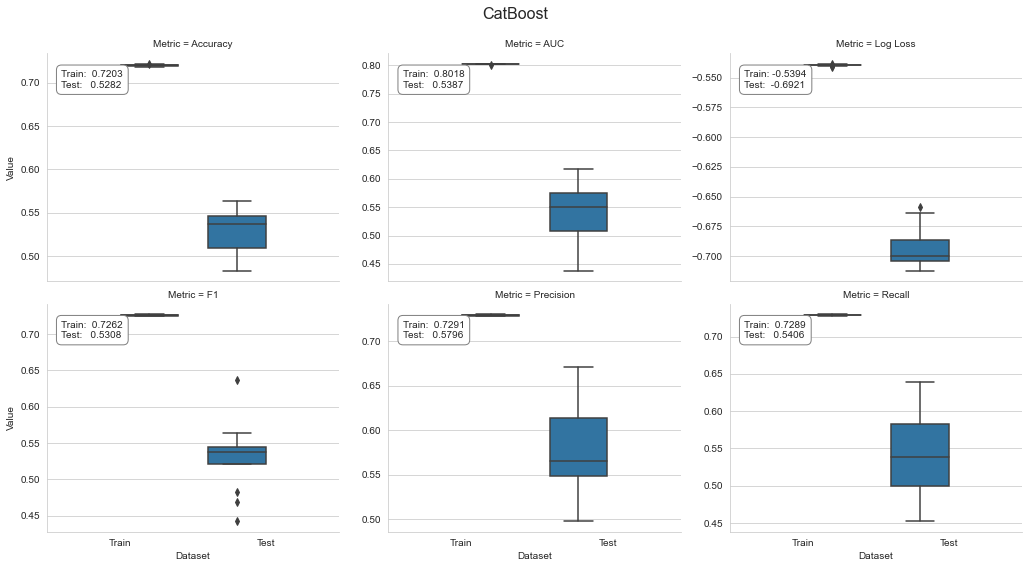

In [72]:
plot_result(cat_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

### GPU

#### Configure

In [73]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [74]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [75]:
algo = 'catboost_gpu'

In [76]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu,
                                               X=X_factors,
                                               fit_params={
                                                   'cat_features': cat_cols_idx},
                                               n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.024399
0:	learn: 0.6886496	total: 26.5ms	remaining: 26.5s
1:	learn: 0.6844048	total: 52.4ms	remaining: 26.1s
2:	learn: 0.6803455	total: 78.2ms	remaining: 26s
3:	learn: 0.6764824	total: 104ms	remaining: 25.8s
4:	learn: 0.6728021	total: 128ms	remaining: 25.6s
5:	learn: 0.6692984	total: 154ms	remaining: 25.4s
6:	learn: 0.6660266	total: 179ms	remaining: 25.4s
7:	learn: 0.6628542	total: 203ms	remaining: 25.1s
8:	learn: 0.6598707	total: 226ms	remaining: 24.9s
9:	learn: 0.6569937	total: 251ms	remaining: 24.9s
10:	learn: 0.6543085	total: 275ms	remaining: 24.7s
11:	learn: 0.6516864	total: 299ms	remaining: 24.6s
12:	learn: 0.6491966	total: 323ms	remaining: 24.5s
13:	learn: 0.6468083	total: 347ms	remaining: 24.5s
14:	learn: 0.6445763	total: 370ms	remaining: 24.3s
15:	learn: 0.6424386	total: 393ms	remaining: 24.2s
16:	learn: 0.6403282	total: 415ms	remaining: 24s
17:	learn: 0.6383904	total: 437ms	remaining: 23.9s
18:	learn: 0.6364536	total: 460ms	remaining: 23.8s
19:	learn: 0

164:	learn: 0.5892815	total: 4s	remaining: 20.2s
165:	learn: 0.5892583	total: 4.02s	remaining: 20.2s
166:	learn: 0.5892299	total: 4.04s	remaining: 20.2s
167:	learn: 0.5892037	total: 4.07s	remaining: 20.1s
168:	learn: 0.5891780	total: 4.09s	remaining: 20.1s
169:	learn: 0.5891543	total: 4.12s	remaining: 20.1s
170:	learn: 0.5891159	total: 4.14s	remaining: 20.1s
171:	learn: 0.5890997	total: 4.16s	remaining: 20s
172:	learn: 0.5890764	total: 4.19s	remaining: 20s
173:	learn: 0.5890544	total: 4.21s	remaining: 20s
174:	learn: 0.5890379	total: 4.24s	remaining: 20s
175:	learn: 0.5890175	total: 4.27s	remaining: 20s
176:	learn: 0.5889881	total: 4.29s	remaining: 20s
177:	learn: 0.5889647	total: 4.32s	remaining: 19.9s
178:	learn: 0.5889479	total: 4.34s	remaining: 19.9s
179:	learn: 0.5889293	total: 4.36s	remaining: 19.9s
180:	learn: 0.5889047	total: 4.38s	remaining: 19.8s
181:	learn: 0.5888760	total: 4.41s	remaining: 19.8s
182:	learn: 0.5888636	total: 4.43s	remaining: 19.8s
183:	learn: 0.5888440	total

323:	learn: 0.5864205	total: 7.96s	remaining: 16.6s
324:	learn: 0.5864132	total: 7.98s	remaining: 16.6s
325:	learn: 0.5863893	total: 8.01s	remaining: 16.6s
326:	learn: 0.5863808	total: 8.03s	remaining: 16.5s
327:	learn: 0.5863641	total: 8.05s	remaining: 16.5s
328:	learn: 0.5863564	total: 8.08s	remaining: 16.5s
329:	learn: 0.5863464	total: 8.1s	remaining: 16.4s
330:	learn: 0.5863266	total: 8.13s	remaining: 16.4s
331:	learn: 0.5863049	total: 8.15s	remaining: 16.4s
332:	learn: 0.5862817	total: 8.17s	remaining: 16.4s
333:	learn: 0.5862693	total: 8.2s	remaining: 16.3s
334:	learn: 0.5862547	total: 8.22s	remaining: 16.3s
335:	learn: 0.5862343	total: 8.24s	remaining: 16.3s
336:	learn: 0.5862309	total: 8.27s	remaining: 16.3s
337:	learn: 0.5862163	total: 8.29s	remaining: 16.2s
338:	learn: 0.5862022	total: 8.31s	remaining: 16.2s
339:	learn: 0.5861910	total: 8.34s	remaining: 16.2s
340:	learn: 0.5861803	total: 8.37s	remaining: 16.2s
341:	learn: 0.5861709	total: 8.4s	remaining: 16.2s
342:	learn: 0.5

483:	learn: 0.5845647	total: 11.9s	remaining: 12.6s
484:	learn: 0.5845614	total: 11.9s	remaining: 12.6s
485:	learn: 0.5845557	total: 11.9s	remaining: 12.6s
486:	learn: 0.5845441	total: 11.9s	remaining: 12.6s
487:	learn: 0.5845356	total: 11.9s	remaining: 12.5s
488:	learn: 0.5845256	total: 12s	remaining: 12.5s
489:	learn: 0.5845193	total: 12s	remaining: 12.5s
490:	learn: 0.5845144	total: 12s	remaining: 12.5s
491:	learn: 0.5845024	total: 12s	remaining: 12.4s
492:	learn: 0.5844992	total: 12.1s	remaining: 12.4s
493:	learn: 0.5844891	total: 12.1s	remaining: 12.4s
494:	learn: 0.5844713	total: 12.1s	remaining: 12.4s
495:	learn: 0.5844638	total: 12.1s	remaining: 12.3s
496:	learn: 0.5844543	total: 12.2s	remaining: 12.3s
497:	learn: 0.5844471	total: 12.2s	remaining: 12.3s
498:	learn: 0.5844419	total: 12.2s	remaining: 12.3s
499:	learn: 0.5844260	total: 12.2s	remaining: 12.2s
500:	learn: 0.5844208	total: 12.3s	remaining: 12.2s
501:	learn: 0.5844127	total: 12.3s	remaining: 12.2s
502:	learn: 0.584401

642:	learn: 0.5831982	total: 15.7s	remaining: 8.74s
643:	learn: 0.5831903	total: 15.8s	remaining: 8.71s
644:	learn: 0.5831842	total: 15.8s	remaining: 8.69s
645:	learn: 0.5831796	total: 15.8s	remaining: 8.66s
646:	learn: 0.5831679	total: 15.8s	remaining: 8.64s
647:	learn: 0.5831610	total: 15.9s	remaining: 8.61s
648:	learn: 0.5831516	total: 15.9s	remaining: 8.59s
649:	learn: 0.5831254	total: 15.9s	remaining: 8.56s
650:	learn: 0.5831222	total: 15.9s	remaining: 8.54s
651:	learn: 0.5831036	total: 16s	remaining: 8.52s
652:	learn: 0.5830995	total: 16s	remaining: 8.49s
653:	learn: 0.5830960	total: 16s	remaining: 8.47s
654:	learn: 0.5830929	total: 16s	remaining: 8.44s
655:	learn: 0.5830799	total: 16s	remaining: 8.41s
656:	learn: 0.5830671	total: 16.1s	remaining: 8.39s
657:	learn: 0.5830611	total: 16.1s	remaining: 8.36s
658:	learn: 0.5830530	total: 16.1s	remaining: 8.34s
659:	learn: 0.5830458	total: 16.1s	remaining: 8.31s
660:	learn: 0.5830430	total: 16.2s	remaining: 8.29s
661:	learn: 0.5830392	

804:	learn: 0.5820919	total: 19.6s	remaining: 4.75s
805:	learn: 0.5820897	total: 19.6s	remaining: 4.73s
806:	learn: 0.5820870	total: 19.7s	remaining: 4.7s
807:	learn: 0.5820796	total: 19.7s	remaining: 4.68s
808:	learn: 0.5820718	total: 19.7s	remaining: 4.65s
809:	learn: 0.5820692	total: 19.7s	remaining: 4.63s
810:	learn: 0.5820588	total: 19.8s	remaining: 4.6s
811:	learn: 0.5820505	total: 19.8s	remaining: 4.58s
812:	learn: 0.5820466	total: 19.8s	remaining: 4.55s
813:	learn: 0.5820438	total: 19.8s	remaining: 4.53s
814:	learn: 0.5820400	total: 19.9s	remaining: 4.5s
815:	learn: 0.5820323	total: 19.9s	remaining: 4.48s
816:	learn: 0.5820265	total: 19.9s	remaining: 4.46s
817:	learn: 0.5820141	total: 19.9s	remaining: 4.43s
818:	learn: 0.5820085	total: 19.9s	remaining: 4.41s
819:	learn: 0.5820018	total: 20s	remaining: 4.38s
820:	learn: 0.5819917	total: 20s	remaining: 4.36s
821:	learn: 0.5819858	total: 20s	remaining: 4.33s
822:	learn: 0.5819835	total: 20s	remaining: 4.31s
823:	learn: 0.5819769	t

964:	learn: 0.5810425	total: 23.5s	remaining: 851ms
965:	learn: 0.5810399	total: 23.5s	remaining: 827ms
966:	learn: 0.5810368	total: 23.5s	remaining: 802ms
967:	learn: 0.5810319	total: 23.5s	remaining: 778ms
968:	learn: 0.5810259	total: 23.6s	remaining: 754ms
969:	learn: 0.5810088	total: 23.6s	remaining: 729ms
970:	learn: 0.5809961	total: 23.6s	remaining: 705ms
971:	learn: 0.5809915	total: 23.6s	remaining: 681ms
972:	learn: 0.5809863	total: 23.7s	remaining: 656ms
973:	learn: 0.5809842	total: 23.7s	remaining: 632ms
974:	learn: 0.5809799	total: 23.7s	remaining: 608ms
975:	learn: 0.5809748	total: 23.7s	remaining: 583ms
976:	learn: 0.5809718	total: 23.7s	remaining: 559ms
977:	learn: 0.5809629	total: 23.8s	remaining: 535ms
978:	learn: 0.5809558	total: 23.8s	remaining: 510ms
979:	learn: 0.5809467	total: 23.8s	remaining: 486ms
980:	learn: 0.5809403	total: 23.8s	remaining: 462ms
981:	learn: 0.5809312	total: 23.9s	remaining: 438ms
982:	learn: 0.5809274	total: 23.9s	remaining: 413ms
983:	learn: 

131:	learn: 0.5907466	total: 3.19s	remaining: 21s
132:	learn: 0.5907067	total: 3.21s	remaining: 20.9s
133:	learn: 0.5906641	total: 3.24s	remaining: 20.9s
134:	learn: 0.5906186	total: 3.26s	remaining: 20.9s
135:	learn: 0.5905533	total: 3.29s	remaining: 20.9s
136:	learn: 0.5905087	total: 3.31s	remaining: 20.9s
137:	learn: 0.5904690	total: 3.34s	remaining: 20.9s
138:	learn: 0.5904318	total: 3.36s	remaining: 20.8s
139:	learn: 0.5904014	total: 3.39s	remaining: 20.8s
140:	learn: 0.5903751	total: 3.41s	remaining: 20.8s
141:	learn: 0.5903197	total: 3.44s	remaining: 20.8s
142:	learn: 0.5902870	total: 3.47s	remaining: 20.8s
143:	learn: 0.5902467	total: 3.49s	remaining: 20.8s
144:	learn: 0.5902114	total: 3.52s	remaining: 20.8s
145:	learn: 0.5901629	total: 3.54s	remaining: 20.7s
146:	learn: 0.5901303	total: 3.57s	remaining: 20.7s
147:	learn: 0.5901104	total: 3.59s	remaining: 20.7s
148:	learn: 0.5900953	total: 3.62s	remaining: 20.7s
149:	learn: 0.5900663	total: 3.65s	remaining: 20.7s
150:	learn: 0.

292:	learn: 0.5873899	total: 7.2s	remaining: 17.4s
293:	learn: 0.5873800	total: 7.22s	remaining: 17.3s
294:	learn: 0.5873677	total: 7.25s	remaining: 17.3s
295:	learn: 0.5873517	total: 7.27s	remaining: 17.3s
296:	learn: 0.5873448	total: 7.29s	remaining: 17.3s
297:	learn: 0.5873293	total: 7.32s	remaining: 17.2s
298:	learn: 0.5873061	total: 7.34s	remaining: 17.2s
299:	learn: 0.5872850	total: 7.36s	remaining: 17.2s
300:	learn: 0.5872731	total: 7.38s	remaining: 17.1s
301:	learn: 0.5872544	total: 7.41s	remaining: 17.1s
302:	learn: 0.5872425	total: 7.43s	remaining: 17.1s
303:	learn: 0.5872317	total: 7.46s	remaining: 17.1s
304:	learn: 0.5872239	total: 7.48s	remaining: 17s
305:	learn: 0.5872084	total: 7.5s	remaining: 17s
306:	learn: 0.5871791	total: 7.53s	remaining: 17s
307:	learn: 0.5871643	total: 7.55s	remaining: 17s
308:	learn: 0.5871440	total: 7.58s	remaining: 16.9s
309:	learn: 0.5871190	total: 7.6s	remaining: 16.9s
310:	learn: 0.5870962	total: 7.63s	remaining: 16.9s
311:	learn: 0.5870538	t

457:	learn: 0.5854900	total: 11.2s	remaining: 13.3s
458:	learn: 0.5854827	total: 11.2s	remaining: 13.2s
459:	learn: 0.5854757	total: 11.3s	remaining: 13.2s
460:	learn: 0.5854661	total: 11.3s	remaining: 13.2s
461:	learn: 0.5854577	total: 11.3s	remaining: 13.2s
462:	learn: 0.5854460	total: 11.3s	remaining: 13.2s
463:	learn: 0.5854322	total: 11.4s	remaining: 13.1s
464:	learn: 0.5854253	total: 11.4s	remaining: 13.1s
465:	learn: 0.5854151	total: 11.4s	remaining: 13.1s
466:	learn: 0.5854117	total: 11.4s	remaining: 13s
467:	learn: 0.5854071	total: 11.5s	remaining: 13s
468:	learn: 0.5853944	total: 11.5s	remaining: 13s
469:	learn: 0.5853847	total: 11.5s	remaining: 13s
470:	learn: 0.5853782	total: 11.5s	remaining: 12.9s
471:	learn: 0.5853709	total: 11.5s	remaining: 12.9s
472:	learn: 0.5853617	total: 11.6s	remaining: 12.9s
473:	learn: 0.5853497	total: 11.6s	remaining: 12.9s
474:	learn: 0.5853427	total: 11.6s	remaining: 12.8s
475:	learn: 0.5853312	total: 11.6s	remaining: 12.8s
476:	learn: 0.585318

618:	learn: 0.5841677	total: 15.1s	remaining: 9.28s
619:	learn: 0.5841619	total: 15.1s	remaining: 9.26s
620:	learn: 0.5841529	total: 15.1s	remaining: 9.23s
621:	learn: 0.5841477	total: 15.2s	remaining: 9.21s
622:	learn: 0.5841432	total: 15.2s	remaining: 9.18s
623:	learn: 0.5841402	total: 15.2s	remaining: 9.16s
624:	learn: 0.5841324	total: 15.2s	remaining: 9.13s
625:	learn: 0.5841126	total: 15.2s	remaining: 9.11s
626:	learn: 0.5841038	total: 15.3s	remaining: 9.08s
627:	learn: 0.5840935	total: 15.3s	remaining: 9.06s
628:	learn: 0.5840831	total: 15.3s	remaining: 9.04s
629:	learn: 0.5840761	total: 15.3s	remaining: 9.01s
630:	learn: 0.5840716	total: 15.4s	remaining: 8.98s
631:	learn: 0.5840660	total: 15.4s	remaining: 8.96s
632:	learn: 0.5840597	total: 15.4s	remaining: 8.94s
633:	learn: 0.5840491	total: 15.4s	remaining: 8.91s
634:	learn: 0.5840356	total: 15.5s	remaining: 8.88s
635:	learn: 0.5840304	total: 15.5s	remaining: 8.86s
636:	learn: 0.5840232	total: 15.5s	remaining: 8.84s
637:	learn: 

784:	learn: 0.5828552	total: 19.1s	remaining: 5.24s
785:	learn: 0.5828491	total: 19.2s	remaining: 5.22s
786:	learn: 0.5828416	total: 19.2s	remaining: 5.19s
787:	learn: 0.5828339	total: 19.2s	remaining: 5.17s
788:	learn: 0.5828198	total: 19.2s	remaining: 5.15s
789:	learn: 0.5828032	total: 19.3s	remaining: 5.12s
790:	learn: 0.5827975	total: 19.3s	remaining: 5.1s
791:	learn: 0.5827930	total: 19.3s	remaining: 5.07s
792:	learn: 0.5827865	total: 19.3s	remaining: 5.05s
793:	learn: 0.5827809	total: 19.4s	remaining: 5.02s
794:	learn: 0.5827737	total: 19.4s	remaining: 5s
795:	learn: 0.5827707	total: 19.4s	remaining: 4.97s
796:	learn: 0.5827661	total: 19.4s	remaining: 4.95s
797:	learn: 0.5827615	total: 19.5s	remaining: 4.93s
798:	learn: 0.5827503	total: 19.5s	remaining: 4.9s
799:	learn: 0.5827456	total: 19.5s	remaining: 4.88s
800:	learn: 0.5827431	total: 19.5s	remaining: 4.85s
801:	learn: 0.5827367	total: 19.6s	remaining: 4.83s
802:	learn: 0.5827346	total: 19.6s	remaining: 4.8s
803:	learn: 0.5827

943:	learn: 0.5818472	total: 23s	remaining: 1.36s
944:	learn: 0.5818409	total: 23s	remaining: 1.34s
945:	learn: 0.5818266	total: 23.1s	remaining: 1.32s
946:	learn: 0.5818228	total: 23.1s	remaining: 1.29s
947:	learn: 0.5818170	total: 23.1s	remaining: 1.27s
948:	learn: 0.5818155	total: 23.1s	remaining: 1.24s
949:	learn: 0.5818090	total: 23.2s	remaining: 1.22s
950:	learn: 0.5818020	total: 23.2s	remaining: 1.19s
951:	learn: 0.5818006	total: 23.2s	remaining: 1.17s
952:	learn: 0.5817976	total: 23.2s	remaining: 1.15s
953:	learn: 0.5817945	total: 23.3s	remaining: 1.12s
954:	learn: 0.5817920	total: 23.3s	remaining: 1.1s
955:	learn: 0.5817718	total: 23.3s	remaining: 1.07s
956:	learn: 0.5817689	total: 23.3s	remaining: 1.05s
957:	learn: 0.5817626	total: 23.4s	remaining: 1.02s
958:	learn: 0.5817584	total: 23.4s	remaining: 1s
959:	learn: 0.5817517	total: 23.4s	remaining: 976ms
960:	learn: 0.5817481	total: 23.4s	remaining: 951ms
961:	learn: 0.5817429	total: 23.5s	remaining: 927ms
962:	learn: 0.581735

107:	learn: 0.5919680	total: 2.54s	remaining: 21s
108:	learn: 0.5918823	total: 2.57s	remaining: 21s
109:	learn: 0.5918003	total: 2.6s	remaining: 21.1s
110:	learn: 0.5917292	total: 2.63s	remaining: 21s
111:	learn: 0.5916452	total: 2.65s	remaining: 21s
112:	learn: 0.5915784	total: 2.68s	remaining: 21s
113:	learn: 0.5915049	total: 2.7s	remaining: 21s
114:	learn: 0.5914363	total: 2.73s	remaining: 21s
115:	learn: 0.5913482	total: 2.76s	remaining: 21s
116:	learn: 0.5912771	total: 2.78s	remaining: 21s
117:	learn: 0.5912145	total: 2.81s	remaining: 21s
118:	learn: 0.5911394	total: 2.83s	remaining: 21s
119:	learn: 0.5910825	total: 2.86s	remaining: 21s
120:	learn: 0.5910334	total: 2.88s	remaining: 20.9s
121:	learn: 0.5909771	total: 2.91s	remaining: 20.9s
122:	learn: 0.5909208	total: 2.93s	remaining: 20.9s
123:	learn: 0.5908639	total: 2.96s	remaining: 20.9s
124:	learn: 0.5907866	total: 2.99s	remaining: 20.9s
125:	learn: 0.5907470	total: 3.02s	remaining: 20.9s
126:	learn: 0.5906986	total: 3.04s	rem

269:	learn: 0.5874177	total: 6.6s	remaining: 17.8s
270:	learn: 0.5874029	total: 6.62s	remaining: 17.8s
271:	learn: 0.5873873	total: 6.65s	remaining: 17.8s
272:	learn: 0.5873662	total: 6.67s	remaining: 17.8s
273:	learn: 0.5873532	total: 6.7s	remaining: 17.7s
274:	learn: 0.5873370	total: 6.72s	remaining: 17.7s
275:	learn: 0.5873280	total: 6.75s	remaining: 17.7s
276:	learn: 0.5873154	total: 6.78s	remaining: 17.7s
277:	learn: 0.5872680	total: 6.8s	remaining: 17.7s
278:	learn: 0.5872530	total: 6.82s	remaining: 17.6s
279:	learn: 0.5872303	total: 6.85s	remaining: 17.6s
280:	learn: 0.5872232	total: 6.88s	remaining: 17.6s
281:	learn: 0.5872152	total: 6.9s	remaining: 17.6s
282:	learn: 0.5872079	total: 6.92s	remaining: 17.5s
283:	learn: 0.5871913	total: 6.95s	remaining: 17.5s
284:	learn: 0.5871834	total: 6.97s	remaining: 17.5s
285:	learn: 0.5871665	total: 7s	remaining: 17.5s
286:	learn: 0.5871447	total: 7.02s	remaining: 17.5s
287:	learn: 0.5871336	total: 7.05s	remaining: 17.4s
288:	learn: 0.58711

432:	learn: 0.5853458	total: 10.7s	remaining: 14s
433:	learn: 0.5853394	total: 10.7s	remaining: 13.9s
434:	learn: 0.5853229	total: 10.7s	remaining: 13.9s
435:	learn: 0.5853149	total: 10.7s	remaining: 13.9s
436:	learn: 0.5853121	total: 10.8s	remaining: 13.9s
437:	learn: 0.5852942	total: 10.8s	remaining: 13.8s
438:	learn: 0.5852835	total: 10.8s	remaining: 13.8s
439:	learn: 0.5852770	total: 10.8s	remaining: 13.8s
440:	learn: 0.5852694	total: 10.8s	remaining: 13.7s
441:	learn: 0.5852582	total: 10.9s	remaining: 13.7s
442:	learn: 0.5852459	total: 10.9s	remaining: 13.7s
443:	learn: 0.5852380	total: 10.9s	remaining: 13.7s
444:	learn: 0.5852283	total: 10.9s	remaining: 13.7s
445:	learn: 0.5852165	total: 11s	remaining: 13.6s
446:	learn: 0.5852099	total: 11s	remaining: 13.6s
447:	learn: 0.5852007	total: 11s	remaining: 13.6s
448:	learn: 0.5851947	total: 11s	remaining: 13.5s
449:	learn: 0.5851857	total: 11.1s	remaining: 13.5s
450:	learn: 0.5851676	total: 11.1s	remaining: 13.5s
451:	learn: 0.5851567	

591:	learn: 0.5838947	total: 14.5s	remaining: 10s
592:	learn: 0.5838896	total: 14.5s	remaining: 9.97s
593:	learn: 0.5838834	total: 14.6s	remaining: 9.95s
594:	learn: 0.5838771	total: 14.6s	remaining: 9.92s
595:	learn: 0.5838636	total: 14.6s	remaining: 9.9s
596:	learn: 0.5838548	total: 14.6s	remaining: 9.88s
597:	learn: 0.5838420	total: 14.7s	remaining: 9.85s
598:	learn: 0.5838257	total: 14.7s	remaining: 9.83s
599:	learn: 0.5838202	total: 14.7s	remaining: 9.8s
600:	learn: 0.5838179	total: 14.7s	remaining: 9.78s
601:	learn: 0.5838148	total: 14.8s	remaining: 9.76s
602:	learn: 0.5838088	total: 14.8s	remaining: 9.73s
603:	learn: 0.5837886	total: 14.8s	remaining: 9.71s
604:	learn: 0.5837718	total: 14.8s	remaining: 9.68s
605:	learn: 0.5837672	total: 14.9s	remaining: 9.66s
606:	learn: 0.5837544	total: 14.9s	remaining: 9.64s
607:	learn: 0.5837439	total: 14.9s	remaining: 9.61s
608:	learn: 0.5837347	total: 14.9s	remaining: 9.58s
609:	learn: 0.5837288	total: 14.9s	remaining: 9.56s
610:	learn: 0.58

757:	learn: 0.5825783	total: 18.6s	remaining: 5.93s
758:	learn: 0.5825708	total: 18.6s	remaining: 5.9s
759:	learn: 0.5825651	total: 18.6s	remaining: 5.88s
760:	learn: 0.5825619	total: 18.6s	remaining: 5.85s
761:	learn: 0.5825600	total: 18.7s	remaining: 5.83s
762:	learn: 0.5825559	total: 18.7s	remaining: 5.8s
763:	learn: 0.5825500	total: 18.7s	remaining: 5.78s
764:	learn: 0.5825466	total: 18.7s	remaining: 5.75s
765:	learn: 0.5825436	total: 18.8s	remaining: 5.73s
766:	learn: 0.5825381	total: 18.8s	remaining: 5.71s
767:	learn: 0.5825343	total: 18.8s	remaining: 5.68s
768:	learn: 0.5825317	total: 18.8s	remaining: 5.66s
769:	learn: 0.5825251	total: 18.9s	remaining: 5.63s
770:	learn: 0.5825165	total: 18.9s	remaining: 5.61s
771:	learn: 0.5825052	total: 18.9s	remaining: 5.58s
772:	learn: 0.5825012	total: 18.9s	remaining: 5.56s
773:	learn: 0.5824992	total: 18.9s	remaining: 5.53s
774:	learn: 0.5824954	total: 19s	remaining: 5.51s
775:	learn: 0.5824932	total: 19s	remaining: 5.48s
776:	learn: 0.5824

917:	learn: 0.5816711	total: 22.4s	remaining: 2s
918:	learn: 0.5816675	total: 22.4s	remaining: 1.98s
919:	learn: 0.5816627	total: 22.5s	remaining: 1.95s
920:	learn: 0.5816586	total: 22.5s	remaining: 1.93s
921:	learn: 0.5816552	total: 22.5s	remaining: 1.9s
922:	learn: 0.5816513	total: 22.5s	remaining: 1.88s
923:	learn: 0.5816465	total: 22.6s	remaining: 1.85s
924:	learn: 0.5816387	total: 22.6s	remaining: 1.83s
925:	learn: 0.5816298	total: 22.6s	remaining: 1.81s
926:	learn: 0.5816236	total: 22.6s	remaining: 1.78s
927:	learn: 0.5816187	total: 22.6s	remaining: 1.76s
928:	learn: 0.5816149	total: 22.7s	remaining: 1.73s
929:	learn: 0.5816123	total: 22.7s	remaining: 1.71s
930:	learn: 0.5816065	total: 22.7s	remaining: 1.68s
931:	learn: 0.5816031	total: 22.7s	remaining: 1.66s
932:	learn: 0.5815999	total: 22.8s	remaining: 1.64s
933:	learn: 0.5815978	total: 22.8s	remaining: 1.61s
934:	learn: 0.5815919	total: 22.8s	remaining: 1.59s
935:	learn: 0.5815898	total: 22.8s	remaining: 1.56s
936:	learn: 0.58

80:	learn: 0.5953653	total: 1.89s	remaining: 21.4s
81:	learn: 0.5951657	total: 1.91s	remaining: 21.4s
82:	learn: 0.5949627	total: 1.94s	remaining: 21.4s
83:	learn: 0.5947571	total: 1.96s	remaining: 21.4s
84:	learn: 0.5945715	total: 1.99s	remaining: 21.4s
85:	learn: 0.5944019	total: 2.01s	remaining: 21.4s
86:	learn: 0.5942240	total: 2.03s	remaining: 21.4s
87:	learn: 0.5940542	total: 2.06s	remaining: 21.4s
88:	learn: 0.5939040	total: 2.09s	remaining: 21.4s
89:	learn: 0.5937518	total: 2.12s	remaining: 21.4s
90:	learn: 0.5935612	total: 2.14s	remaining: 21.4s
91:	learn: 0.5933986	total: 2.17s	remaining: 21.4s
92:	learn: 0.5932763	total: 2.19s	remaining: 21.4s
93:	learn: 0.5931588	total: 2.22s	remaining: 21.4s
94:	learn: 0.5930224	total: 2.25s	remaining: 21.4s
95:	learn: 0.5928943	total: 2.27s	remaining: 21.4s
96:	learn: 0.5927592	total: 2.29s	remaining: 21.4s
97:	learn: 0.5926402	total: 2.32s	remaining: 21.4s
98:	learn: 0.5925618	total: 2.35s	remaining: 21.4s
99:	learn: 0.5924408	total: 2.3

241:	learn: 0.5873284	total: 5.9s	remaining: 18.5s
242:	learn: 0.5873079	total: 5.93s	remaining: 18.5s
243:	learn: 0.5872927	total: 5.95s	remaining: 18.4s
244:	learn: 0.5872855	total: 5.97s	remaining: 18.4s
245:	learn: 0.5872604	total: 6s	remaining: 18.4s
246:	learn: 0.5872520	total: 6.03s	remaining: 18.4s
247:	learn: 0.5872354	total: 6.05s	remaining: 18.4s
248:	learn: 0.5872113	total: 6.08s	remaining: 18.3s
249:	learn: 0.5871895	total: 6.1s	remaining: 18.3s
250:	learn: 0.5871694	total: 6.13s	remaining: 18.3s
251:	learn: 0.5871576	total: 6.15s	remaining: 18.3s
252:	learn: 0.5871423	total: 6.17s	remaining: 18.2s
253:	learn: 0.5871237	total: 6.2s	remaining: 18.2s
254:	learn: 0.5871140	total: 6.22s	remaining: 18.2s
255:	learn: 0.5870835	total: 6.25s	remaining: 18.2s
256:	learn: 0.5870701	total: 6.27s	remaining: 18.1s
257:	learn: 0.5870593	total: 6.3s	remaining: 18.1s
258:	learn: 0.5870412	total: 6.33s	remaining: 18.1s
259:	learn: 0.5870283	total: 6.35s	remaining: 18.1s
260:	learn: 0.58701

407:	learn: 0.5851051	total: 9.99s	remaining: 14.5s
408:	learn: 0.5850898	total: 10s	remaining: 14.5s
409:	learn: 0.5850831	total: 10s	remaining: 14.4s
410:	learn: 0.5850594	total: 10.1s	remaining: 14.4s
411:	learn: 0.5850467	total: 10.1s	remaining: 14.4s
412:	learn: 0.5850392	total: 10.1s	remaining: 14.4s
413:	learn: 0.5850285	total: 10.1s	remaining: 14.3s
414:	learn: 0.5850124	total: 10.2s	remaining: 14.3s
415:	learn: 0.5849994	total: 10.2s	remaining: 14.3s
416:	learn: 0.5849837	total: 10.2s	remaining: 14.3s
417:	learn: 0.5849672	total: 10.2s	remaining: 14.2s
418:	learn: 0.5849596	total: 10.3s	remaining: 14.2s
419:	learn: 0.5849477	total: 10.3s	remaining: 14.2s
420:	learn: 0.5849404	total: 10.3s	remaining: 14.2s
421:	learn: 0.5849308	total: 10.3s	remaining: 14.1s
422:	learn: 0.5849186	total: 10.3s	remaining: 14.1s
423:	learn: 0.5849110	total: 10.4s	remaining: 14.1s
424:	learn: 0.5849004	total: 10.4s	remaining: 14.1s
425:	learn: 0.5848873	total: 10.4s	remaining: 14s
426:	learn: 0.5848

567:	learn: 0.5835547	total: 13.8s	remaining: 10.5s
568:	learn: 0.5835494	total: 13.9s	remaining: 10.5s
569:	learn: 0.5835459	total: 13.9s	remaining: 10.5s
570:	learn: 0.5835380	total: 13.9s	remaining: 10.5s
571:	learn: 0.5835312	total: 13.9s	remaining: 10.4s
572:	learn: 0.5835227	total: 14s	remaining: 10.4s
573:	learn: 0.5835179	total: 14s	remaining: 10.4s
574:	learn: 0.5835109	total: 14s	remaining: 10.4s
575:	learn: 0.5835037	total: 14s	remaining: 10.3s
576:	learn: 0.5834975	total: 14.1s	remaining: 10.3s
577:	learn: 0.5834900	total: 14.1s	remaining: 10.3s
578:	learn: 0.5834853	total: 14.1s	remaining: 10.3s
579:	learn: 0.5834764	total: 14.1s	remaining: 10.2s
580:	learn: 0.5834488	total: 14.2s	remaining: 10.2s
581:	learn: 0.5834421	total: 14.2s	remaining: 10.2s
582:	learn: 0.5834166	total: 14.2s	remaining: 10.2s
583:	learn: 0.5834089	total: 14.2s	remaining: 10.1s
584:	learn: 0.5833982	total: 14.3s	remaining: 10.1s
585:	learn: 0.5833887	total: 14.3s	remaining: 10.1s
586:	learn: 0.583379

734:	learn: 0.5821989	total: 17.9s	remaining: 6.46s
735:	learn: 0.5821906	total: 17.9s	remaining: 6.43s
736:	learn: 0.5821845	total: 18s	remaining: 6.41s
737:	learn: 0.5821770	total: 18s	remaining: 6.38s
738:	learn: 0.5821723	total: 18s	remaining: 6.36s
739:	learn: 0.5821611	total: 18s	remaining: 6.34s
740:	learn: 0.5821476	total: 18.1s	remaining: 6.31s
741:	learn: 0.5821425	total: 18.1s	remaining: 6.29s
742:	learn: 0.5821310	total: 18.1s	remaining: 6.26s
743:	learn: 0.5821192	total: 18.1s	remaining: 6.24s
744:	learn: 0.5821120	total: 18.2s	remaining: 6.21s
745:	learn: 0.5821061	total: 18.2s	remaining: 6.19s
746:	learn: 0.5820952	total: 18.2s	remaining: 6.17s
747:	learn: 0.5820882	total: 18.2s	remaining: 6.14s
748:	learn: 0.5820816	total: 18.3s	remaining: 6.12s
749:	learn: 0.5820708	total: 18.3s	remaining: 6.09s
750:	learn: 0.5820666	total: 18.3s	remaining: 6.07s
751:	learn: 0.5820624	total: 18.3s	remaining: 6.04s
752:	learn: 0.5820592	total: 18.4s	remaining: 6.02s
753:	learn: 0.582051

896:	learn: 0.5811162	total: 21.8s	remaining: 2.5s
897:	learn: 0.5811078	total: 21.8s	remaining: 2.47s
898:	learn: 0.5811025	total: 21.8s	remaining: 2.45s
899:	learn: 0.5810877	total: 21.8s	remaining: 2.42s
900:	learn: 0.5810831	total: 21.9s	remaining: 2.4s
901:	learn: 0.5810757	total: 21.9s	remaining: 2.38s
902:	learn: 0.5810710	total: 21.9s	remaining: 2.35s
903:	learn: 0.5810691	total: 21.9s	remaining: 2.33s
904:	learn: 0.5810646	total: 22s	remaining: 2.3s
905:	learn: 0.5810563	total: 22s	remaining: 2.28s
906:	learn: 0.5810511	total: 22s	remaining: 2.26s
907:	learn: 0.5810466	total: 22s	remaining: 2.23s
908:	learn: 0.5810341	total: 22.1s	remaining: 2.21s
909:	learn: 0.5810298	total: 22.1s	remaining: 2.18s
910:	learn: 0.5810206	total: 22.1s	remaining: 2.16s
911:	learn: 0.5810142	total: 22.1s	remaining: 2.13s
912:	learn: 0.5810123	total: 22.1s	remaining: 2.11s
913:	learn: 0.5810038	total: 22.2s	remaining: 2.09s
914:	learn: 0.5809958	total: 22.2s	remaining: 2.06s
915:	learn: 0.5809942	t

56:	learn: 0.6017821	total: 1.29s	remaining: 21.3s
57:	learn: 0.6014074	total: 1.31s	remaining: 21.3s
58:	learn: 0.6010341	total: 1.33s	remaining: 21.2s
59:	learn: 0.6006787	total: 1.35s	remaining: 21.2s
60:	learn: 0.6003419	total: 1.37s	remaining: 21.2s
61:	learn: 0.6000488	total: 1.4s	remaining: 21.1s
62:	learn: 0.5997167	total: 1.42s	remaining: 21.1s
63:	learn: 0.5994138	total: 1.44s	remaining: 21.1s
64:	learn: 0.5991376	total: 1.46s	remaining: 21.1s
65:	learn: 0.5988372	total: 1.49s	remaining: 21s
66:	learn: 0.5985836	total: 1.51s	remaining: 21s
67:	learn: 0.5983107	total: 1.53s	remaining: 21s
68:	learn: 0.5979791	total: 1.55s	remaining: 21s
69:	learn: 0.5977485	total: 1.58s	remaining: 20.9s
70:	learn: 0.5975128	total: 1.6s	remaining: 20.9s
71:	learn: 0.5972778	total: 1.62s	remaining: 20.9s
72:	learn: 0.5970773	total: 1.64s	remaining: 20.9s
73:	learn: 0.5967863	total: 1.67s	remaining: 20.9s
74:	learn: 0.5965312	total: 1.69s	remaining: 20.9s
75:	learn: 0.5963425	total: 1.71s	remaini

219:	learn: 0.5876856	total: 5.29s	remaining: 18.7s
220:	learn: 0.5876713	total: 5.31s	remaining: 18.7s
221:	learn: 0.5876567	total: 5.33s	remaining: 18.7s
222:	learn: 0.5876433	total: 5.35s	remaining: 18.7s
223:	learn: 0.5876360	total: 5.38s	remaining: 18.6s
224:	learn: 0.5876216	total: 5.4s	remaining: 18.6s
225:	learn: 0.5875980	total: 5.43s	remaining: 18.6s
226:	learn: 0.5875832	total: 5.45s	remaining: 18.6s
227:	learn: 0.5875636	total: 5.47s	remaining: 18.5s
228:	learn: 0.5875406	total: 5.5s	remaining: 18.5s
229:	learn: 0.5875273	total: 5.52s	remaining: 18.5s
230:	learn: 0.5875135	total: 5.55s	remaining: 18.5s
231:	learn: 0.5875030	total: 5.57s	remaining: 18.4s
232:	learn: 0.5874806	total: 5.59s	remaining: 18.4s
233:	learn: 0.5874477	total: 5.62s	remaining: 18.4s
234:	learn: 0.5874328	total: 5.64s	remaining: 18.4s
235:	learn: 0.5874174	total: 5.67s	remaining: 18.3s
236:	learn: 0.5873991	total: 5.69s	remaining: 18.3s
237:	learn: 0.5873712	total: 5.71s	remaining: 18.3s
238:	learn: 0.

384:	learn: 0.5852142	total: 9.36s	remaining: 14.9s
385:	learn: 0.5852034	total: 9.38s	remaining: 14.9s
386:	learn: 0.5851965	total: 9.4s	remaining: 14.9s
387:	learn: 0.5851852	total: 9.43s	remaining: 14.9s
388:	learn: 0.5851786	total: 9.45s	remaining: 14.8s
389:	learn: 0.5851722	total: 9.47s	remaining: 14.8s
390:	learn: 0.5851584	total: 9.49s	remaining: 14.8s
391:	learn: 0.5851510	total: 9.52s	remaining: 14.8s
392:	learn: 0.5851375	total: 9.54s	remaining: 14.7s
393:	learn: 0.5851253	total: 9.56s	remaining: 14.7s
394:	learn: 0.5851110	total: 9.59s	remaining: 14.7s
395:	learn: 0.5850937	total: 9.61s	remaining: 14.7s
396:	learn: 0.5850818	total: 9.63s	remaining: 14.6s
397:	learn: 0.5850757	total: 9.66s	remaining: 14.6s
398:	learn: 0.5850642	total: 9.68s	remaining: 14.6s
399:	learn: 0.5850568	total: 9.71s	remaining: 14.6s
400:	learn: 0.5850468	total: 9.73s	remaining: 14.5s
401:	learn: 0.5850309	total: 9.75s	remaining: 14.5s
402:	learn: 0.5850241	total: 9.77s	remaining: 14.5s
403:	learn: 0

545:	learn: 0.5836146	total: 13.2s	remaining: 11s
546:	learn: 0.5836109	total: 13.2s	remaining: 11s
547:	learn: 0.5836036	total: 13.3s	remaining: 10.9s
548:	learn: 0.5835938	total: 13.3s	remaining: 10.9s
549:	learn: 0.5835893	total: 13.3s	remaining: 10.9s
550:	learn: 0.5835836	total: 13.3s	remaining: 10.9s
551:	learn: 0.5835802	total: 13.3s	remaining: 10.8s
552:	learn: 0.5835748	total: 13.4s	remaining: 10.8s
553:	learn: 0.5835698	total: 13.4s	remaining: 10.8s
554:	learn: 0.5835622	total: 13.4s	remaining: 10.8s
555:	learn: 0.5835521	total: 13.4s	remaining: 10.7s
556:	learn: 0.5835357	total: 13.5s	remaining: 10.7s
557:	learn: 0.5835246	total: 13.5s	remaining: 10.7s
558:	learn: 0.5835182	total: 13.5s	remaining: 10.7s
559:	learn: 0.5834987	total: 13.6s	remaining: 10.6s
560:	learn: 0.5834926	total: 13.6s	remaining: 10.6s
561:	learn: 0.5834761	total: 13.6s	remaining: 10.6s
562:	learn: 0.5834660	total: 13.6s	remaining: 10.6s
563:	learn: 0.5834525	total: 13.6s	remaining: 10.5s
564:	learn: 0.58

704:	learn: 0.5822642	total: 17.1s	remaining: 7.14s
705:	learn: 0.5822534	total: 17.1s	remaining: 7.11s
706:	learn: 0.5822454	total: 17.1s	remaining: 7.09s
707:	learn: 0.5822404	total: 17.1s	remaining: 7.07s
708:	learn: 0.5822371	total: 17.2s	remaining: 7.04s
709:	learn: 0.5822253	total: 17.2s	remaining: 7.01s
710:	learn: 0.5822179	total: 17.2s	remaining: 6.99s
711:	learn: 0.5822135	total: 17.2s	remaining: 6.97s
712:	learn: 0.5822068	total: 17.3s	remaining: 6.94s
713:	learn: 0.5822040	total: 17.3s	remaining: 6.92s
714:	learn: 0.5821989	total: 17.3s	remaining: 6.89s
715:	learn: 0.5821867	total: 17.3s	remaining: 6.87s
716:	learn: 0.5821748	total: 17.3s	remaining: 6.85s
717:	learn: 0.5821668	total: 17.4s	remaining: 6.82s
718:	learn: 0.5821487	total: 17.4s	remaining: 6.8s
719:	learn: 0.5821382	total: 17.4s	remaining: 6.77s
720:	learn: 0.5821349	total: 17.4s	remaining: 6.75s
721:	learn: 0.5821284	total: 17.5s	remaining: 6.72s
722:	learn: 0.5821150	total: 17.5s	remaining: 6.7s
723:	learn: 0.

867:	learn: 0.5812077	total: 20.9s	remaining: 3.18s
868:	learn: 0.5811940	total: 20.9s	remaining: 3.15s
869:	learn: 0.5811865	total: 21s	remaining: 3.13s
870:	learn: 0.5811812	total: 21s	remaining: 3.11s
871:	learn: 0.5811768	total: 21s	remaining: 3.08s
872:	learn: 0.5811711	total: 21s	remaining: 3.06s
873:	learn: 0.5811679	total: 21s	remaining: 3.03s
874:	learn: 0.5811567	total: 21.1s	remaining: 3.01s
875:	learn: 0.5811530	total: 21.1s	remaining: 2.99s
876:	learn: 0.5811494	total: 21.1s	remaining: 2.96s
877:	learn: 0.5811438	total: 21.1s	remaining: 2.94s
878:	learn: 0.5811395	total: 21.2s	remaining: 2.91s
879:	learn: 0.5811366	total: 21.2s	remaining: 2.89s
880:	learn: 0.5811347	total: 21.2s	remaining: 2.87s
881:	learn: 0.5811313	total: 21.2s	remaining: 2.84s
882:	learn: 0.5811269	total: 21.3s	remaining: 2.82s
883:	learn: 0.5811253	total: 21.3s	remaining: 2.79s
884:	learn: 0.5811142	total: 21.3s	remaining: 2.77s
885:	learn: 0.5811097	total: 21.3s	remaining: 2.74s
886:	learn: 0.5811082	

27:	learn: 0.6221598	total: 646ms	remaining: 22.4s
28:	learn: 0.6209552	total: 669ms	remaining: 22.4s
29:	learn: 0.6197741	total: 691ms	remaining: 22.4s
30:	learn: 0.6186869	total: 714ms	remaining: 22.3s
31:	learn: 0.6175896	total: 736ms	remaining: 22.3s
32:	learn: 0.6165658	total: 760ms	remaining: 22.3s
33:	learn: 0.6156260	total: 782ms	remaining: 22.2s
34:	learn: 0.6147140	total: 804ms	remaining: 22.2s
35:	learn: 0.6137635	total: 827ms	remaining: 22.1s
36:	learn: 0.6129369	total: 851ms	remaining: 22.1s
37:	learn: 0.6120989	total: 873ms	remaining: 22.1s
38:	learn: 0.6112734	total: 895ms	remaining: 22s
39:	learn: 0.6104944	total: 918ms	remaining: 22s
40:	learn: 0.6097591	total: 941ms	remaining: 22s
41:	learn: 0.6090891	total: 964ms	remaining: 22s
42:	learn: 0.6083953	total: 987ms	remaining: 22s
43:	learn: 0.6077315	total: 1.01s	remaining: 21.9s
44:	learn: 0.6070928	total: 1.03s	remaining: 21.9s
45:	learn: 0.6064967	total: 1.05s	remaining: 21.8s
46:	learn: 0.6059516	total: 1.07s	remaini

195:	learn: 0.5877170	total: 4.74s	remaining: 19.4s
196:	learn: 0.5876813	total: 4.76s	remaining: 19.4s
197:	learn: 0.5876637	total: 4.79s	remaining: 19.4s
198:	learn: 0.5876285	total: 4.81s	remaining: 19.4s
199:	learn: 0.5876103	total: 4.84s	remaining: 19.3s
200:	learn: 0.5875920	total: 4.86s	remaining: 19.3s
201:	learn: 0.5875674	total: 4.88s	remaining: 19.3s
202:	learn: 0.5875489	total: 4.91s	remaining: 19.3s
203:	learn: 0.5875221	total: 4.93s	remaining: 19.2s
204:	learn: 0.5875107	total: 4.96s	remaining: 19.2s
205:	learn: 0.5875012	total: 4.98s	remaining: 19.2s
206:	learn: 0.5874890	total: 5s	remaining: 19.2s
207:	learn: 0.5874573	total: 5.03s	remaining: 19.1s
208:	learn: 0.5874348	total: 5.05s	remaining: 19.1s
209:	learn: 0.5874209	total: 5.08s	remaining: 19.1s
210:	learn: 0.5873972	total: 5.11s	remaining: 19.1s
211:	learn: 0.5873691	total: 5.13s	remaining: 19.1s
212:	learn: 0.5873474	total: 5.15s	remaining: 19s
213:	learn: 0.5873244	total: 5.17s	remaining: 19s
214:	learn: 0.58731

362:	learn: 0.5851021	total: 8.8s	remaining: 15.5s
363:	learn: 0.5850921	total: 8.83s	remaining: 15.4s
364:	learn: 0.5850867	total: 8.86s	remaining: 15.4s
365:	learn: 0.5850807	total: 8.88s	remaining: 15.4s
366:	learn: 0.5850691	total: 8.9s	remaining: 15.3s
367:	learn: 0.5850597	total: 8.93s	remaining: 15.3s
368:	learn: 0.5850488	total: 8.96s	remaining: 15.3s
369:	learn: 0.5850431	total: 8.98s	remaining: 15.3s
370:	learn: 0.5850320	total: 9s	remaining: 15.3s
371:	learn: 0.5850273	total: 9.02s	remaining: 15.2s
372:	learn: 0.5850196	total: 9.04s	remaining: 15.2s
373:	learn: 0.5850127	total: 9.07s	remaining: 15.2s
374:	learn: 0.5849989	total: 9.09s	remaining: 15.2s
375:	learn: 0.5849839	total: 9.11s	remaining: 15.1s
376:	learn: 0.5849745	total: 9.14s	remaining: 15.1s
377:	learn: 0.5849685	total: 9.16s	remaining: 15.1s
378:	learn: 0.5849631	total: 9.19s	remaining: 15.1s
379:	learn: 0.5849477	total: 9.21s	remaining: 15s
380:	learn: 0.5849401	total: 9.23s	remaining: 15s
381:	learn: 0.5849255

521:	learn: 0.5834900	total: 12.6s	remaining: 11.6s
522:	learn: 0.5834873	total: 12.7s	remaining: 11.6s
523:	learn: 0.5834729	total: 12.7s	remaining: 11.5s
524:	learn: 0.5834679	total: 12.7s	remaining: 11.5s
525:	learn: 0.5834616	total: 12.7s	remaining: 11.5s
526:	learn: 0.5834538	total: 12.8s	remaining: 11.5s
527:	learn: 0.5834476	total: 12.8s	remaining: 11.4s
528:	learn: 0.5834316	total: 12.8s	remaining: 11.4s
529:	learn: 0.5834246	total: 12.8s	remaining: 11.4s
530:	learn: 0.5834080	total: 12.9s	remaining: 11.4s
531:	learn: 0.5834032	total: 12.9s	remaining: 11.3s
532:	learn: 0.5833924	total: 12.9s	remaining: 11.3s
533:	learn: 0.5833879	total: 12.9s	remaining: 11.3s
534:	learn: 0.5833749	total: 12.9s	remaining: 11.3s
535:	learn: 0.5833680	total: 13s	remaining: 11.2s
536:	learn: 0.5833604	total: 13s	remaining: 11.2s
537:	learn: 0.5833444	total: 13s	remaining: 11.2s
538:	learn: 0.5833327	total: 13s	remaining: 11.2s
539:	learn: 0.5833270	total: 13.1s	remaining: 11.1s
540:	learn: 0.583320

682:	learn: 0.5822074	total: 16.5s	remaining: 7.66s
683:	learn: 0.5822038	total: 16.5s	remaining: 7.63s
684:	learn: 0.5821959	total: 16.5s	remaining: 7.61s
685:	learn: 0.5821889	total: 16.6s	remaining: 7.59s
686:	learn: 0.5821819	total: 16.6s	remaining: 7.56s
687:	learn: 0.5821694	total: 16.6s	remaining: 7.54s
688:	learn: 0.5821485	total: 16.6s	remaining: 7.51s
689:	learn: 0.5821420	total: 16.7s	remaining: 7.49s
690:	learn: 0.5821260	total: 16.7s	remaining: 7.47s
691:	learn: 0.5821190	total: 16.7s	remaining: 7.44s
692:	learn: 0.5821120	total: 16.7s	remaining: 7.42s
693:	learn: 0.5820995	total: 16.8s	remaining: 7.39s
694:	learn: 0.5820943	total: 16.8s	remaining: 7.37s
695:	learn: 0.5820897	total: 16.8s	remaining: 7.35s
696:	learn: 0.5820831	total: 16.8s	remaining: 7.32s
697:	learn: 0.5820810	total: 16.9s	remaining: 7.3s
698:	learn: 0.5820567	total: 16.9s	remaining: 7.27s
699:	learn: 0.5820494	total: 16.9s	remaining: 7.25s
700:	learn: 0.5820444	total: 16.9s	remaining: 7.22s
701:	learn: 0

842:	learn: 0.5810970	total: 20.4s	remaining: 3.79s
843:	learn: 0.5810921	total: 20.4s	remaining: 3.77s
844:	learn: 0.5810860	total: 20.4s	remaining: 3.74s
845:	learn: 0.5810803	total: 20.4s	remaining: 3.72s
846:	learn: 0.5810728	total: 20.4s	remaining: 3.69s
847:	learn: 0.5810668	total: 20.5s	remaining: 3.67s
848:	learn: 0.5810605	total: 20.5s	remaining: 3.65s
849:	learn: 0.5810519	total: 20.5s	remaining: 3.62s
850:	learn: 0.5810453	total: 20.5s	remaining: 3.6s
851:	learn: 0.5810432	total: 20.6s	remaining: 3.57s
852:	learn: 0.5810366	total: 20.6s	remaining: 3.55s
853:	learn: 0.5810324	total: 20.6s	remaining: 3.52s
854:	learn: 0.5810278	total: 20.6s	remaining: 3.5s
855:	learn: 0.5810261	total: 20.7s	remaining: 3.47s
856:	learn: 0.5810200	total: 20.7s	remaining: 3.45s
857:	learn: 0.5810159	total: 20.7s	remaining: 3.43s
858:	learn: 0.5810074	total: 20.7s	remaining: 3.4s
859:	learn: 0.5809987	total: 20.8s	remaining: 3.38s
860:	learn: 0.5809940	total: 20.8s	remaining: 3.35s
861:	learn: 0.5

0:	learn: 0.6886814	total: 25.1ms	remaining: 25s
1:	learn: 0.6844256	total: 48.7ms	remaining: 24.3s
2:	learn: 0.6803756	total: 71.9ms	remaining: 23.9s
3:	learn: 0.6764824	total: 94.5ms	remaining: 23.5s
4:	learn: 0.6728137	total: 117ms	remaining: 23.4s
5:	learn: 0.6692909	total: 140ms	remaining: 23.2s
6:	learn: 0.6659821	total: 163ms	remaining: 23.1s
7:	learn: 0.6627559	total: 186ms	remaining: 23.1s
8:	learn: 0.6596842	total: 209ms	remaining: 23s
9:	learn: 0.6567979	total: 232ms	remaining: 23s
10:	learn: 0.6541110	total: 254ms	remaining: 22.8s
11:	learn: 0.6515145	total: 276ms	remaining: 22.7s
12:	learn: 0.6490073	total: 299ms	remaining: 22.7s
13:	learn: 0.6466229	total: 322ms	remaining: 22.7s
14:	learn: 0.6443567	total: 345ms	remaining: 22.7s
15:	learn: 0.6421272	total: 368ms	remaining: 22.6s
16:	learn: 0.6400142	total: 390ms	remaining: 22.6s
17:	learn: 0.6380342	total: 413ms	remaining: 22.5s
18:	learn: 0.6360942	total: 435ms	remaining: 22.5s
19:	learn: 0.6343110	total: 459ms	remaining

168:	learn: 0.5886655	total: 4.04s	remaining: 19.9s
169:	learn: 0.5886414	total: 4.07s	remaining: 19.9s
170:	learn: 0.5886282	total: 4.09s	remaining: 19.8s
171:	learn: 0.5886116	total: 4.12s	remaining: 19.8s
172:	learn: 0.5885743	total: 4.14s	remaining: 19.8s
173:	learn: 0.5885555	total: 4.17s	remaining: 19.8s
174:	learn: 0.5885339	total: 4.2s	remaining: 19.8s
175:	learn: 0.5885174	total: 4.22s	remaining: 19.8s
176:	learn: 0.5884968	total: 4.25s	remaining: 19.7s
177:	learn: 0.5884797	total: 4.27s	remaining: 19.7s
178:	learn: 0.5884547	total: 4.29s	remaining: 19.7s
179:	learn: 0.5884312	total: 4.32s	remaining: 19.7s
180:	learn: 0.5884074	total: 4.34s	remaining: 19.6s
181:	learn: 0.5883851	total: 4.37s	remaining: 19.6s
182:	learn: 0.5883460	total: 4.39s	remaining: 19.6s
183:	learn: 0.5883254	total: 4.42s	remaining: 19.6s
184:	learn: 0.5882975	total: 4.45s	remaining: 19.6s
185:	learn: 0.5882788	total: 4.47s	remaining: 19.6s
186:	learn: 0.5882565	total: 4.5s	remaining: 19.5s
187:	learn: 0.

332:	learn: 0.5858512	total: 8.05s	remaining: 16.1s
333:	learn: 0.5858434	total: 8.08s	remaining: 16.1s
334:	learn: 0.5858363	total: 8.1s	remaining: 16.1s
335:	learn: 0.5858269	total: 8.13s	remaining: 16.1s
336:	learn: 0.5858194	total: 8.15s	remaining: 16s
337:	learn: 0.5858000	total: 8.18s	remaining: 16s
338:	learn: 0.5857777	total: 8.2s	remaining: 16s
339:	learn: 0.5857703	total: 8.23s	remaining: 16s
340:	learn: 0.5857615	total: 8.25s	remaining: 15.9s
341:	learn: 0.5857492	total: 8.27s	remaining: 15.9s
342:	learn: 0.5857391	total: 8.29s	remaining: 15.9s
343:	learn: 0.5857292	total: 8.32s	remaining: 15.9s
344:	learn: 0.5857174	total: 8.34s	remaining: 15.8s
345:	learn: 0.5857058	total: 8.36s	remaining: 15.8s
346:	learn: 0.5856937	total: 8.39s	remaining: 15.8s
347:	learn: 0.5856888	total: 8.41s	remaining: 15.8s
348:	learn: 0.5856833	total: 8.44s	remaining: 15.7s
349:	learn: 0.5856789	total: 8.46s	remaining: 15.7s
350:	learn: 0.5856695	total: 8.49s	remaining: 15.7s
351:	learn: 0.5856602	

495:	learn: 0.5841579	total: 11.9s	remaining: 12.1s
496:	learn: 0.5841464	total: 12s	remaining: 12.1s
497:	learn: 0.5841336	total: 12s	remaining: 12.1s
498:	learn: 0.5841230	total: 12s	remaining: 12.1s
499:	learn: 0.5841139	total: 12s	remaining: 12s
500:	learn: 0.5841059	total: 12.1s	remaining: 12s
501:	learn: 0.5841004	total: 12.1s	remaining: 12s
502:	learn: 0.5840965	total: 12.1s	remaining: 12s
503:	learn: 0.5840885	total: 12.1s	remaining: 11.9s
504:	learn: 0.5840737	total: 12.2s	remaining: 11.9s
505:	learn: 0.5840675	total: 12.2s	remaining: 11.9s
506:	learn: 0.5840607	total: 12.2s	remaining: 11.9s
507:	learn: 0.5840517	total: 12.2s	remaining: 11.8s
508:	learn: 0.5840403	total: 12.3s	remaining: 11.8s
509:	learn: 0.5840371	total: 12.3s	remaining: 11.8s
510:	learn: 0.5840233	total: 12.3s	remaining: 11.8s
511:	learn: 0.5840189	total: 12.3s	remaining: 11.7s
512:	learn: 0.5840135	total: 12.3s	remaining: 11.7s
513:	learn: 0.5840015	total: 12.4s	remaining: 11.7s
514:	learn: 0.5839958	total:

657:	learn: 0.5828666	total: 15.8s	remaining: 8.2s
658:	learn: 0.5828607	total: 15.8s	remaining: 8.18s
659:	learn: 0.5828556	total: 15.8s	remaining: 8.15s
660:	learn: 0.5828529	total: 15.9s	remaining: 8.13s
661:	learn: 0.5828450	total: 15.9s	remaining: 8.11s
662:	learn: 0.5828404	total: 15.9s	remaining: 8.08s
663:	learn: 0.5828376	total: 15.9s	remaining: 8.06s
664:	learn: 0.5828252	total: 15.9s	remaining: 8.03s
665:	learn: 0.5828219	total: 16s	remaining: 8.01s
666:	learn: 0.5828198	total: 16s	remaining: 7.99s
667:	learn: 0.5828146	total: 16s	remaining: 7.96s
668:	learn: 0.5828113	total: 16s	remaining: 7.94s
669:	learn: 0.5828078	total: 16.1s	remaining: 7.91s
670:	learn: 0.5827969	total: 16.1s	remaining: 7.89s
671:	learn: 0.5827903	total: 16.1s	remaining: 7.86s
672:	learn: 0.5827808	total: 16.1s	remaining: 7.84s
673:	learn: 0.5827628	total: 16.2s	remaining: 7.82s
674:	learn: 0.5827542	total: 16.2s	remaining: 7.79s
675:	learn: 0.5827401	total: 16.2s	remaining: 7.77s
676:	learn: 0.5827292

824:	learn: 0.5817335	total: 19.8s	remaining: 4.2s
825:	learn: 0.5817248	total: 19.8s	remaining: 4.17s
826:	learn: 0.5817170	total: 19.8s	remaining: 4.15s
827:	learn: 0.5817115	total: 19.9s	remaining: 4.12s
828:	learn: 0.5817050	total: 19.9s	remaining: 4.1s
829:	learn: 0.5817019	total: 19.9s	remaining: 4.08s
830:	learn: 0.5816977	total: 19.9s	remaining: 4.05s
831:	learn: 0.5816816	total: 19.9s	remaining: 4.03s
832:	learn: 0.5816791	total: 20s	remaining: 4s
833:	learn: 0.5816723	total: 20s	remaining: 3.98s
834:	learn: 0.5816658	total: 20s	remaining: 3.96s
835:	learn: 0.5816589	total: 20s	remaining: 3.93s
836:	learn: 0.5816515	total: 20.1s	remaining: 3.91s
837:	learn: 0.5816462	total: 20.1s	remaining: 3.88s
838:	learn: 0.5816316	total: 20.1s	remaining: 3.86s
839:	learn: 0.5816283	total: 20.1s	remaining: 3.83s
840:	learn: 0.5816227	total: 20.2s	remaining: 3.81s
841:	learn: 0.5816079	total: 20.2s	remaining: 3.79s
842:	learn: 0.5816018	total: 20.2s	remaining: 3.76s
843:	learn: 0.5815989	tot

986:	learn: 0.5806852	total: 23.6s	remaining: 311ms
987:	learn: 0.5806821	total: 23.6s	remaining: 287ms
988:	learn: 0.5806752	total: 23.6s	remaining: 263ms
989:	learn: 0.5806697	total: 23.7s	remaining: 239ms
990:	learn: 0.5806657	total: 23.7s	remaining: 215ms
991:	learn: 0.5806620	total: 23.7s	remaining: 191ms
992:	learn: 0.5806580	total: 23.7s	remaining: 167ms
993:	learn: 0.5806563	total: 23.7s	remaining: 143ms
994:	learn: 0.5806530	total: 23.8s	remaining: 119ms
995:	learn: 0.5806428	total: 23.8s	remaining: 95.5ms
996:	learn: 0.5806375	total: 23.8s	remaining: 71.7ms
997:	learn: 0.5806351	total: 23.8s	remaining: 47.8ms
998:	learn: 0.5806281	total: 23.9s	remaining: 23.9ms
999:	learn: 0.5806261	total: 23.9s	remaining: 0us
Learning rate set to 0.024448
0:	learn: 0.6886196	total: 25.3ms	remaining: 25.3s
1:	learn: 0.6843782	total: 50.3ms	remaining: 25.1s
2:	learn: 0.6803140	total: 75.5ms	remaining: 25.1s
3:	learn: 0.6764035	total: 100ms	remaining: 24.9s
4:	learn: 0.6726920	total: 126ms	rema

151:	learn: 0.5887673	total: 3.62s	remaining: 20.2s
152:	learn: 0.5887340	total: 3.65s	remaining: 20.2s
153:	learn: 0.5886931	total: 3.67s	remaining: 20.2s
154:	learn: 0.5886495	total: 3.69s	remaining: 20.1s
155:	learn: 0.5886325	total: 3.72s	remaining: 20.1s
156:	learn: 0.5886099	total: 3.75s	remaining: 20.1s
157:	learn: 0.5885684	total: 3.77s	remaining: 20.1s
158:	learn: 0.5885473	total: 3.79s	remaining: 20.1s
159:	learn: 0.5885250	total: 3.82s	remaining: 20s
160:	learn: 0.5885013	total: 3.84s	remaining: 20s
161:	learn: 0.5884780	total: 3.87s	remaining: 20s
162:	learn: 0.5884526	total: 3.89s	remaining: 20s
163:	learn: 0.5884288	total: 3.92s	remaining: 20s
164:	learn: 0.5884056	total: 3.94s	remaining: 20s
165:	learn: 0.5883783	total: 3.97s	remaining: 20s
166:	learn: 0.5883547	total: 4s	remaining: 19.9s
167:	learn: 0.5883342	total: 4.02s	remaining: 19.9s
168:	learn: 0.5883144	total: 4.04s	remaining: 19.9s
169:	learn: 0.5882928	total: 4.07s	remaining: 19.9s
170:	learn: 0.5882504	total: 

317:	learn: 0.5856865	total: 7.64s	remaining: 16.4s
318:	learn: 0.5856781	total: 7.67s	remaining: 16.4s
319:	learn: 0.5856661	total: 7.69s	remaining: 16.3s
320:	learn: 0.5856512	total: 7.72s	remaining: 16.3s
321:	learn: 0.5856252	total: 7.74s	remaining: 16.3s
322:	learn: 0.5856182	total: 7.77s	remaining: 16.3s
323:	learn: 0.5856075	total: 7.79s	remaining: 16.2s
324:	learn: 0.5855857	total: 7.81s	remaining: 16.2s
325:	learn: 0.5855692	total: 7.84s	remaining: 16.2s
326:	learn: 0.5855541	total: 7.87s	remaining: 16.2s
327:	learn: 0.5855420	total: 7.89s	remaining: 16.2s
328:	learn: 0.5855309	total: 7.92s	remaining: 16.1s
329:	learn: 0.5855206	total: 7.94s	remaining: 16.1s
330:	learn: 0.5855058	total: 7.97s	remaining: 16.1s
331:	learn: 0.5854974	total: 7.99s	remaining: 16.1s
332:	learn: 0.5854881	total: 8.02s	remaining: 16.1s
333:	learn: 0.5854803	total: 8.04s	remaining: 16s
334:	learn: 0.5854705	total: 8.06s	remaining: 16s
335:	learn: 0.5854651	total: 8.09s	remaining: 16s
336:	learn: 0.5854

477:	learn: 0.5840372	total: 11.4s	remaining: 12.5s
478:	learn: 0.5840311	total: 11.5s	remaining: 12.5s
479:	learn: 0.5840233	total: 11.5s	remaining: 12.4s
480:	learn: 0.5840192	total: 11.5s	remaining: 12.4s
481:	learn: 0.5840118	total: 11.5s	remaining: 12.4s
482:	learn: 0.5840084	total: 11.6s	remaining: 12.4s
483:	learn: 0.5840027	total: 11.6s	remaining: 12.4s
484:	learn: 0.5840005	total: 11.6s	remaining: 12.3s
485:	learn: 0.5839923	total: 11.6s	remaining: 12.3s
486:	learn: 0.5839852	total: 11.7s	remaining: 12.3s
487:	learn: 0.5839781	total: 11.7s	remaining: 12.3s
488:	learn: 0.5839594	total: 11.7s	remaining: 12.2s
489:	learn: 0.5839542	total: 11.7s	remaining: 12.2s
490:	learn: 0.5839458	total: 11.8s	remaining: 12.2s
491:	learn: 0.5839400	total: 11.8s	remaining: 12.2s
492:	learn: 0.5839194	total: 11.8s	remaining: 12.1s
493:	learn: 0.5839149	total: 11.8s	remaining: 12.1s
494:	learn: 0.5839098	total: 11.9s	remaining: 12.1s
495:	learn: 0.5839060	total: 11.9s	remaining: 12.1s
496:	learn: 

638:	learn: 0.5826072	total: 15.3s	remaining: 8.63s
639:	learn: 0.5826033	total: 15.3s	remaining: 8.61s
640:	learn: 0.5825947	total: 15.3s	remaining: 8.58s
641:	learn: 0.5825896	total: 15.3s	remaining: 8.56s
642:	learn: 0.5825868	total: 15.4s	remaining: 8.53s
643:	learn: 0.5825802	total: 15.4s	remaining: 8.51s
644:	learn: 0.5825757	total: 15.4s	remaining: 8.48s
645:	learn: 0.5825641	total: 15.4s	remaining: 8.46s
646:	learn: 0.5825573	total: 15.5s	remaining: 8.44s
647:	learn: 0.5825507	total: 15.5s	remaining: 8.41s
648:	learn: 0.5825449	total: 15.5s	remaining: 8.39s
649:	learn: 0.5825396	total: 15.5s	remaining: 8.36s
650:	learn: 0.5825357	total: 15.6s	remaining: 8.34s
651:	learn: 0.5825308	total: 15.6s	remaining: 8.32s
652:	learn: 0.5825219	total: 15.6s	remaining: 8.29s
653:	learn: 0.5825142	total: 15.6s	remaining: 8.27s
654:	learn: 0.5825082	total: 15.7s	remaining: 8.25s
655:	learn: 0.5825045	total: 15.7s	remaining: 8.22s
656:	learn: 0.5825008	total: 15.7s	remaining: 8.2s
657:	learn: 0

799:	learn: 0.5815399	total: 19.1s	remaining: 4.77s
800:	learn: 0.5815369	total: 19.1s	remaining: 4.75s
801:	learn: 0.5815276	total: 19.1s	remaining: 4.72s
802:	learn: 0.5815233	total: 19.2s	remaining: 4.7s
803:	learn: 0.5815204	total: 19.2s	remaining: 4.68s
804:	learn: 0.5815097	total: 19.2s	remaining: 4.65s
805:	learn: 0.5815018	total: 19.2s	remaining: 4.63s
806:	learn: 0.5814989	total: 19.2s	remaining: 4.6s
807:	learn: 0.5814908	total: 19.3s	remaining: 4.58s
808:	learn: 0.5814827	total: 19.3s	remaining: 4.55s
809:	learn: 0.5814786	total: 19.3s	remaining: 4.53s
810:	learn: 0.5814723	total: 19.3s	remaining: 4.51s
811:	learn: 0.5814662	total: 19.4s	remaining: 4.48s
812:	learn: 0.5814612	total: 19.4s	remaining: 4.46s
813:	learn: 0.5814580	total: 19.4s	remaining: 4.44s
814:	learn: 0.5814543	total: 19.4s	remaining: 4.41s
815:	learn: 0.5814516	total: 19.5s	remaining: 4.39s
816:	learn: 0.5814494	total: 19.5s	remaining: 4.36s
817:	learn: 0.5814448	total: 19.5s	remaining: 4.34s
818:	learn: 0.

962:	learn: 0.5805966	total: 22.9s	remaining: 879ms
963:	learn: 0.5805908	total: 22.9s	remaining: 855ms
964:	learn: 0.5805856	total: 22.9s	remaining: 831ms
965:	learn: 0.5805786	total: 22.9s	remaining: 808ms
966:	learn: 0.5805772	total: 23s	remaining: 784ms
967:	learn: 0.5805725	total: 23s	remaining: 760ms
968:	learn: 0.5805671	total: 23s	remaining: 736ms
969:	learn: 0.5805548	total: 23s	remaining: 712ms
970:	learn: 0.5805434	total: 23.1s	remaining: 689ms
971:	learn: 0.5805387	total: 23.1s	remaining: 665ms
972:	learn: 0.5805340	total: 23.1s	remaining: 641ms
973:	learn: 0.5805245	total: 23.1s	remaining: 617ms
974:	learn: 0.5805202	total: 23.1s	remaining: 594ms
975:	learn: 0.5805124	total: 23.2s	remaining: 570ms
976:	learn: 0.5805100	total: 23.2s	remaining: 546ms
977:	learn: 0.5804959	total: 23.2s	remaining: 522ms
978:	learn: 0.5804946	total: 23.2s	remaining: 498ms
979:	learn: 0.5804888	total: 23.3s	remaining: 475ms
980:	learn: 0.5804869	total: 23.3s	remaining: 451ms
981:	learn: 0.580480

125:	learn: 0.5895852	total: 2.94s	remaining: 20.4s
126:	learn: 0.5895350	total: 2.96s	remaining: 20.4s
127:	learn: 0.5894938	total: 2.98s	remaining: 20.3s
128:	learn: 0.5894390	total: 3.01s	remaining: 20.3s
129:	learn: 0.5893702	total: 3.04s	remaining: 20.3s
130:	learn: 0.5893287	total: 3.06s	remaining: 20.3s
131:	learn: 0.5892614	total: 3.09s	remaining: 20.3s
132:	learn: 0.5892198	total: 3.11s	remaining: 20.3s
133:	learn: 0.5891760	total: 3.14s	remaining: 20.3s
134:	learn: 0.5891437	total: 3.16s	remaining: 20.2s
135:	learn: 0.5891021	total: 3.19s	remaining: 20.2s
136:	learn: 0.5890463	total: 3.21s	remaining: 20.2s
137:	learn: 0.5890151	total: 3.23s	remaining: 20.2s
138:	learn: 0.5889814	total: 3.25s	remaining: 20.2s
139:	learn: 0.5889511	total: 3.28s	remaining: 20.1s
140:	learn: 0.5889151	total: 3.3s	remaining: 20.1s
141:	learn: 0.5888643	total: 3.32s	remaining: 20.1s
142:	learn: 0.5888268	total: 3.35s	remaining: 20.1s
143:	learn: 0.5888047	total: 3.37s	remaining: 20.1s
144:	learn: 0

292:	learn: 0.5857244	total: 6.97s	remaining: 16.8s
293:	learn: 0.5857155	total: 6.99s	remaining: 16.8s
294:	learn: 0.5857097	total: 7.01s	remaining: 16.8s
295:	learn: 0.5856825	total: 7.04s	remaining: 16.7s
296:	learn: 0.5856761	total: 7.06s	remaining: 16.7s
297:	learn: 0.5856567	total: 7.09s	remaining: 16.7s
298:	learn: 0.5856495	total: 7.11s	remaining: 16.7s
299:	learn: 0.5856351	total: 7.13s	remaining: 16.6s
300:	learn: 0.5856157	total: 7.16s	remaining: 16.6s
301:	learn: 0.5855983	total: 7.18s	remaining: 16.6s
302:	learn: 0.5855839	total: 7.2s	remaining: 16.6s
303:	learn: 0.5855728	total: 7.22s	remaining: 16.5s
304:	learn: 0.5855658	total: 7.25s	remaining: 16.5s
305:	learn: 0.5855547	total: 7.27s	remaining: 16.5s
306:	learn: 0.5855406	total: 7.29s	remaining: 16.5s
307:	learn: 0.5855256	total: 7.32s	remaining: 16.4s
308:	learn: 0.5855174	total: 7.34s	remaining: 16.4s
309:	learn: 0.5855024	total: 7.37s	remaining: 16.4s
310:	learn: 0.5854905	total: 7.39s	remaining: 16.4s
311:	learn: 0

454:	learn: 0.5837452	total: 10.8s	remaining: 13s
455:	learn: 0.5837392	total: 10.9s	remaining: 13s
456:	learn: 0.5837326	total: 10.9s	remaining: 12.9s
457:	learn: 0.5837202	total: 10.9s	remaining: 12.9s
458:	learn: 0.5837099	total: 10.9s	remaining: 12.9s
459:	learn: 0.5836891	total: 11s	remaining: 12.9s
460:	learn: 0.5836770	total: 11s	remaining: 12.8s
461:	learn: 0.5836646	total: 11s	remaining: 12.8s
462:	learn: 0.5836540	total: 11s	remaining: 12.8s
463:	learn: 0.5836470	total: 11.1s	remaining: 12.8s
464:	learn: 0.5836407	total: 11.1s	remaining: 12.7s
465:	learn: 0.5836340	total: 11.1s	remaining: 12.7s
466:	learn: 0.5836281	total: 11.1s	remaining: 12.7s
467:	learn: 0.5836182	total: 11.2s	remaining: 12.7s
468:	learn: 0.5836106	total: 11.2s	remaining: 12.7s
469:	learn: 0.5836037	total: 11.2s	remaining: 12.6s
470:	learn: 0.5835956	total: 11.2s	remaining: 12.6s
471:	learn: 0.5835890	total: 11.3s	remaining: 12.6s
472:	learn: 0.5835840	total: 11.3s	remaining: 12.6s
473:	learn: 0.5835800	to

617:	learn: 0.5823106	total: 14.7s	remaining: 9.07s
618:	learn: 0.5823017	total: 14.7s	remaining: 9.05s
619:	learn: 0.5822960	total: 14.7s	remaining: 9.03s
620:	learn: 0.5822856	total: 14.8s	remaining: 9s
621:	learn: 0.5822778	total: 14.8s	remaining: 8.98s
622:	learn: 0.5822711	total: 14.8s	remaining: 8.96s
623:	learn: 0.5822640	total: 14.8s	remaining: 8.94s
624:	learn: 0.5822586	total: 14.9s	remaining: 8.91s
625:	learn: 0.5822499	total: 14.9s	remaining: 8.89s
626:	learn: 0.5822366	total: 14.9s	remaining: 8.87s
627:	learn: 0.5822288	total: 14.9s	remaining: 8.84s
628:	learn: 0.5822248	total: 14.9s	remaining: 8.81s
629:	learn: 0.5822209	total: 15s	remaining: 8.79s
630:	learn: 0.5822097	total: 15s	remaining: 8.77s
631:	learn: 0.5822021	total: 15s	remaining: 8.74s
632:	learn: 0.5821965	total: 15s	remaining: 8.72s
633:	learn: 0.5821933	total: 15.1s	remaining: 8.69s
634:	learn: 0.5821888	total: 15.1s	remaining: 8.67s
635:	learn: 0.5821809	total: 15.1s	remaining: 8.65s
636:	learn: 0.5821720	t

777:	learn: 0.5811230	total: 18.5s	remaining: 5.27s
778:	learn: 0.5811175	total: 18.5s	remaining: 5.25s
779:	learn: 0.5810984	total: 18.5s	remaining: 5.23s
780:	learn: 0.5810809	total: 18.6s	remaining: 5.2s
781:	learn: 0.5810625	total: 18.6s	remaining: 5.18s
782:	learn: 0.5810605	total: 18.6s	remaining: 5.16s
783:	learn: 0.5810558	total: 18.6s	remaining: 5.13s
784:	learn: 0.5810524	total: 18.6s	remaining: 5.11s
785:	learn: 0.5810450	total: 18.7s	remaining: 5.08s
786:	learn: 0.5810423	total: 18.7s	remaining: 5.06s
787:	learn: 0.5810340	total: 18.7s	remaining: 5.04s
788:	learn: 0.5810170	total: 18.8s	remaining: 5.01s
789:	learn: 0.5810132	total: 18.8s	remaining: 4.99s
790:	learn: 0.5810068	total: 18.8s	remaining: 4.97s
791:	learn: 0.5809982	total: 18.8s	remaining: 4.94s
792:	learn: 0.5809919	total: 18.8s	remaining: 4.92s
793:	learn: 0.5809875	total: 18.9s	remaining: 4.9s
794:	learn: 0.5809845	total: 18.9s	remaining: 4.87s
795:	learn: 0.5809795	total: 18.9s	remaining: 4.85s
796:	learn: 0.

938:	learn: 0.5801898	total: 22.2s	remaining: 1.44s
939:	learn: 0.5801832	total: 22.3s	remaining: 1.42s
940:	learn: 0.5801774	total: 22.3s	remaining: 1.4s
941:	learn: 0.5801717	total: 22.3s	remaining: 1.37s
942:	learn: 0.5801697	total: 22.3s	remaining: 1.35s
943:	learn: 0.5801686	total: 22.4s	remaining: 1.33s
944:	learn: 0.5801575	total: 22.4s	remaining: 1.3s
945:	learn: 0.5801547	total: 22.4s	remaining: 1.28s
946:	learn: 0.5801510	total: 22.4s	remaining: 1.25s
947:	learn: 0.5801451	total: 22.5s	remaining: 1.23s
948:	learn: 0.5801425	total: 22.5s	remaining: 1.21s
949:	learn: 0.5801393	total: 22.5s	remaining: 1.18s
950:	learn: 0.5801362	total: 22.5s	remaining: 1.16s
951:	learn: 0.5801330	total: 22.5s	remaining: 1.14s
952:	learn: 0.5801221	total: 22.6s	remaining: 1.11s
953:	learn: 0.5801168	total: 22.6s	remaining: 1.09s
954:	learn: 0.5801094	total: 22.6s	remaining: 1.06s
955:	learn: 0.5801032	total: 22.6s	remaining: 1.04s
956:	learn: 0.5801021	total: 22.7s	remaining: 1.02s
957:	learn: 0.

101:	learn: 0.5913046	total: 2.35s	remaining: 20.7s
102:	learn: 0.5912034	total: 2.38s	remaining: 20.7s
103:	learn: 0.5910981	total: 2.4s	remaining: 20.7s
104:	learn: 0.5910195	total: 2.42s	remaining: 20.7s
105:	learn: 0.5909190	total: 2.45s	remaining: 20.7s
106:	learn: 0.5908308	total: 2.48s	remaining: 20.7s
107:	learn: 0.5907496	total: 2.5s	remaining: 20.7s
108:	learn: 0.5906533	total: 2.53s	remaining: 20.7s
109:	learn: 0.5905434	total: 2.56s	remaining: 20.7s
110:	learn: 0.5904605	total: 2.58s	remaining: 20.7s
111:	learn: 0.5903710	total: 2.61s	remaining: 20.7s
112:	learn: 0.5903017	total: 2.63s	remaining: 20.7s
113:	learn: 0.5902321	total: 2.66s	remaining: 20.7s
114:	learn: 0.5901626	total: 2.68s	remaining: 20.6s
115:	learn: 0.5900963	total: 2.71s	remaining: 20.7s
116:	learn: 0.5900227	total: 2.73s	remaining: 20.6s
117:	learn: 0.5899592	total: 2.76s	remaining: 20.6s
118:	learn: 0.5899001	total: 2.79s	remaining: 20.6s
119:	learn: 0.5898432	total: 2.81s	remaining: 20.6s
120:	learn: 0.

267:	learn: 0.5861546	total: 6.43s	remaining: 17.6s
268:	learn: 0.5861460	total: 6.45s	remaining: 17.5s
269:	learn: 0.5861320	total: 6.48s	remaining: 17.5s
270:	learn: 0.5861206	total: 6.51s	remaining: 17.5s
271:	learn: 0.5861034	total: 6.53s	remaining: 17.5s
272:	learn: 0.5860933	total: 6.56s	remaining: 17.5s
273:	learn: 0.5860669	total: 6.58s	remaining: 17.4s
274:	learn: 0.5860582	total: 6.6s	remaining: 17.4s
275:	learn: 0.5860479	total: 6.63s	remaining: 17.4s
276:	learn: 0.5860375	total: 6.65s	remaining: 17.4s
277:	learn: 0.5860211	total: 6.67s	remaining: 17.3s
278:	learn: 0.5860092	total: 6.7s	remaining: 17.3s
279:	learn: 0.5859893	total: 6.72s	remaining: 17.3s
280:	learn: 0.5859808	total: 6.75s	remaining: 17.3s
281:	learn: 0.5859536	total: 6.77s	remaining: 17.2s
282:	learn: 0.5859356	total: 6.79s	remaining: 17.2s
283:	learn: 0.5859141	total: 6.82s	remaining: 17.2s
284:	learn: 0.5858895	total: 6.84s	remaining: 17.2s
285:	learn: 0.5858622	total: 6.87s	remaining: 17.1s
286:	learn: 0.

427:	learn: 0.5840427	total: 10.3s	remaining: 13.7s
428:	learn: 0.5840352	total: 10.3s	remaining: 13.7s
429:	learn: 0.5840130	total: 10.3s	remaining: 13.7s
430:	learn: 0.5840009	total: 10.4s	remaining: 13.7s
431:	learn: 0.5839901	total: 10.4s	remaining: 13.6s
432:	learn: 0.5839796	total: 10.4s	remaining: 13.6s
433:	learn: 0.5839584	total: 10.4s	remaining: 13.6s
434:	learn: 0.5839510	total: 10.4s	remaining: 13.6s
435:	learn: 0.5839366	total: 10.5s	remaining: 13.5s
436:	learn: 0.5839321	total: 10.5s	remaining: 13.5s
437:	learn: 0.5839205	total: 10.5s	remaining: 13.5s
438:	learn: 0.5839093	total: 10.5s	remaining: 13.5s
439:	learn: 0.5839032	total: 10.6s	remaining: 13.4s
440:	learn: 0.5838951	total: 10.6s	remaining: 13.4s
441:	learn: 0.5838865	total: 10.6s	remaining: 13.4s
442:	learn: 0.5838793	total: 10.6s	remaining: 13.4s
443:	learn: 0.5838686	total: 10.7s	remaining: 13.3s
444:	learn: 0.5838596	total: 10.7s	remaining: 13.3s
445:	learn: 0.5838500	total: 10.7s	remaining: 13.3s
446:	learn: 

588:	learn: 0.5826339	total: 14.1s	remaining: 9.83s
589:	learn: 0.5826251	total: 14.1s	remaining: 9.81s
590:	learn: 0.5826151	total: 14.1s	remaining: 9.78s
591:	learn: 0.5826096	total: 14.2s	remaining: 9.76s
592:	learn: 0.5825939	total: 14.2s	remaining: 9.74s
593:	learn: 0.5825894	total: 14.2s	remaining: 9.71s
594:	learn: 0.5825724	total: 14.2s	remaining: 9.69s
595:	learn: 0.5825629	total: 14.3s	remaining: 9.67s
596:	learn: 0.5825499	total: 14.3s	remaining: 9.64s
597:	learn: 0.5825452	total: 14.3s	remaining: 9.62s
598:	learn: 0.5825339	total: 14.3s	remaining: 9.6s
599:	learn: 0.5825214	total: 14.4s	remaining: 9.57s
600:	learn: 0.5825163	total: 14.4s	remaining: 9.55s
601:	learn: 0.5825133	total: 14.4s	remaining: 9.52s
602:	learn: 0.5825008	total: 14.4s	remaining: 9.5s
603:	learn: 0.5824926	total: 14.5s	remaining: 9.48s
604:	learn: 0.5824886	total: 14.5s	remaining: 9.45s
605:	learn: 0.5824831	total: 14.5s	remaining: 9.43s
606:	learn: 0.5824731	total: 14.5s	remaining: 9.41s
607:	learn: 0.

751:	learn: 0.5814677	total: 17.9s	remaining: 5.91s
752:	learn: 0.5814582	total: 17.9s	remaining: 5.88s
753:	learn: 0.5814512	total: 18s	remaining: 5.86s
754:	learn: 0.5814454	total: 18s	remaining: 5.83s
755:	learn: 0.5814394	total: 18s	remaining: 5.81s
756:	learn: 0.5814328	total: 18s	remaining: 5.79s
757:	learn: 0.5814266	total: 18.1s	remaining: 5.76s
758:	learn: 0.5814238	total: 18.1s	remaining: 5.74s
759:	learn: 0.5814154	total: 18.1s	remaining: 5.72s
760:	learn: 0.5814102	total: 18.1s	remaining: 5.69s
761:	learn: 0.5814050	total: 18.1s	remaining: 5.67s
762:	learn: 0.5813960	total: 18.2s	remaining: 5.64s
763:	learn: 0.5813881	total: 18.2s	remaining: 5.62s
764:	learn: 0.5813840	total: 18.2s	remaining: 5.6s
765:	learn: 0.5813816	total: 18.2s	remaining: 5.57s
766:	learn: 0.5813776	total: 18.3s	remaining: 5.55s
767:	learn: 0.5813729	total: 18.3s	remaining: 5.53s
768:	learn: 0.5813643	total: 18.3s	remaining: 5.5s
769:	learn: 0.5813383	total: 18.3s	remaining: 5.48s
770:	learn: 0.5813306	

913:	learn: 0.5804595	total: 21.7s	remaining: 2.04s
914:	learn: 0.5804515	total: 21.7s	remaining: 2.02s
915:	learn: 0.5804442	total: 21.8s	remaining: 2s
916:	learn: 0.5804420	total: 21.8s	remaining: 1.97s
917:	learn: 0.5804397	total: 21.8s	remaining: 1.95s
918:	learn: 0.5804364	total: 21.8s	remaining: 1.92s
919:	learn: 0.5804302	total: 21.9s	remaining: 1.9s
920:	learn: 0.5804134	total: 21.9s	remaining: 1.88s
921:	learn: 0.5804066	total: 21.9s	remaining: 1.85s
922:	learn: 0.5803966	total: 21.9s	remaining: 1.83s
923:	learn: 0.5803840	total: 22s	remaining: 1.8s
924:	learn: 0.5803800	total: 22s	remaining: 1.78s
925:	learn: 0.5803770	total: 22s	remaining: 1.76s
926:	learn: 0.5803653	total: 22s	remaining: 1.73s
927:	learn: 0.5803617	total: 22s	remaining: 1.71s
928:	learn: 0.5803577	total: 22.1s	remaining: 1.69s
929:	learn: 0.5803534	total: 22.1s	remaining: 1.66s
930:	learn: 0.5803434	total: 22.1s	remaining: 1.64s
931:	learn: 0.5803411	total: 22.1s	remaining: 1.61s
932:	learn: 0.5803337	total

75:	learn: 0.5954183	total: 1.68s	remaining: 20.4s
76:	learn: 0.5952361	total: 1.7s	remaining: 20.4s
77:	learn: 0.5949776	total: 1.72s	remaining: 20.3s
78:	learn: 0.5947420	total: 1.74s	remaining: 20.3s
79:	learn: 0.5945362	total: 1.77s	remaining: 20.3s
80:	learn: 0.5943805	total: 1.79s	remaining: 20.3s
81:	learn: 0.5941547	total: 1.81s	remaining: 20.3s
82:	learn: 0.5939409	total: 1.84s	remaining: 20.3s
83:	learn: 0.5937274	total: 1.86s	remaining: 20.3s
84:	learn: 0.5935367	total: 1.89s	remaining: 20.4s
85:	learn: 0.5933463	total: 1.91s	remaining: 20.3s
86:	learn: 0.5931602	total: 1.94s	remaining: 20.4s
87:	learn: 0.5930011	total: 1.96s	remaining: 20.4s
88:	learn: 0.5928125	total: 1.99s	remaining: 20.4s
89:	learn: 0.5926569	total: 2.02s	remaining: 20.4s
90:	learn: 0.5925472	total: 2.04s	remaining: 20.4s
91:	learn: 0.5923966	total: 2.07s	remaining: 20.4s
92:	learn: 0.5922318	total: 2.09s	remaining: 20.4s
93:	learn: 0.5920866	total: 2.11s	remaining: 20.4s
94:	learn: 0.5919550	total: 2.14

236:	learn: 0.5864098	total: 5.58s	remaining: 18s
237:	learn: 0.5863961	total: 5.61s	remaining: 17.9s
238:	learn: 0.5863836	total: 5.63s	remaining: 17.9s
239:	learn: 0.5863663	total: 5.65s	remaining: 17.9s
240:	learn: 0.5863562	total: 5.67s	remaining: 17.9s
241:	learn: 0.5863400	total: 5.7s	remaining: 17.9s
242:	learn: 0.5863119	total: 5.73s	remaining: 17.8s
243:	learn: 0.5862796	total: 5.75s	remaining: 17.8s
244:	learn: 0.5862710	total: 5.78s	remaining: 17.8s
245:	learn: 0.5862560	total: 5.8s	remaining: 17.8s
246:	learn: 0.5862340	total: 5.83s	remaining: 17.8s
247:	learn: 0.5862153	total: 5.85s	remaining: 17.7s
248:	learn: 0.5861951	total: 5.88s	remaining: 17.7s
249:	learn: 0.5861842	total: 5.9s	remaining: 17.7s
250:	learn: 0.5861716	total: 5.92s	remaining: 17.7s
251:	learn: 0.5861606	total: 5.95s	remaining: 17.7s
252:	learn: 0.5861148	total: 5.97s	remaining: 17.6s
253:	learn: 0.5861036	total: 6s	remaining: 17.6s
254:	learn: 0.5860976	total: 6.02s	remaining: 17.6s
255:	learn: 0.586079

395:	learn: 0.5842371	total: 9.41s	remaining: 14.4s
396:	learn: 0.5842311	total: 9.44s	remaining: 14.3s
397:	learn: 0.5842212	total: 9.46s	remaining: 14.3s
398:	learn: 0.5842078	total: 9.49s	remaining: 14.3s
399:	learn: 0.5841943	total: 9.52s	remaining: 14.3s
400:	learn: 0.5841898	total: 9.54s	remaining: 14.2s
401:	learn: 0.5841763	total: 9.56s	remaining: 14.2s
402:	learn: 0.5841711	total: 9.58s	remaining: 14.2s
403:	learn: 0.5841586	total: 9.6s	remaining: 14.2s
404:	learn: 0.5841450	total: 9.62s	remaining: 14.1s
405:	learn: 0.5841404	total: 9.65s	remaining: 14.1s
406:	learn: 0.5841278	total: 9.67s	remaining: 14.1s
407:	learn: 0.5841130	total: 9.7s	remaining: 14.1s
408:	learn: 0.5841057	total: 9.72s	remaining: 14s
409:	learn: 0.5840908	total: 9.75s	remaining: 14s
410:	learn: 0.5840813	total: 9.77s	remaining: 14s
411:	learn: 0.5840698	total: 9.8s	remaining: 14s
412:	learn: 0.5840612	total: 9.82s	remaining: 14s
413:	learn: 0.5840518	total: 9.85s	remaining: 13.9s
414:	learn: 0.5840456	tot

556:	learn: 0.5827724	total: 13.2s	remaining: 10.5s
557:	learn: 0.5827659	total: 13.3s	remaining: 10.5s
558:	learn: 0.5827600	total: 13.3s	remaining: 10.5s
559:	learn: 0.5827494	total: 13.3s	remaining: 10.5s
560:	learn: 0.5827452	total: 13.3s	remaining: 10.4s
561:	learn: 0.5827383	total: 13.4s	remaining: 10.4s
562:	learn: 0.5827309	total: 13.4s	remaining: 10.4s
563:	learn: 0.5827249	total: 13.4s	remaining: 10.4s
564:	learn: 0.5827177	total: 13.4s	remaining: 10.3s
565:	learn: 0.5827059	total: 13.5s	remaining: 10.3s
566:	learn: 0.5826986	total: 13.5s	remaining: 10.3s
567:	learn: 0.5826961	total: 13.5s	remaining: 10.3s
568:	learn: 0.5826861	total: 13.5s	remaining: 10.3s
569:	learn: 0.5826759	total: 13.6s	remaining: 10.2s
570:	learn: 0.5826684	total: 13.6s	remaining: 10.2s
571:	learn: 0.5826564	total: 13.6s	remaining: 10.2s
572:	learn: 0.5826509	total: 13.6s	remaining: 10.2s
573:	learn: 0.5826454	total: 13.7s	remaining: 10.1s
574:	learn: 0.5826369	total: 13.7s	remaining: 10.1s
575:	learn: 

719:	learn: 0.5814933	total: 17.1s	remaining: 6.63s
720:	learn: 0.5814850	total: 17.1s	remaining: 6.61s
721:	learn: 0.5814736	total: 17.1s	remaining: 6.58s
722:	learn: 0.5814710	total: 17.1s	remaining: 6.56s
723:	learn: 0.5814685	total: 17.1s	remaining: 6.54s
724:	learn: 0.5814624	total: 17.2s	remaining: 6.51s
725:	learn: 0.5814590	total: 17.2s	remaining: 6.49s
726:	learn: 0.5814551	total: 17.2s	remaining: 6.46s
727:	learn: 0.5814479	total: 17.2s	remaining: 6.44s
728:	learn: 0.5814443	total: 17.3s	remaining: 6.42s
729:	learn: 0.5814410	total: 17.3s	remaining: 6.39s
730:	learn: 0.5814351	total: 17.3s	remaining: 6.37s
731:	learn: 0.5814252	total: 17.3s	remaining: 6.34s
732:	learn: 0.5814224	total: 17.4s	remaining: 6.32s
733:	learn: 0.5814023	total: 17.4s	remaining: 6.3s
734:	learn: 0.5813927	total: 17.4s	remaining: 6.27s
735:	learn: 0.5813757	total: 17.4s	remaining: 6.25s
736:	learn: 0.5813702	total: 17.4s	remaining: 6.23s
737:	learn: 0.5813661	total: 17.5s	remaining: 6.2s
738:	learn: 0.

881:	learn: 0.5805275	total: 20.8s	remaining: 2.79s
882:	learn: 0.5805258	total: 20.8s	remaining: 2.76s
883:	learn: 0.5805162	total: 20.9s	remaining: 2.74s
884:	learn: 0.5805083	total: 20.9s	remaining: 2.71s
885:	learn: 0.5805010	total: 20.9s	remaining: 2.69s
886:	learn: 0.5804975	total: 20.9s	remaining: 2.67s
887:	learn: 0.5804951	total: 21s	remaining: 2.64s
888:	learn: 0.5804931	total: 21s	remaining: 2.62s
889:	learn: 0.5804909	total: 21s	remaining: 2.6s
890:	learn: 0.5804881	total: 21s	remaining: 2.57s
891:	learn: 0.5804843	total: 21s	remaining: 2.55s
892:	learn: 0.5804779	total: 21.1s	remaining: 2.52s
893:	learn: 0.5804680	total: 21.1s	remaining: 2.5s
894:	learn: 0.5804614	total: 21.1s	remaining: 2.48s
895:	learn: 0.5804534	total: 21.1s	remaining: 2.45s
896:	learn: 0.5804506	total: 21.2s	remaining: 2.43s
897:	learn: 0.5804421	total: 21.2s	remaining: 2.41s
898:	learn: 0.5804407	total: 21.2s	remaining: 2.38s
899:	learn: 0.5804354	total: 21.2s	remaining: 2.36s
900:	learn: 0.5804333	to

47:	learn: 0.6045367	total: 1.09s	remaining: 21.7s
48:	learn: 0.6040222	total: 1.11s	remaining: 21.6s
49:	learn: 0.6035232	total: 1.14s	remaining: 21.6s
50:	learn: 0.6030326	total: 1.16s	remaining: 21.5s
51:	learn: 0.6025629	total: 1.18s	remaining: 21.5s
52:	learn: 0.6020997	total: 1.2s	remaining: 21.5s
53:	learn: 0.6016913	total: 1.22s	remaining: 21.4s
54:	learn: 0.6012752	total: 1.24s	remaining: 21.4s
55:	learn: 0.6008721	total: 1.26s	remaining: 21.3s
56:	learn: 0.6005028	total: 1.29s	remaining: 21.3s
57:	learn: 0.6001159	total: 1.31s	remaining: 21.3s
58:	learn: 0.5997977	total: 1.33s	remaining: 21.2s
59:	learn: 0.5994328	total: 1.35s	remaining: 21.2s
60:	learn: 0.5990862	total: 1.37s	remaining: 21.1s
61:	learn: 0.5987521	total: 1.39s	remaining: 21.1s
62:	learn: 0.5984569	total: 1.42s	remaining: 21.1s
63:	learn: 0.5981587	total: 1.44s	remaining: 21s
64:	learn: 0.5978544	total: 1.46s	remaining: 21s
65:	learn: 0.5975984	total: 1.48s	remaining: 21s
66:	learn: 0.5973408	total: 1.5s	remai

207:	learn: 0.5866144	total: 4.92s	remaining: 18.7s
208:	learn: 0.5865977	total: 4.94s	remaining: 18.7s
209:	learn: 0.5865849	total: 4.96s	remaining: 18.7s
210:	learn: 0.5865677	total: 4.99s	remaining: 18.7s
211:	learn: 0.5865545	total: 5.01s	remaining: 18.6s
212:	learn: 0.5865418	total: 5.03s	remaining: 18.6s
213:	learn: 0.5865175	total: 5.06s	remaining: 18.6s
214:	learn: 0.5864981	total: 5.09s	remaining: 18.6s
215:	learn: 0.5864825	total: 5.11s	remaining: 18.6s
216:	learn: 0.5864551	total: 5.14s	remaining: 18.5s
217:	learn: 0.5864395	total: 5.16s	remaining: 18.5s
218:	learn: 0.5864309	total: 5.18s	remaining: 18.5s
219:	learn: 0.5864120	total: 5.21s	remaining: 18.5s
220:	learn: 0.5863911	total: 5.24s	remaining: 18.5s
221:	learn: 0.5863742	total: 5.26s	remaining: 18.4s
222:	learn: 0.5863618	total: 5.29s	remaining: 18.4s
223:	learn: 0.5863251	total: 5.31s	remaining: 18.4s
224:	learn: 0.5862942	total: 5.34s	remaining: 18.4s
225:	learn: 0.5862746	total: 5.36s	remaining: 18.4s
226:	learn: 

367:	learn: 0.5842275	total: 8.81s	remaining: 15.1s
368:	learn: 0.5842192	total: 8.83s	remaining: 15.1s
369:	learn: 0.5842083	total: 8.86s	remaining: 15.1s
370:	learn: 0.5842009	total: 8.88s	remaining: 15.1s
371:	learn: 0.5841965	total: 8.9s	remaining: 15s
372:	learn: 0.5841845	total: 8.92s	remaining: 15s
373:	learn: 0.5841712	total: 8.95s	remaining: 15s
374:	learn: 0.5841600	total: 8.97s	remaining: 15s
375:	learn: 0.5841504	total: 8.99s	remaining: 14.9s
376:	learn: 0.5841430	total: 9.02s	remaining: 14.9s
377:	learn: 0.5841353	total: 9.04s	remaining: 14.9s
378:	learn: 0.5841288	total: 9.06s	remaining: 14.8s
379:	learn: 0.5841177	total: 9.09s	remaining: 14.8s
380:	learn: 0.5841084	total: 9.11s	remaining: 14.8s
381:	learn: 0.5840983	total: 9.13s	remaining: 14.8s
382:	learn: 0.5840858	total: 9.15s	remaining: 14.7s
383:	learn: 0.5840692	total: 9.18s	remaining: 14.7s
384:	learn: 0.5840590	total: 9.2s	remaining: 14.7s
385:	learn: 0.5840501	total: 9.22s	remaining: 14.7s
386:	learn: 0.5840369	

531:	learn: 0.5826552	total: 12.6s	remaining: 11.1s
532:	learn: 0.5826497	total: 12.7s	remaining: 11.1s
533:	learn: 0.5826320	total: 12.7s	remaining: 11.1s
534:	learn: 0.5826243	total: 12.7s	remaining: 11s
535:	learn: 0.5826201	total: 12.7s	remaining: 11s
536:	learn: 0.5826172	total: 12.7s	remaining: 11s
537:	learn: 0.5826097	total: 12.8s	remaining: 11s
538:	learn: 0.5826018	total: 12.8s	remaining: 10.9s
539:	learn: 0.5825822	total: 12.8s	remaining: 10.9s
540:	learn: 0.5825759	total: 12.8s	remaining: 10.9s
541:	learn: 0.5825723	total: 12.9s	remaining: 10.9s
542:	learn: 0.5825670	total: 12.9s	remaining: 10.8s
543:	learn: 0.5825543	total: 12.9s	remaining: 10.8s
544:	learn: 0.5825465	total: 12.9s	remaining: 10.8s
545:	learn: 0.5825420	total: 13s	remaining: 10.8s
546:	learn: 0.5825371	total: 13s	remaining: 10.7s
547:	learn: 0.5825275	total: 13s	remaining: 10.7s
548:	learn: 0.5825048	total: 13s	remaining: 10.7s
549:	learn: 0.5824991	total: 13s	remaining: 10.7s
550:	learn: 0.5824888	total: 1

694:	learn: 0.5813367	total: 16.4s	remaining: 7.21s
695:	learn: 0.5813321	total: 16.5s	remaining: 7.19s
696:	learn: 0.5813230	total: 16.5s	remaining: 7.16s
697:	learn: 0.5813170	total: 16.5s	remaining: 7.14s
698:	learn: 0.5813080	total: 16.5s	remaining: 7.12s
699:	learn: 0.5812994	total: 16.6s	remaining: 7.09s
700:	learn: 0.5812937	total: 16.6s	remaining: 7.07s
701:	learn: 0.5812869	total: 16.6s	remaining: 7.05s
702:	learn: 0.5812679	total: 16.6s	remaining: 7.02s
703:	learn: 0.5812528	total: 16.6s	remaining: 7s
704:	learn: 0.5812477	total: 16.7s	remaining: 6.98s
705:	learn: 0.5812409	total: 16.7s	remaining: 6.95s
706:	learn: 0.5812342	total: 16.7s	remaining: 6.93s
707:	learn: 0.5812307	total: 16.7s	remaining: 6.9s
708:	learn: 0.5812159	total: 16.8s	remaining: 6.88s
709:	learn: 0.5812135	total: 16.8s	remaining: 6.86s
710:	learn: 0.5812089	total: 16.8s	remaining: 6.83s
711:	learn: 0.5811994	total: 16.8s	remaining: 6.81s
712:	learn: 0.5811964	total: 16.9s	remaining: 6.79s
713:	learn: 0.58

855:	learn: 0.5801294	total: 20.2s	remaining: 3.4s
856:	learn: 0.5801225	total: 20.2s	remaining: 3.38s
857:	learn: 0.5801146	total: 20.3s	remaining: 3.35s
858:	learn: 0.5801033	total: 20.3s	remaining: 3.33s
859:	learn: 0.5800975	total: 20.3s	remaining: 3.31s
860:	learn: 0.5800910	total: 20.3s	remaining: 3.28s
861:	learn: 0.5800791	total: 20.3s	remaining: 3.26s
862:	learn: 0.5800756	total: 20.4s	remaining: 3.23s
863:	learn: 0.5800735	total: 20.4s	remaining: 3.21s
864:	learn: 0.5800661	total: 20.4s	remaining: 3.19s
865:	learn: 0.5800537	total: 20.4s	remaining: 3.16s
866:	learn: 0.5800451	total: 20.5s	remaining: 3.14s
867:	learn: 0.5800209	total: 20.5s	remaining: 3.12s
868:	learn: 0.5800188	total: 20.5s	remaining: 3.09s
869:	learn: 0.5800046	total: 20.5s	remaining: 3.07s
870:	learn: 0.5799928	total: 20.6s	remaining: 3.04s
871:	learn: 0.5799858	total: 20.6s	remaining: 3.02s
872:	learn: 0.5799799	total: 20.6s	remaining: 3s
873:	learn: 0.5799744	total: 20.6s	remaining: 2.97s
874:	learn: 0.57

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.7min finished


#### Plot Results

In [77]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536141,0.779752
Accuracy,0.520585,0.700575
F1,0.476402,0.706612
Log Loss,-0.692090,-0.559734
Precision,0.572962,0.709964
Recall,0.536045,0.709923


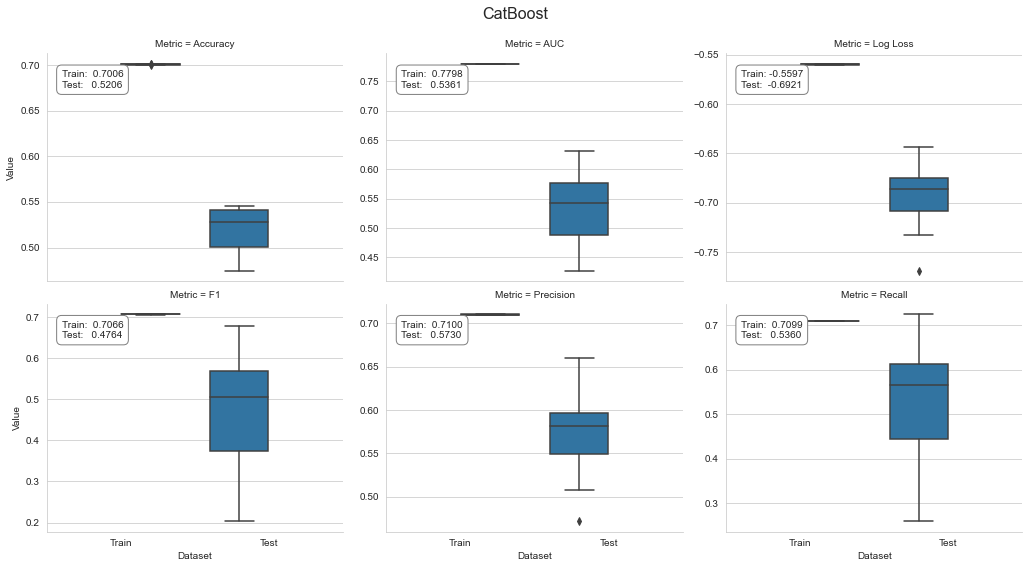

In [78]:
plot_result(cat_gpu_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

## Compare Results

In [79]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
           'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
CatBoost,0.538687,0.528178,0.530792,-0.692065,0.579603,0.540579
Gradient Booster,0.537038,0.503854,0.462321,-0.684883,0.549380,0.572452
CatBoost GPU,0.536141,0.520585,0.476402,-0.692090,0.572962,0.536045
AdaBoost,0.535296,0.503753,0.461851,-0.692853,0.542131,0.570321
LightGBM Factors,0.534029,0.514089,0.426485,-0.717203,0.554745,0.500317
LightGBM Dummies,0.529225,0.514994,0.434983,-0.702330,0.581769,0.514509
Random Forest,0.527921,0.511685,0.507196,-0.691195,0.564603,0.539264
XGBoost,0.526594,0.504881,0.398587,-0.704742,0.546037,0.499456
Baseline,0.503582,0.503582,0.516424,-17.070718,0.548116,0.505758


In [80]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm', 
                      'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster', 
                      'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

In [81]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')

In [82]:
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)

In [83]:
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
auc = auc[auc.Model != 'Baseline']

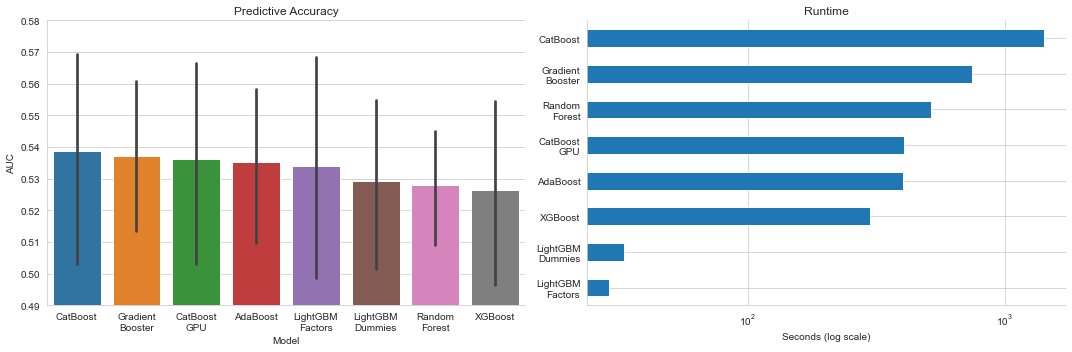

In [84]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC', 
            data=auc, 
            order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x:x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()
fig.tight_layout();